In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import glob, json
import numpy as np
import pandas as pd
import s4_authors_stats as s4
import dask.dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LogNorm

from functools import partial
from multiprocessing import Pool

In [2]:
def fos_sort(max_ws, fos):
    values = []
    fs = []
    count = []
    for field in unique:
        group = max_ws[fos == field]
        if len(group) < 500:
            continue
        median = np.percentile(group, 50)
        fs.append(field)
        values.append(median)
        count.append(len(group))
    values = np.asarray(values)
    fs = np.asarray(fs)
    count = np.asarray(count)
    idxs = np.argsort(values)
    values = values[idxs]
    fs = fs[idxs]
    count = count[idxs]
    
    return fs, count

In [3]:
tempsuffix = 2020
WS = np.asarray(json.load(open('results/ws_10a_full_%d.json' % tempsuffix)))
FOS = np.asarray(json.load(open('results/fos_10a_full_%d.json' % tempsuffix)))
unique = np.unique(FOS)
fos_sorted, _ = fos_sort(WS, FOS)

In [4]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

### Basic plots (TODO temporal version)

In [5]:
# def plot_hist(fig, group, bins, field_name, cumulative):
#     y,x = np.histogram(group, bins=bins)
#     if cumulative:
#         y = np.cumsum(y)
#         fig.plot(x[1:], y/y[-1], label=field_name)
#     else:
#         bins_center = 0.5*(x[:-1]+x[1:])
#         fig.plot(bins_center,y, label=field_name)
    
# def basic_hist(unique, fos, data, key, suffix, bins, yscale=None, xscale=None, cumulative=False):
#     fig, ax = plt.subplots()
    
#     for field in unique:
#         group = data[fos == field]
#         field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
#         plot_hist(ax, group, bins, field_name, cumulative)

#     ax.legend(bbox_to_anchor=(1.0, 1.05), prop={'size': 8})
#     if cumulative:
#         ax.axhline(0.5, xmin=0, xmax=1, color='red', alpha=0.5)
#     if yscale:
#         ax.set_yscale(yscale)
#     if xscale:
#         ax.set_xscale(xscale)
#     ax.set_title(labels_description[key]['title'])
#     ax.set_xlabel(labels_description[key]['x'])
#     ax.set_ylabel(labels_description[key]['y'])
#     fig.subplots_adjust(right=0.2)
#     fig.tight_layout()
#     fig.savefig('outputs/fos_hist_%s%s.pdf' % (key,suffix))
#     fig.show()

# labels_description = {
#     'max_colabs': {'x': 'percentage of papers published with top collaborator', 'y': 'cumulative density of authors', 'title': ''},
#     'max_ws': {'x': 'percentage of citations with top collaborator', 'y': 'cumulative density of authors', 'title': ''},
#     'birth': {'x': 'birth year', 'y': 'cumulative density of authors', 'title': ''},
#     'papers': {'x': 'number of papers', 'y': 'number of authors', 'title': ''},
#     'total_cits': {'x': 'number of citations', 'y': 'number of authors', 'title': ''} 
# }    

# basic_hist(fos_sorted, FOS, WP, 'max_colabs', suffix=SUFFIX_STR, bins=50, cumulative=True) # papers
# basic_hist(fos_sorted, FOS, WS, 'max_ws', suffix=SUFFIX_STR, bins=50, cumulative=True) # citações
# basic_hist(fos_sorted, FOS, Y, 'birth', suffix=SUFFIX_STR, bins=10, cumulative=True)
# xspace = np.logspace(np.log10(min(P)), np.log10(max(P)), 10)
# basic_hist(fos_sorted, FOS, P, 'papers', suffix=SUFFIX_STR, bins=xspace, yscale='log', xscale='log')
# xspace = np.logspace(np.log10(min(C)), np.log10(max(C)), 10)
# basic_hist(fos_sorted, FOS, C, 'total_cits', suffix=SUFFIX_STR, bins=xspace, yscale='log', xscale='log')

### Temporal 2d histograms

In [6]:
def _hist2d(ax, xgroup, ygroup, xspace, yspace, field_name): 
    ax.set_facecolor("black")
    im = ax.hist2d(xgroup, ygroup, bins=(xspace, yspace), cmap='inferno', norm=LogNorm()) #vmin=1,vmax=10000))
    ax.set_title("%s \nspearman=%.2f \npearson=%.2f" % (field_name, spearmanr(xgroup, ygroup)[0], pearsonr(xgroup, ygroup)[0]))
    return im


def hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale, yscale='linear'):
    for field in fos_sorted:
        fig,axes = plt.subplots(figsize=(25, 4), nrows=1, ncols=7, sharex=True, sharey=True)

        for i, tempsuffix in enumerate(range(1960, 2021, 10)):
            X = np.asarray(json.load(open(x_filename % tempsuffix)))
            Y = np.asarray(json.load(open(y_filename % tempsuffix)))

            FOS = np.asarray(json.load(open('results/fos_10a_full_%d.json' % tempsuffix)))

            idxs = FOS == field
            tempX = X[idxs]
            tempY = Y[idxs]
            if xscale == 'log':
                xbins = np.logspace(np.log10(min(tempX)), np.log10(max(tempX)+1), 10)
            else:
                xbins = np.linspace(min(tempX), max(tempX), 10)
               
            if yscale == 'log':
                ybins = np.logspace(np.log10(min(tempY)), np.log10(max(tempY)+1), 10)
            else:        
                ybins = np.linspace(min(tempY), max(tempY), 10)
            
            im = _hist2d(axes[i], tempX, tempY, xbins, ybins, '%d' % tempsuffix)
            axes[i].set_xscale(xscale)
            fig.colorbar(im[3], ax=axes[i])
            axes[i].set_xlabel(xlabel)
            if i == 0:
                axes[i].set_ylabel(ylabel)

        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        fig.suptitle(field_name, y=1.15)

        fig.tight_layout()
        fig.savefig('outputs/hist2d_%s_%s_temporal.pdf' % (name, field_name))    

<ipython-input-6-4b359177def3>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axes = plt.subplots(figsize=(25, 4), nrows=1, ncols=7, sharex=True, sharey=True)


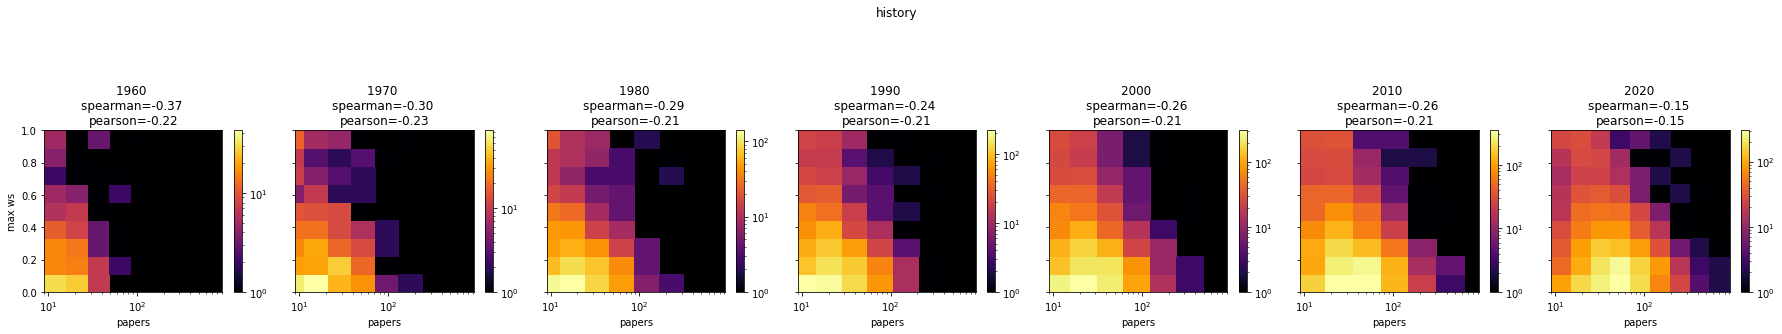

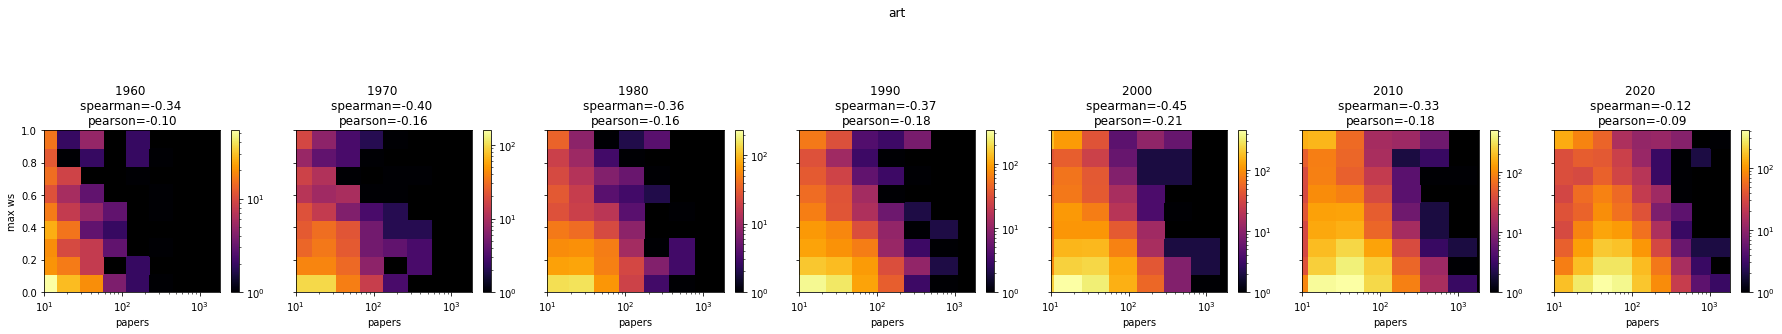

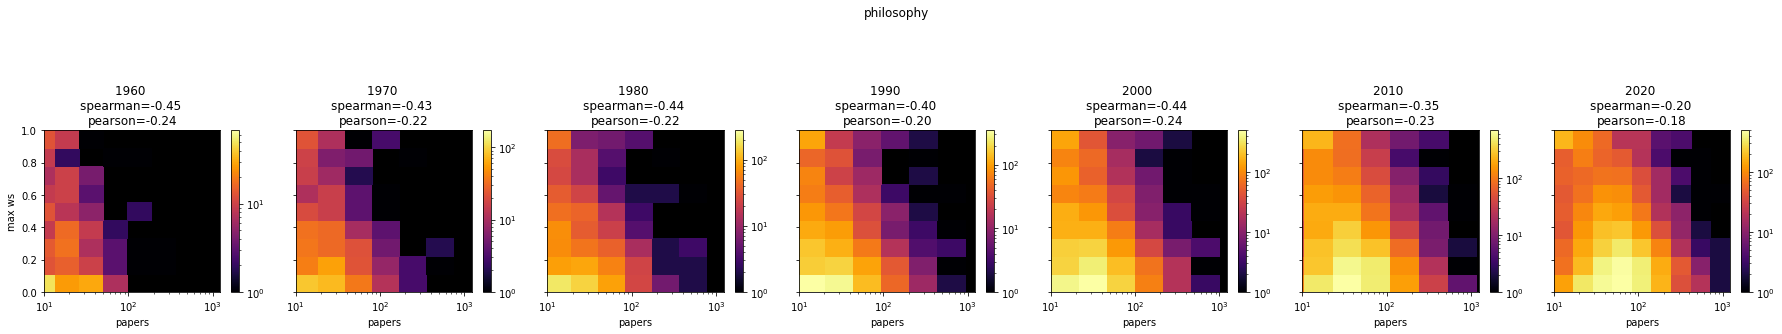

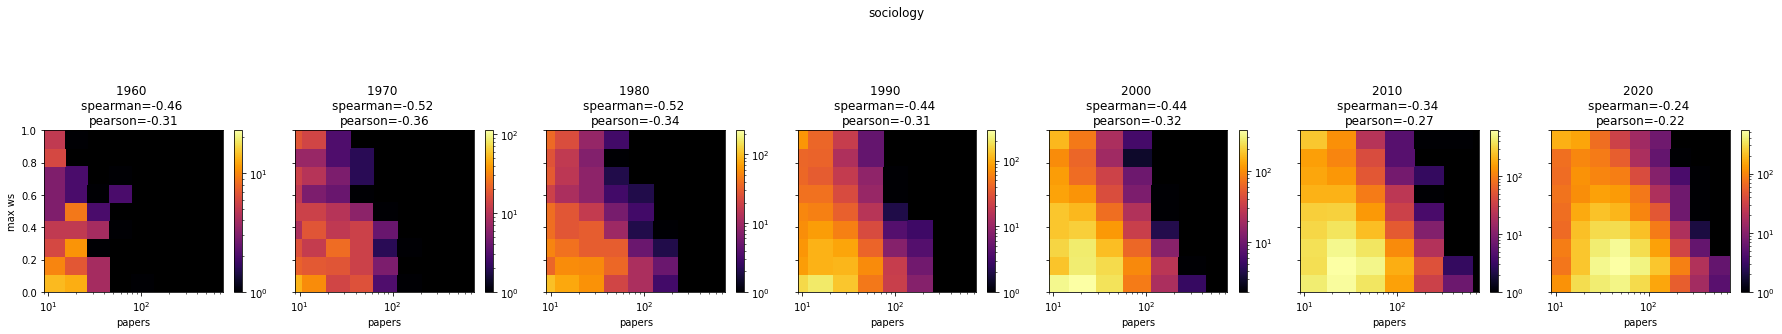

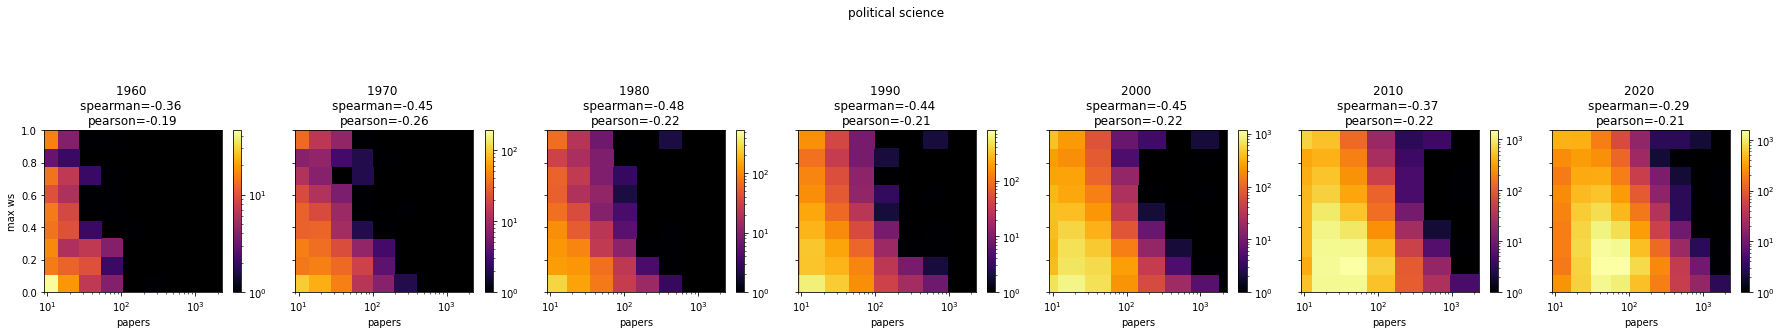

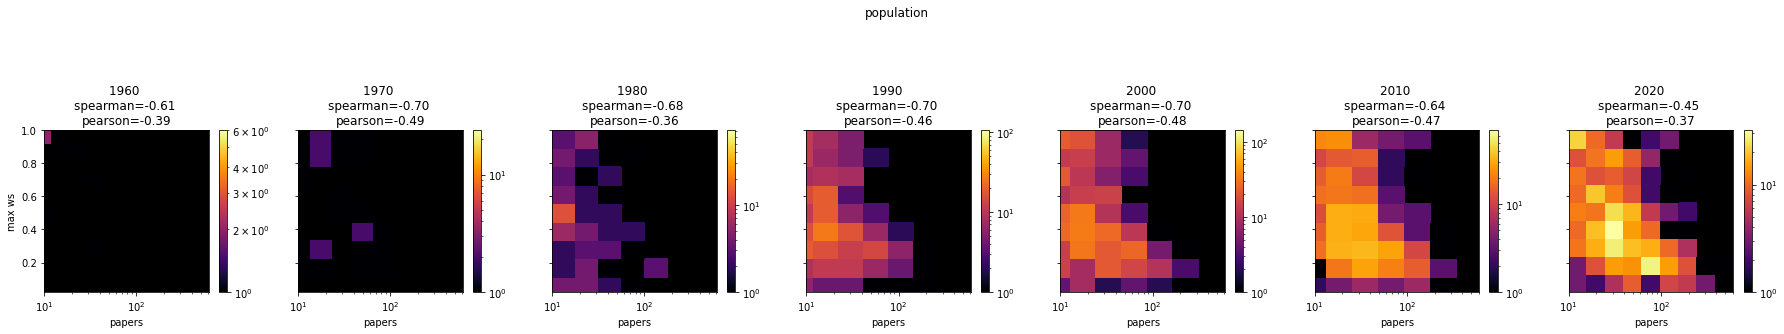

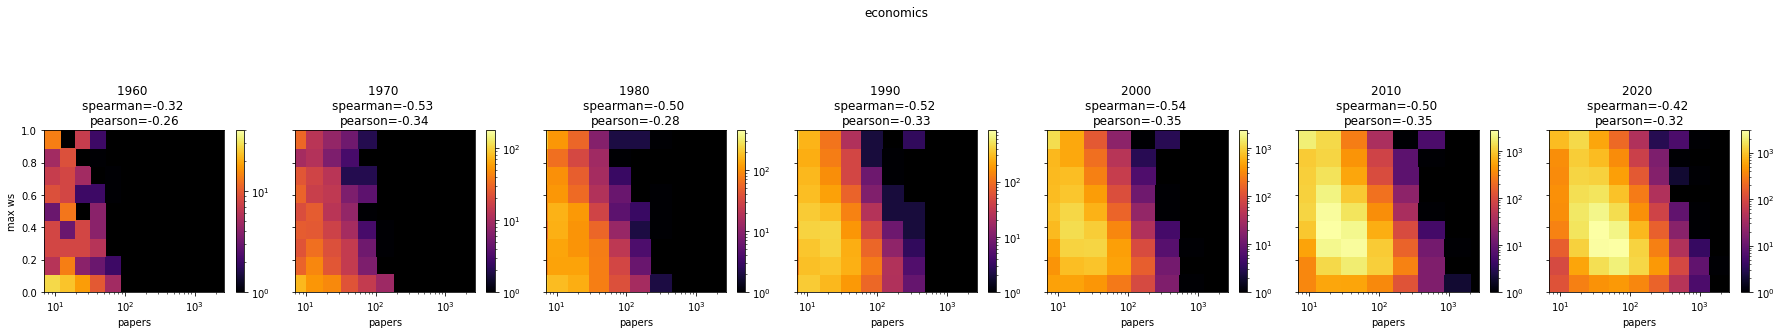

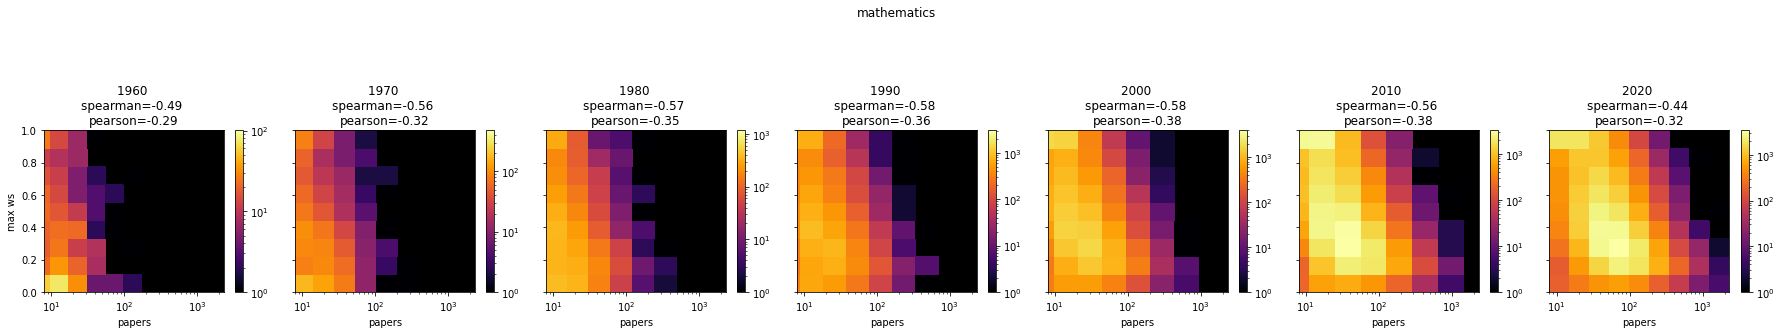

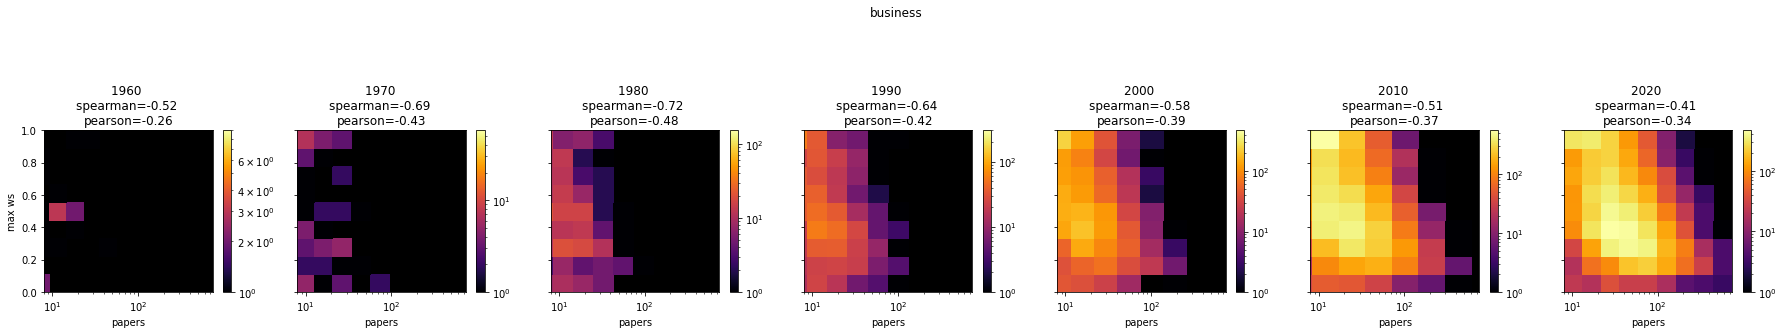

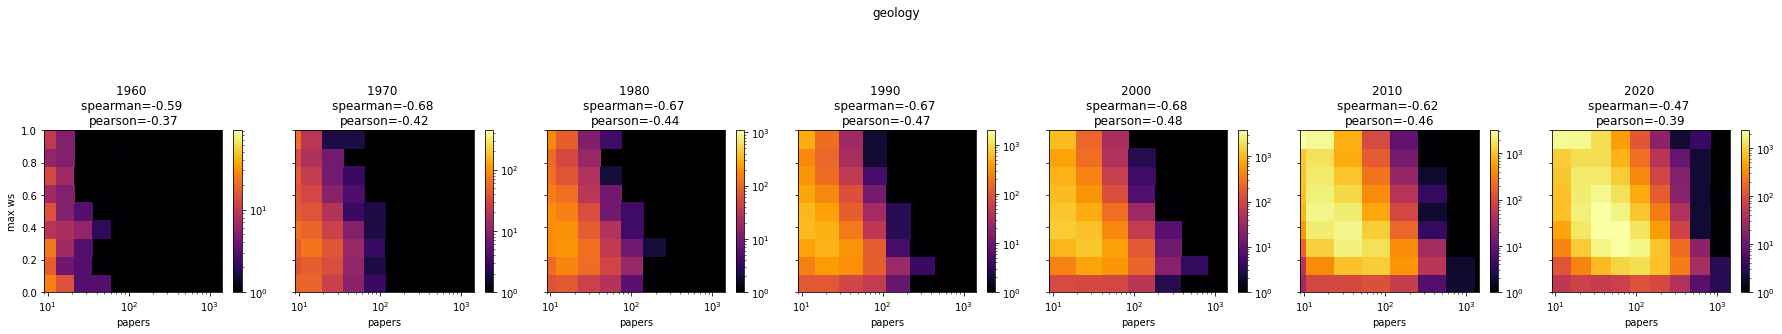

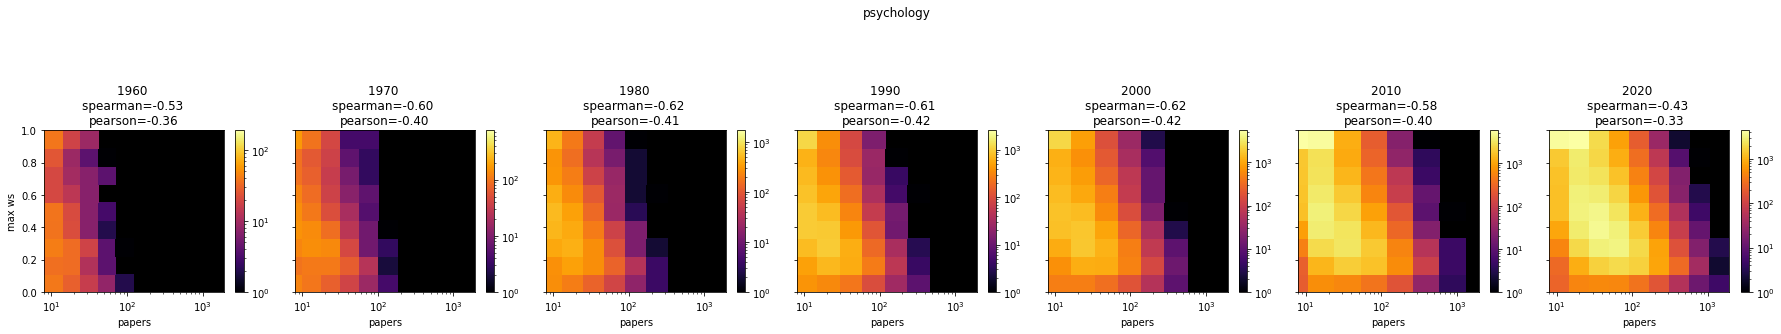

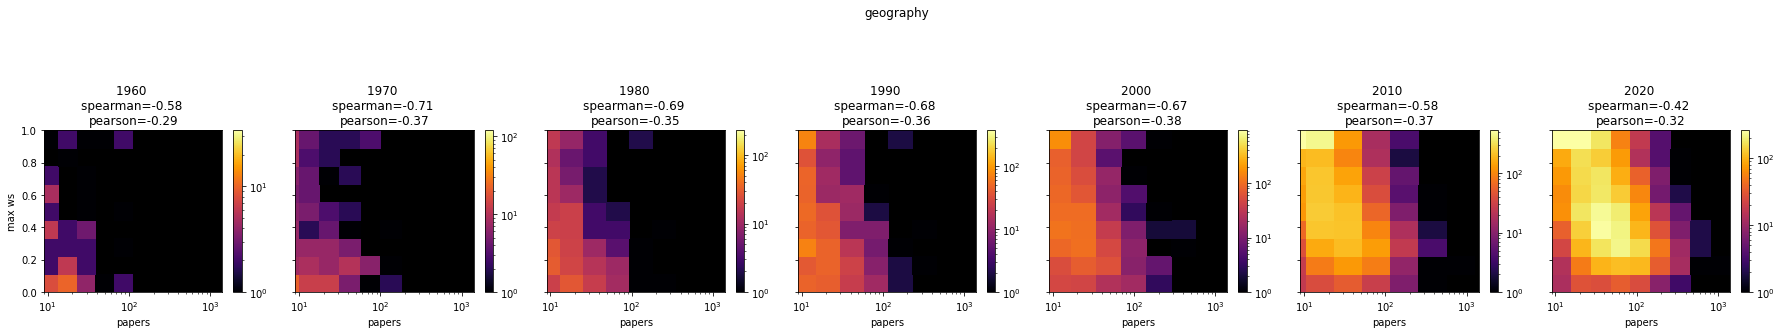

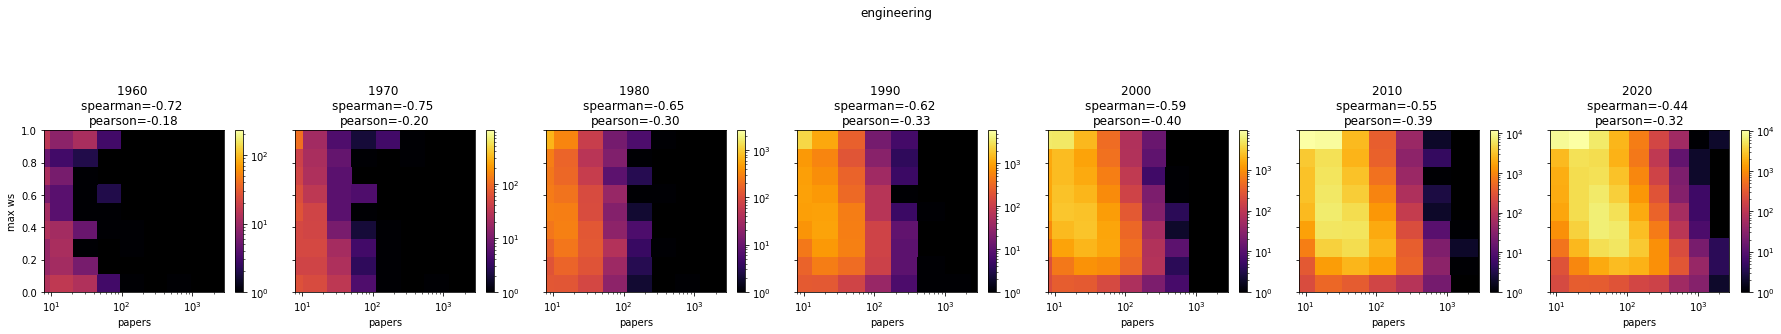

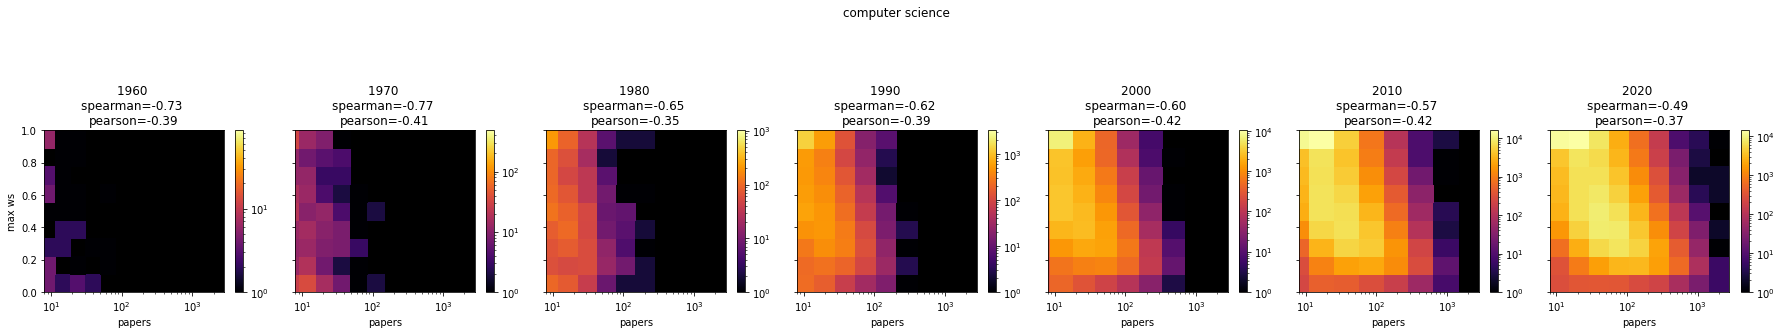

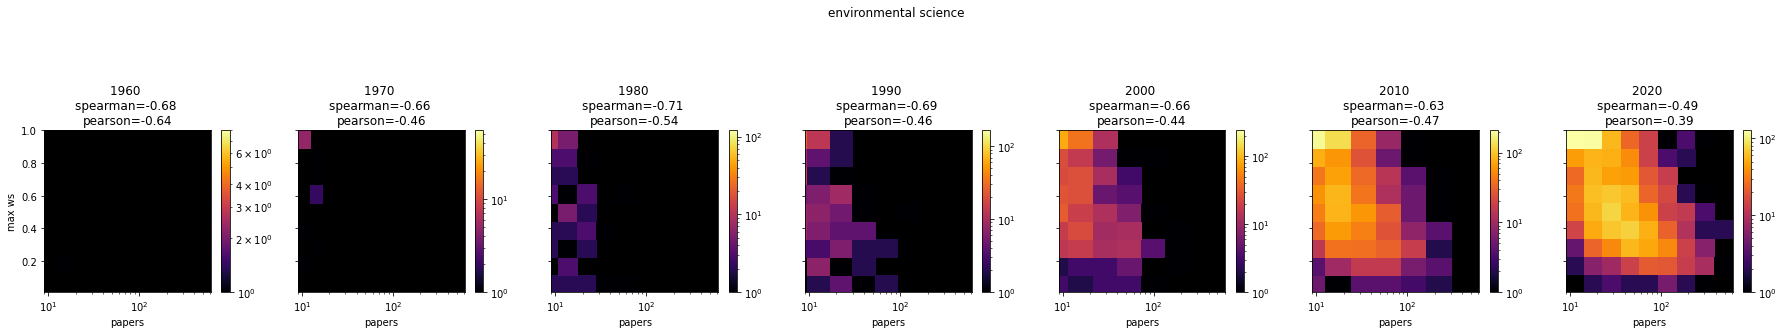

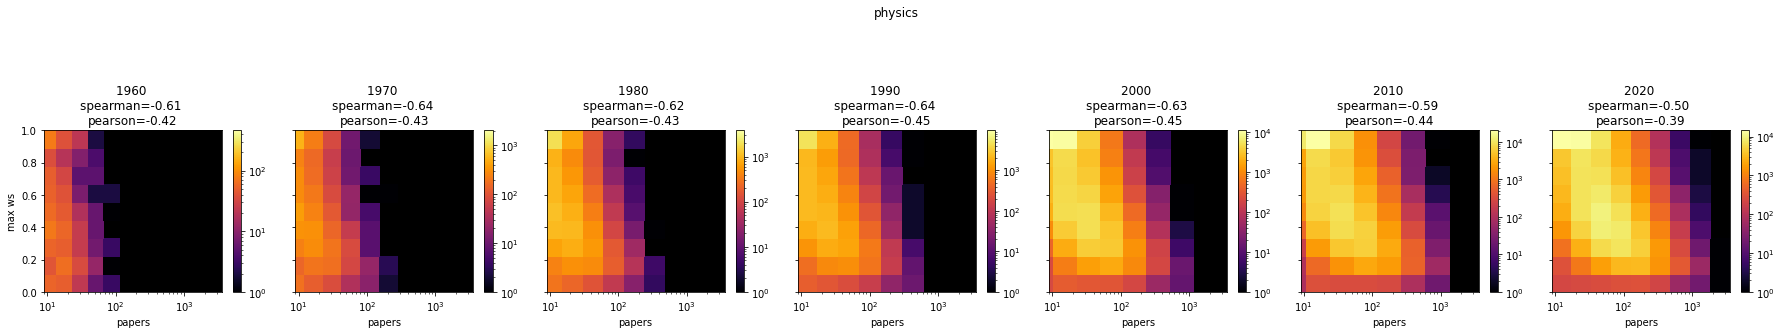

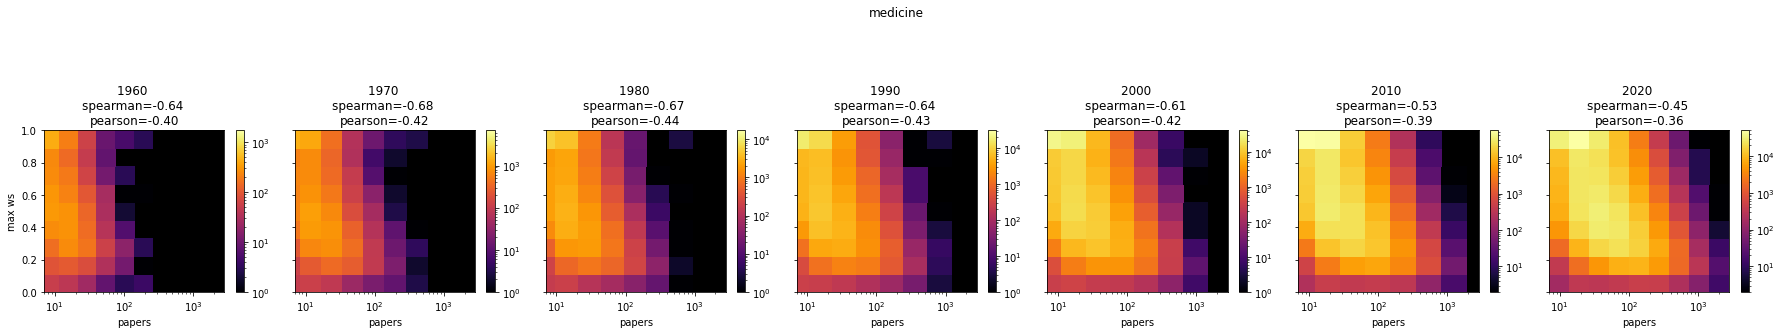

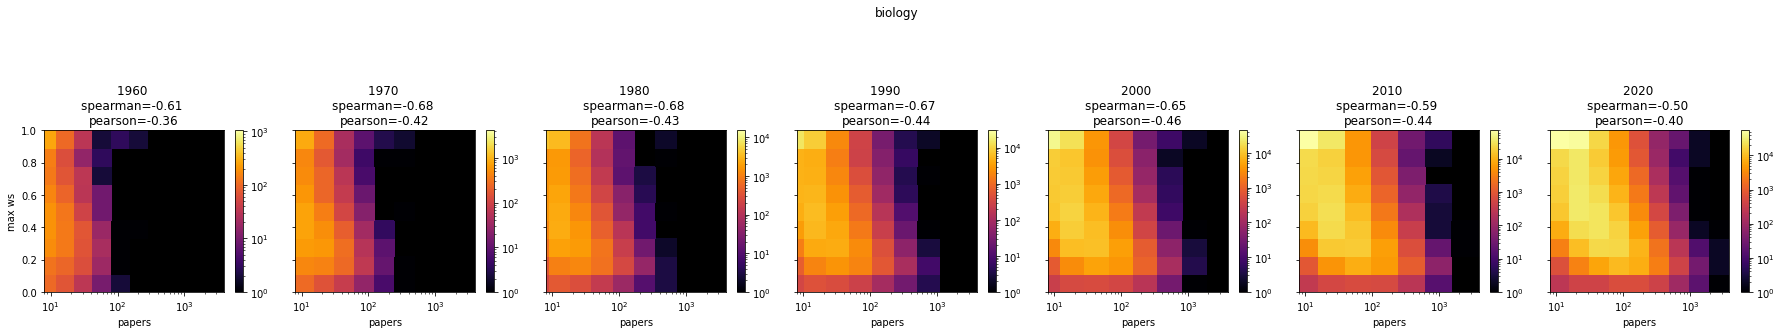

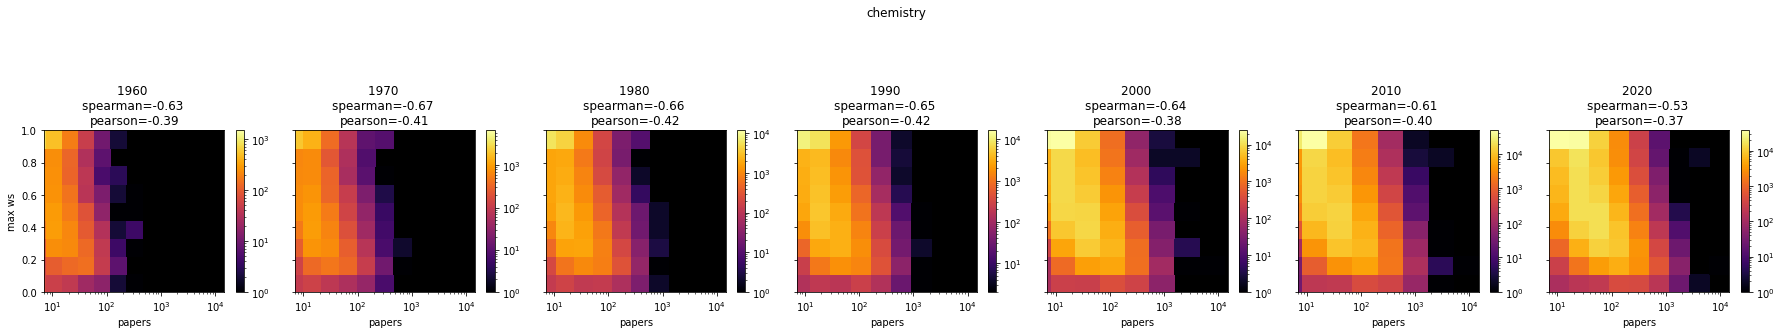

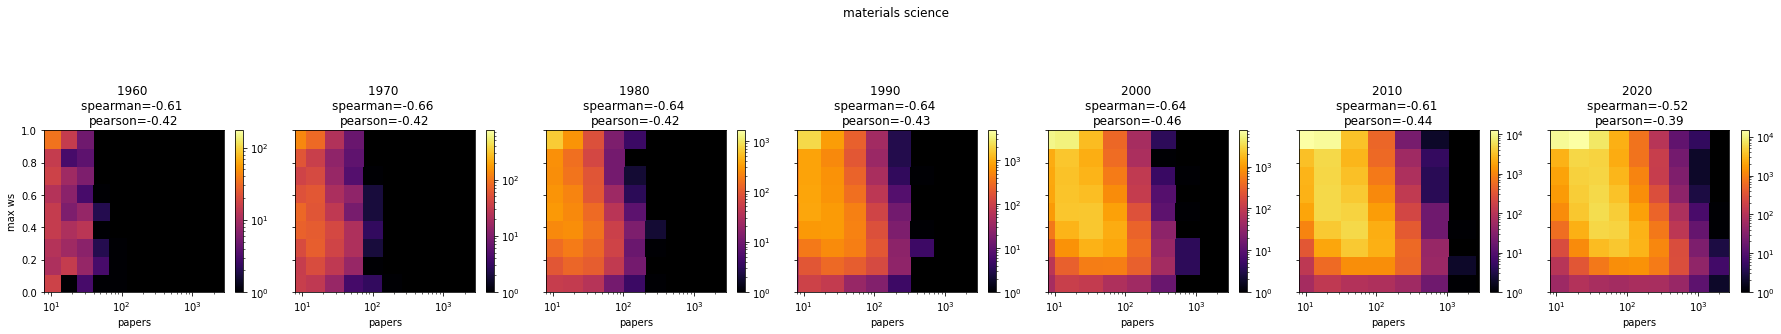

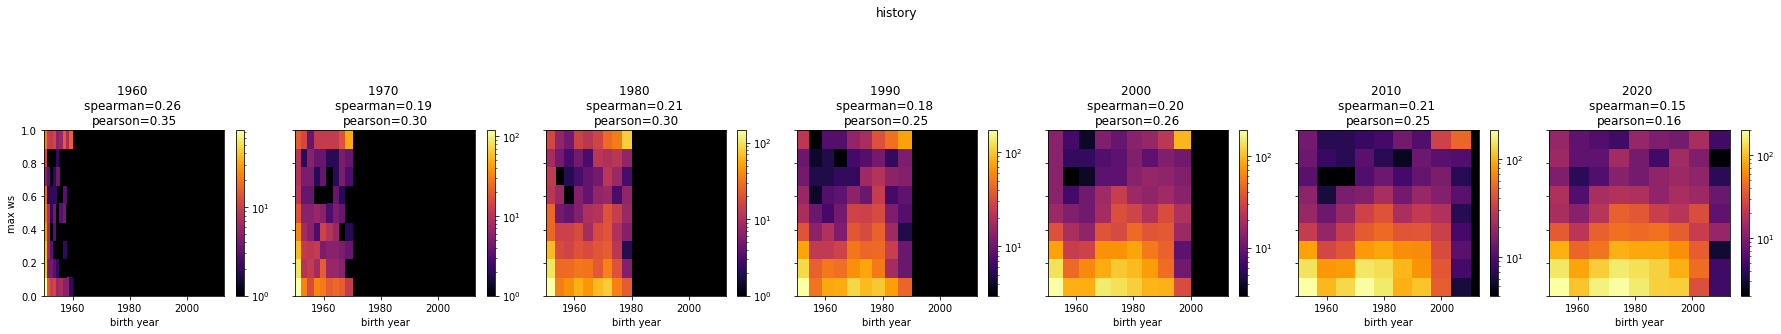

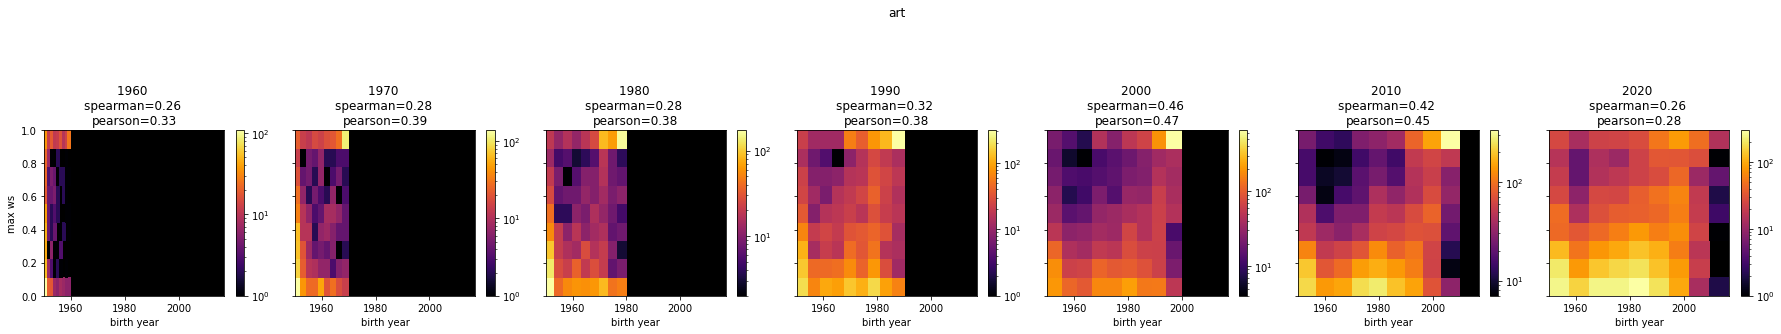

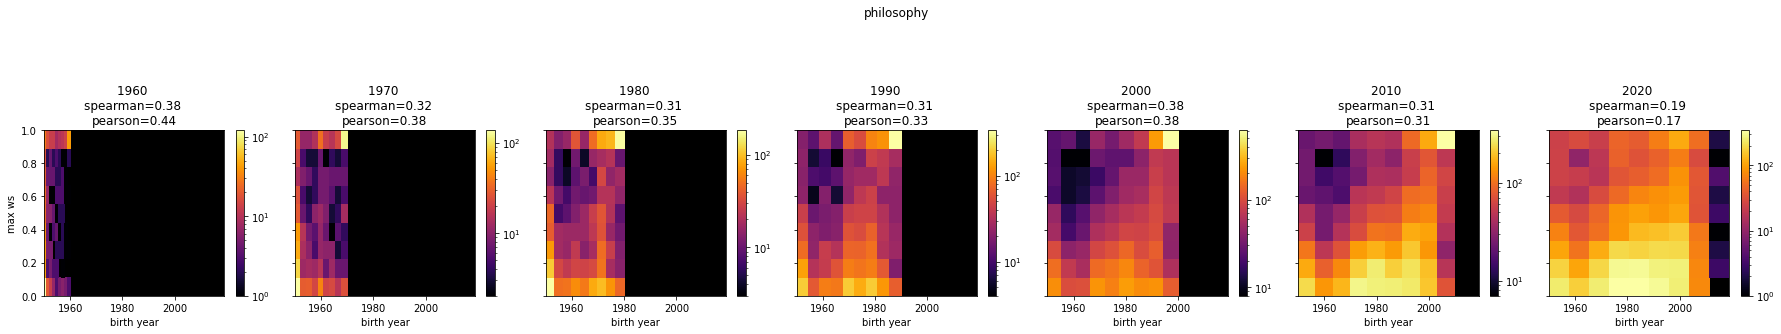

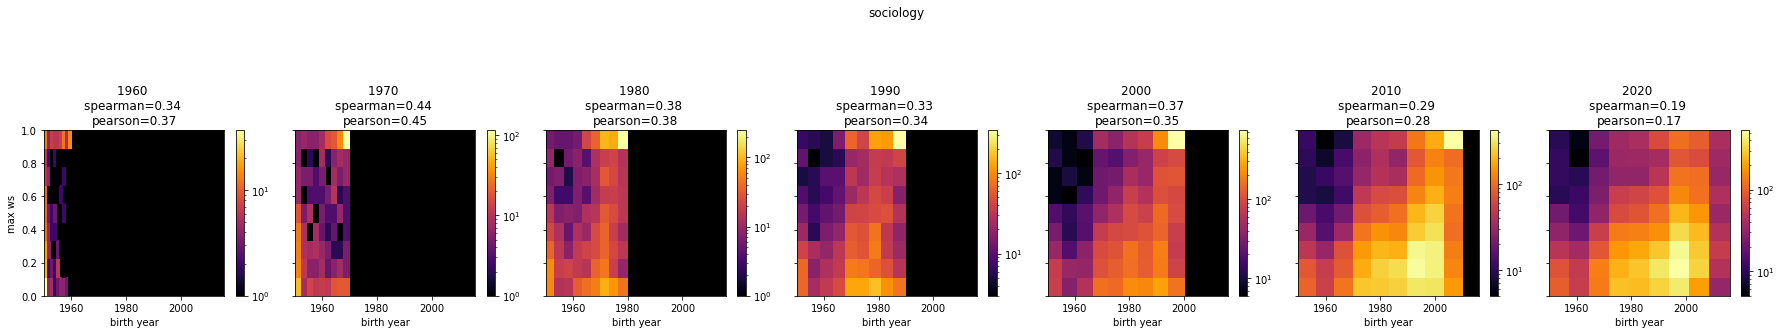

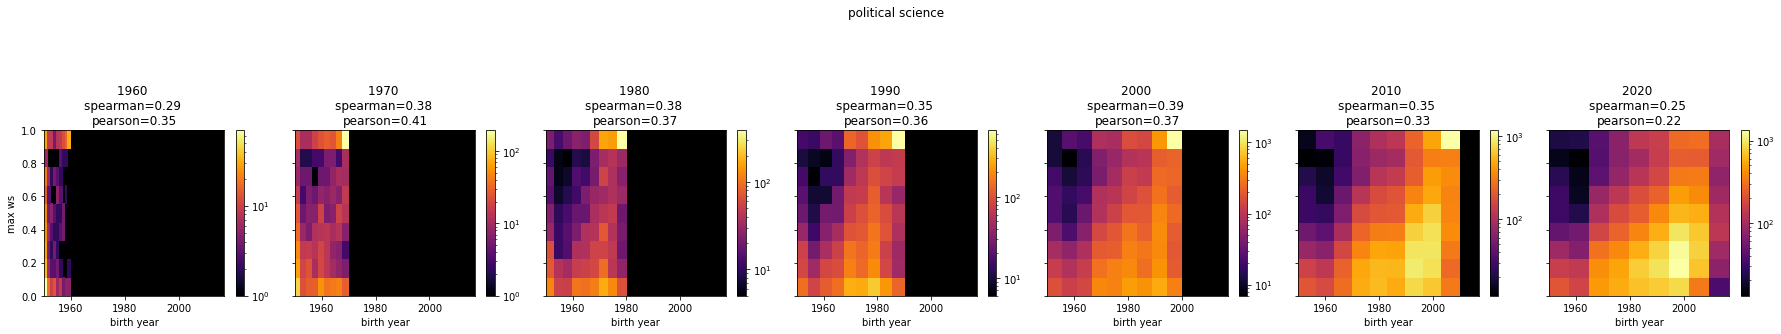

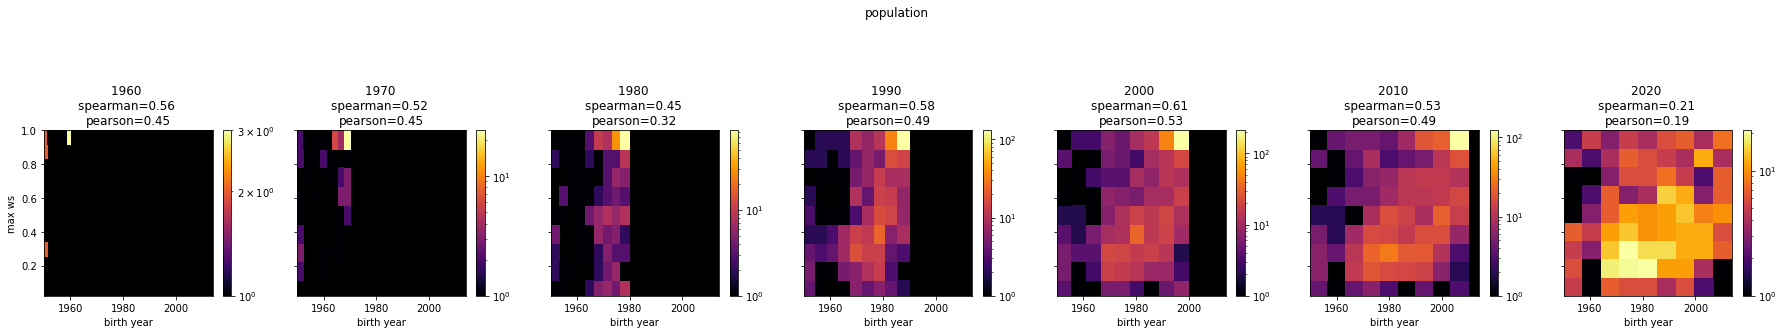

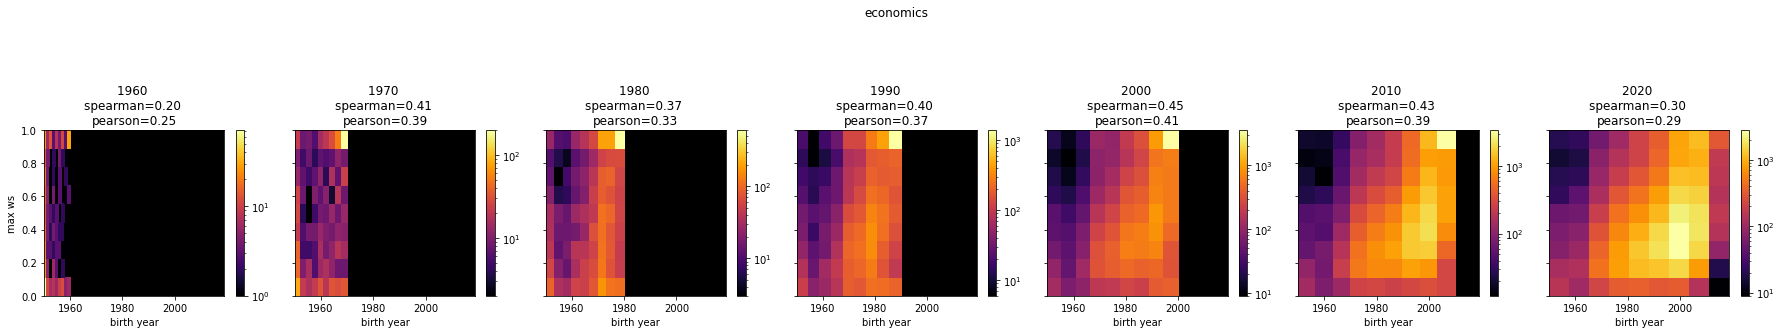

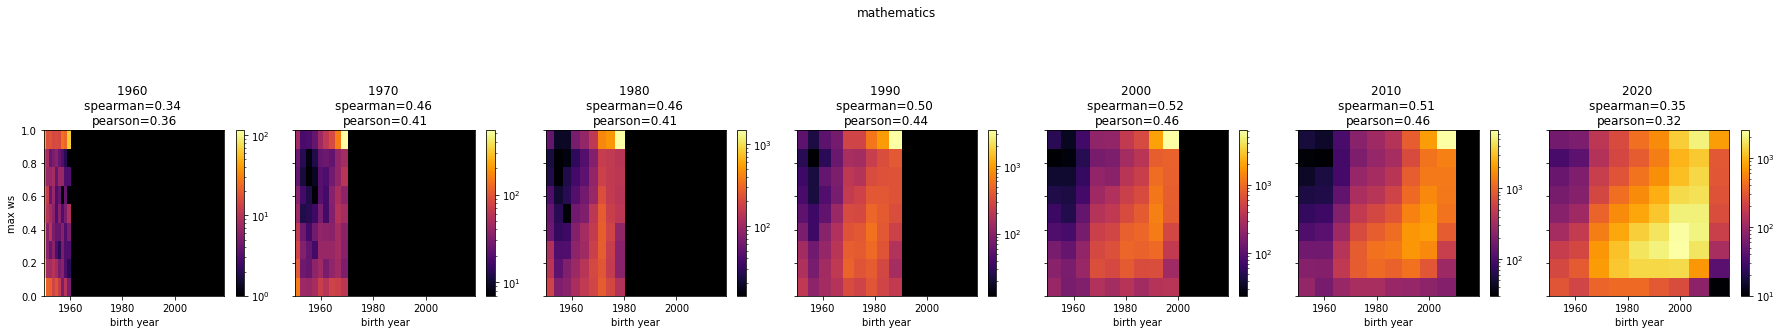

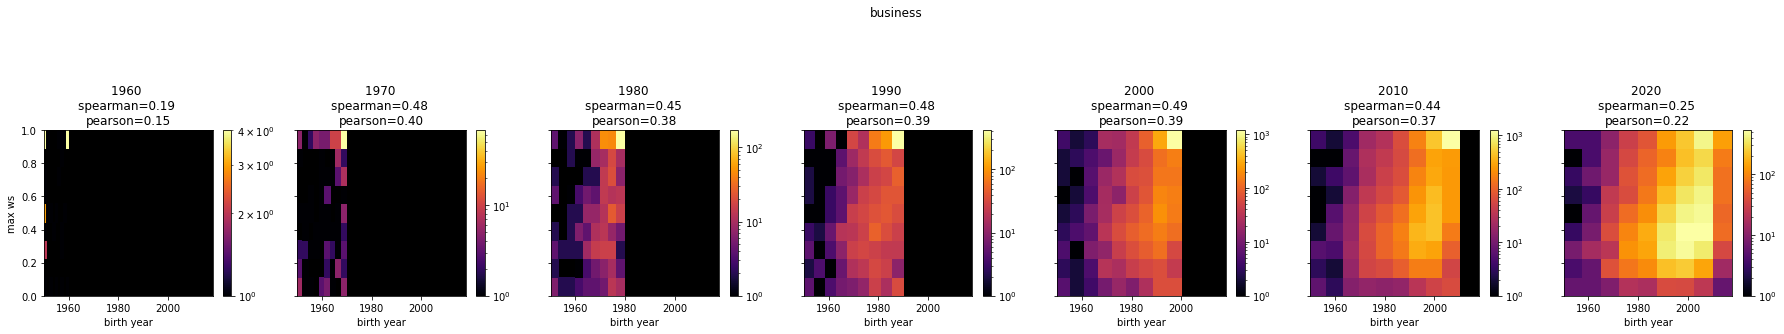

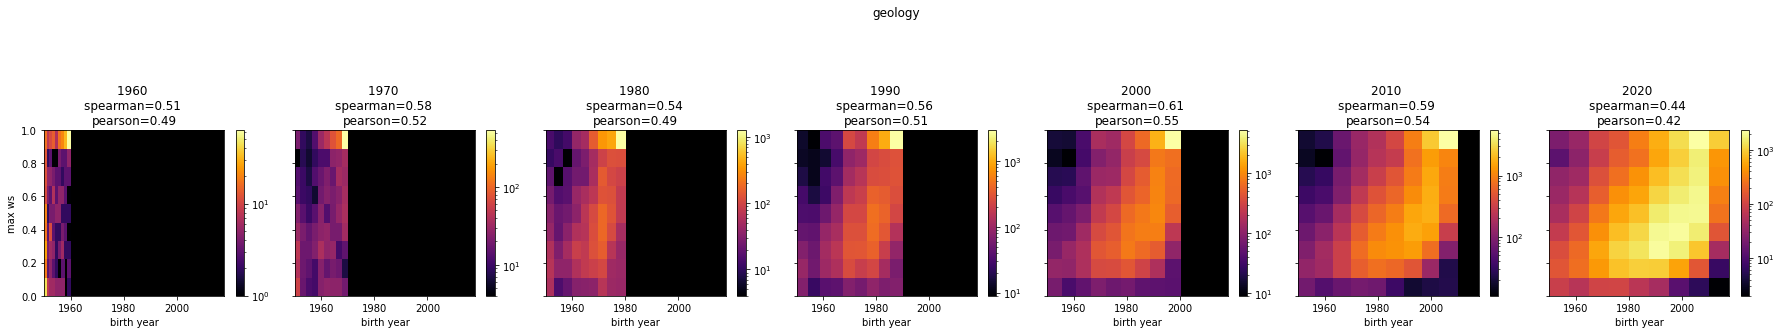

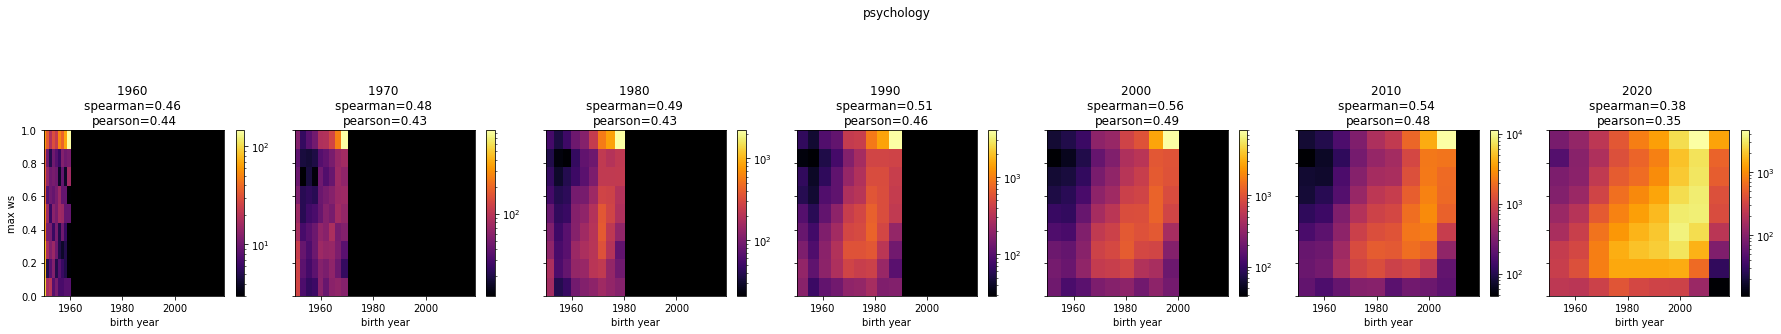

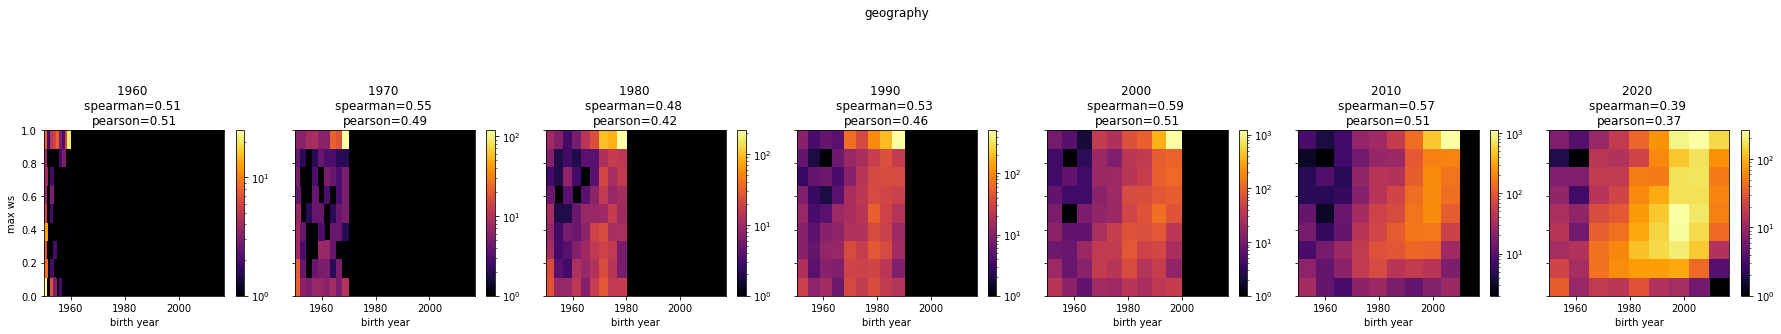

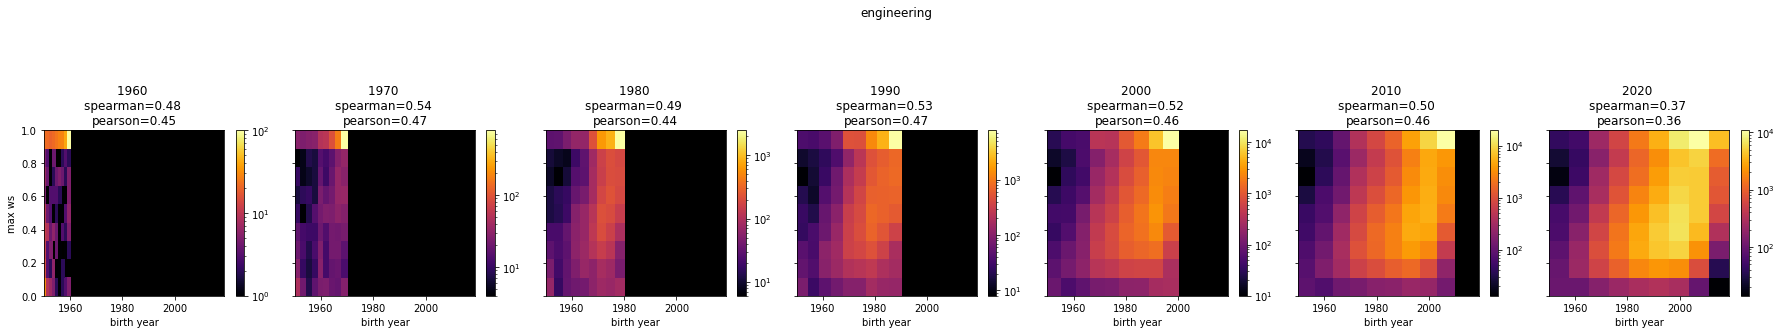

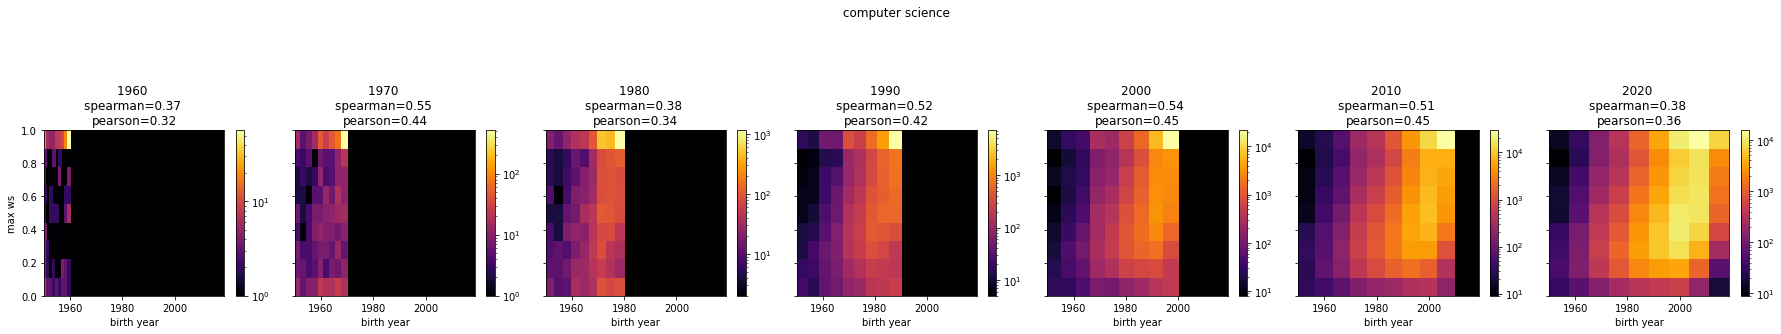

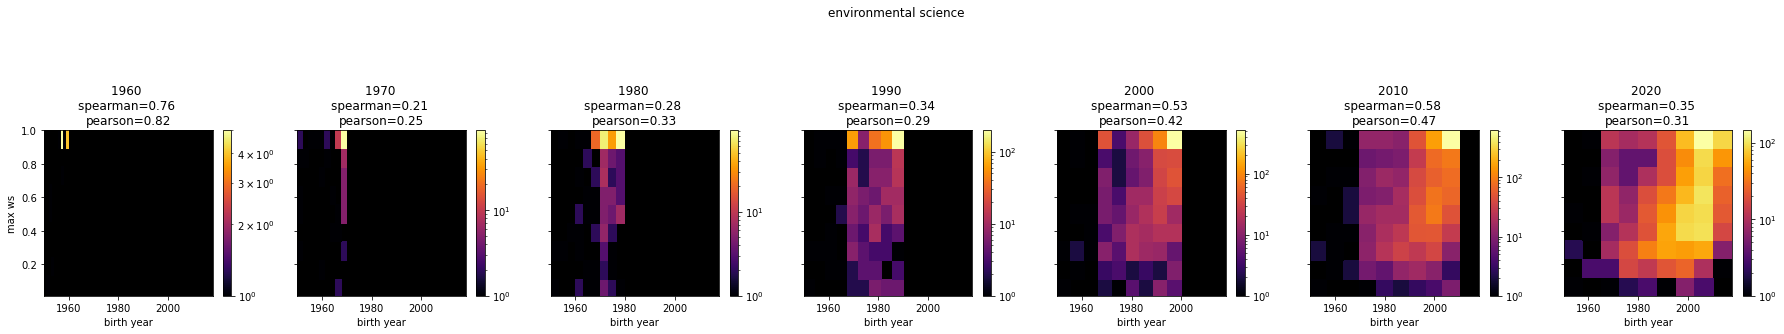

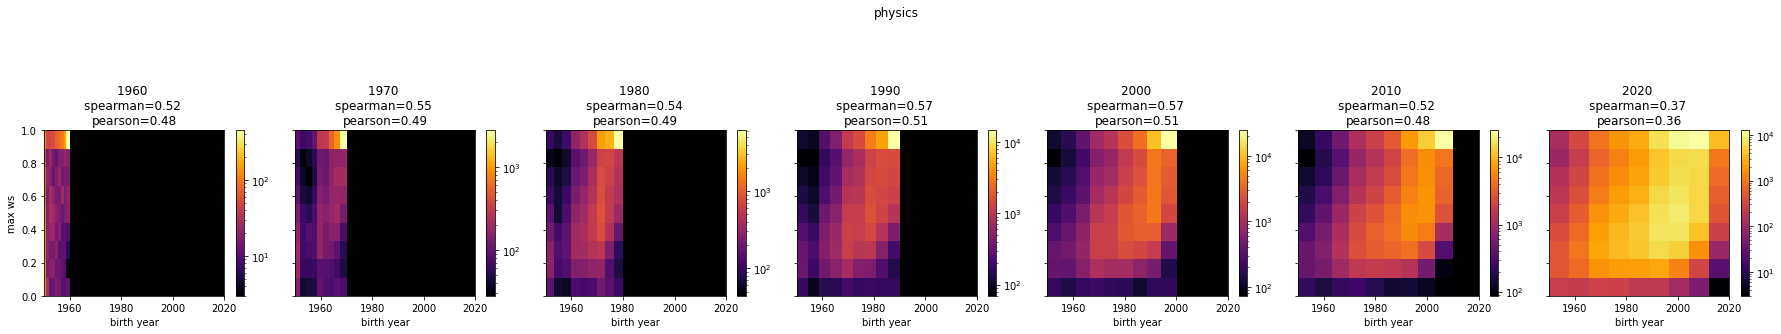

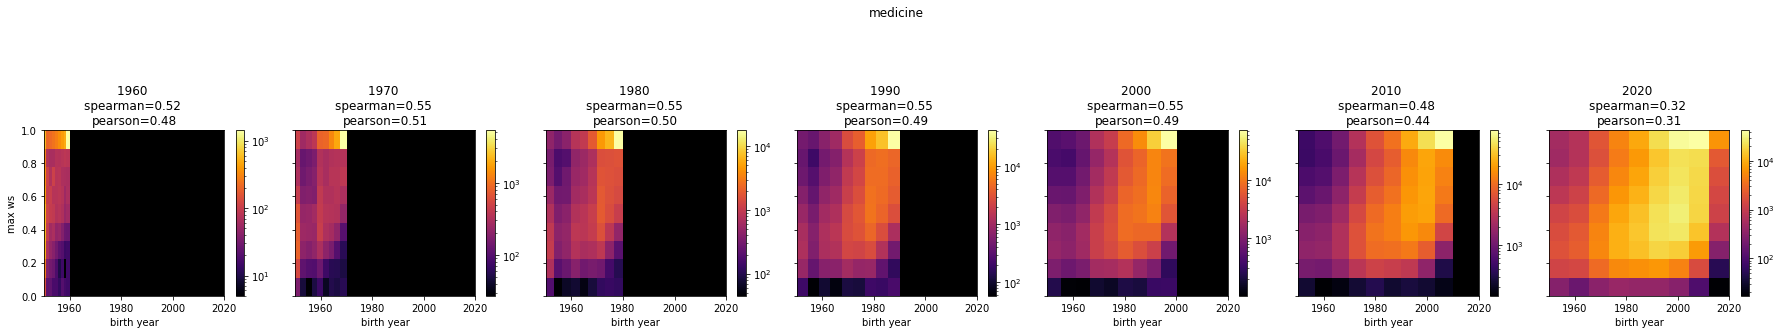

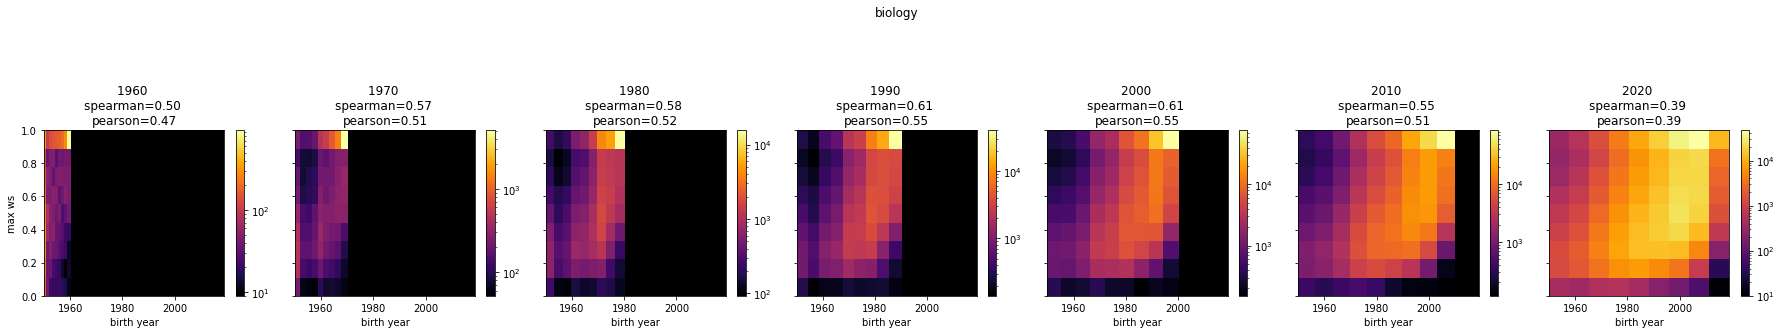

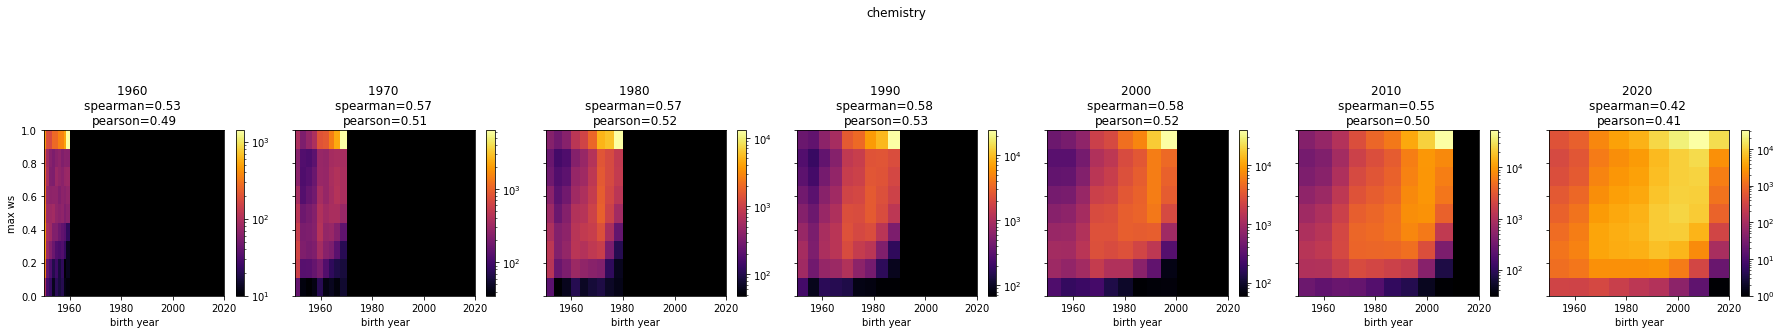

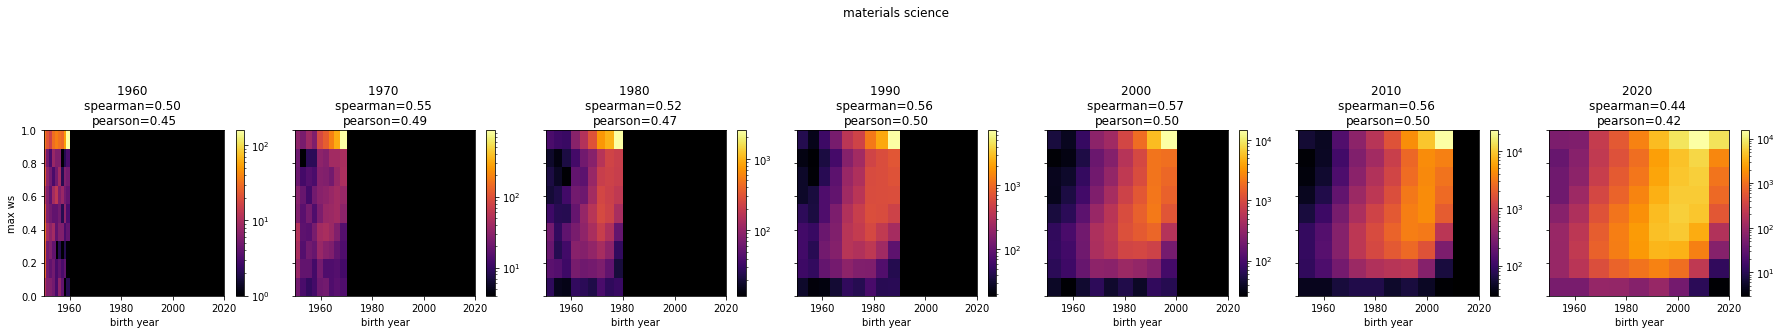

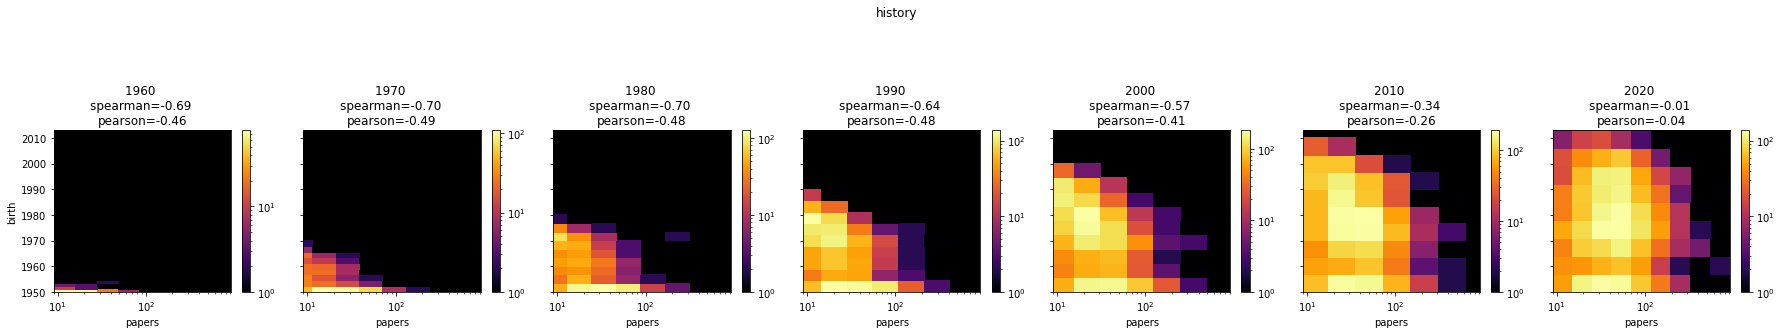

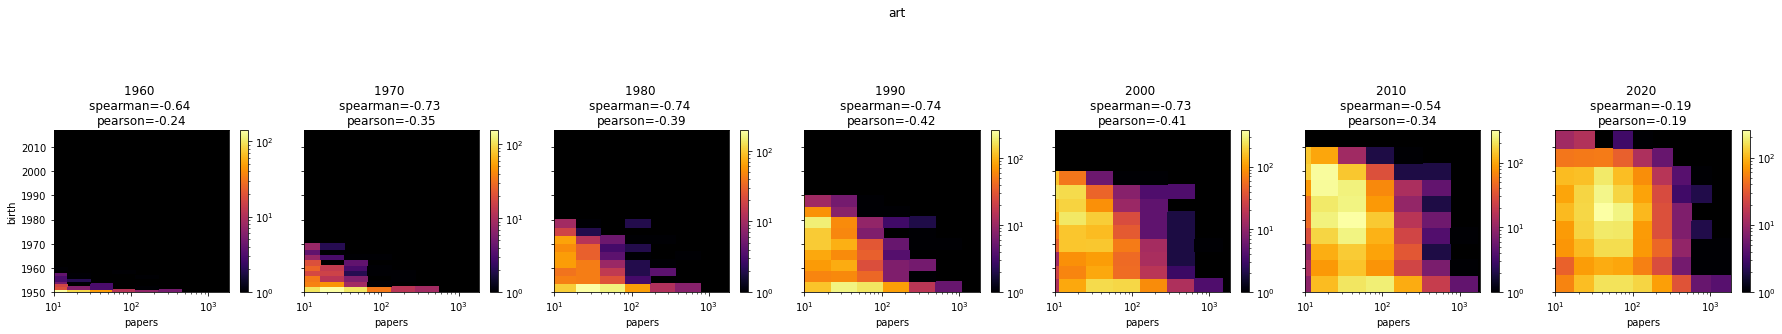

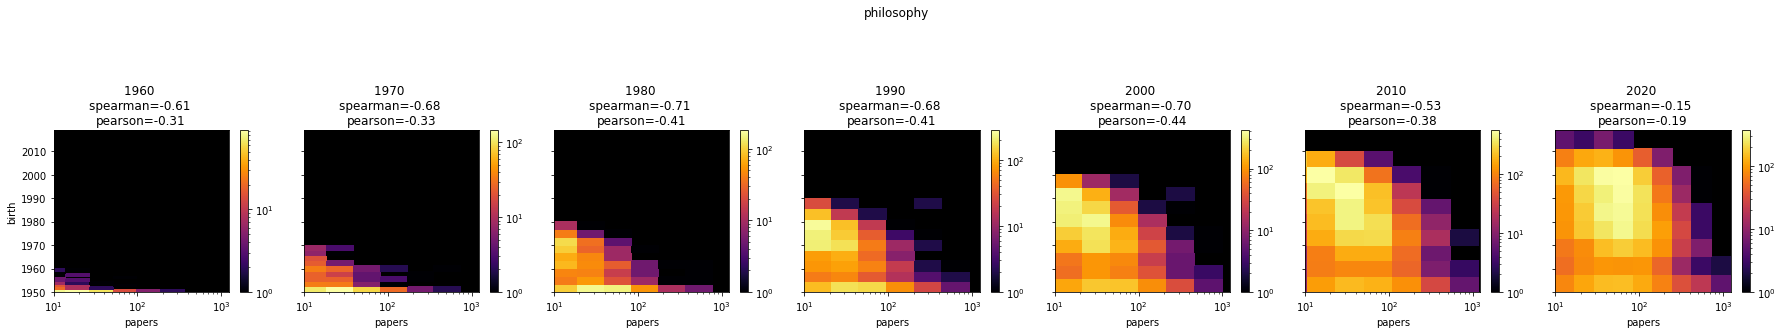

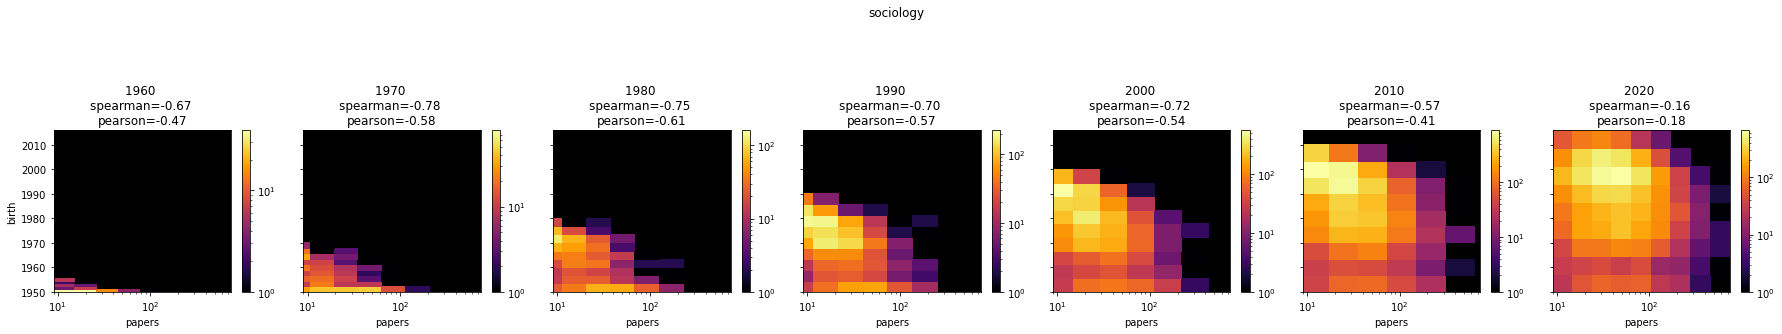

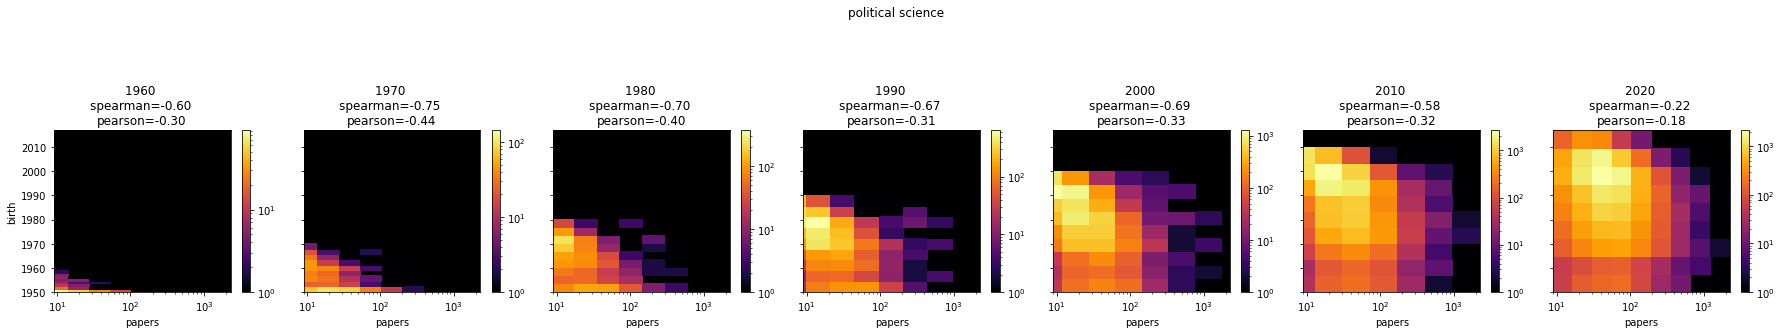

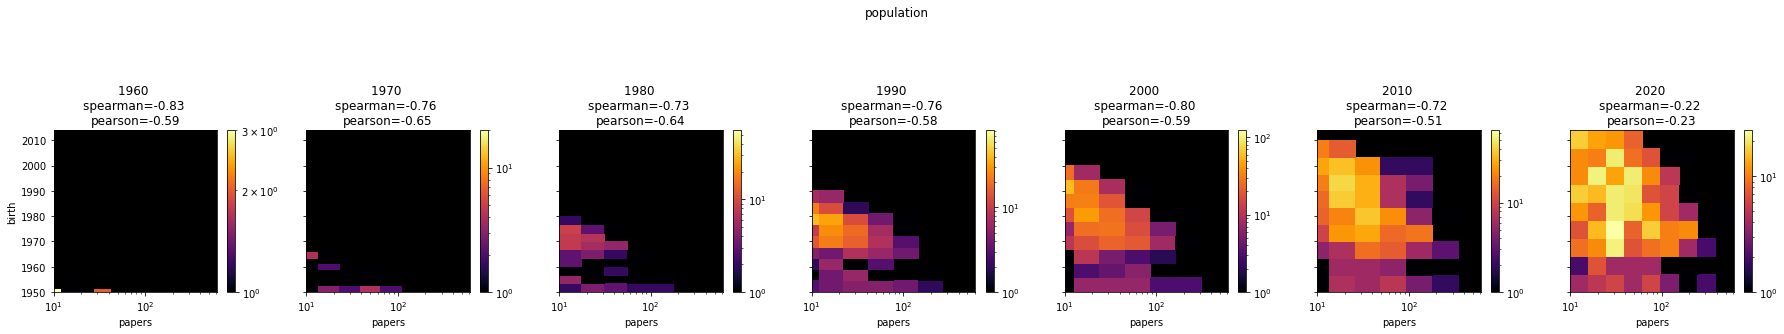

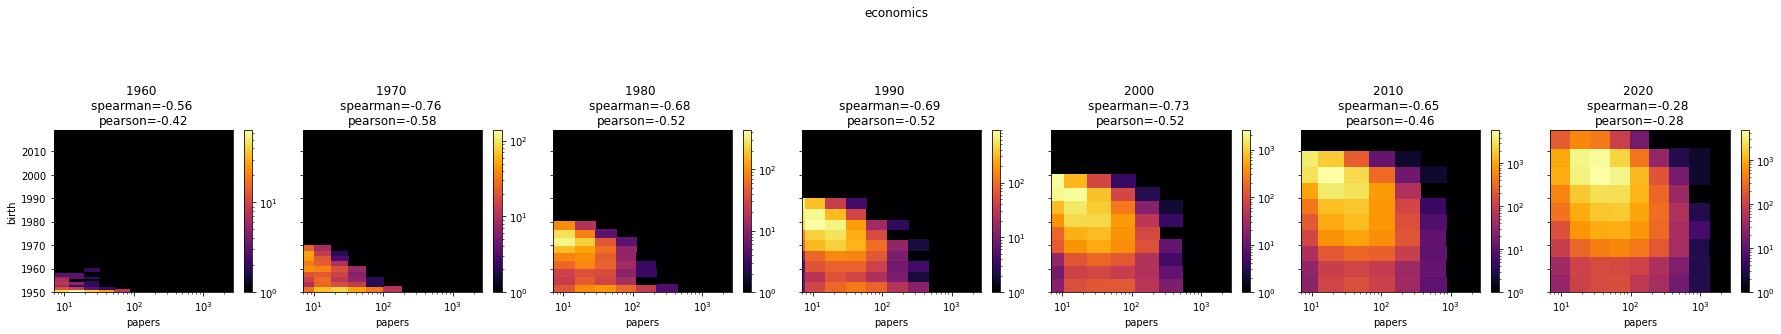

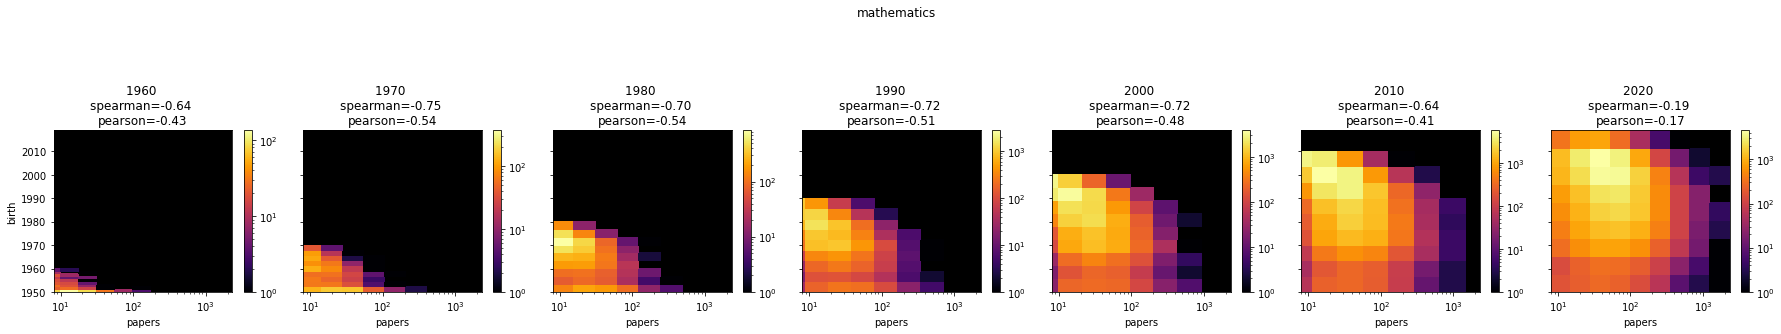

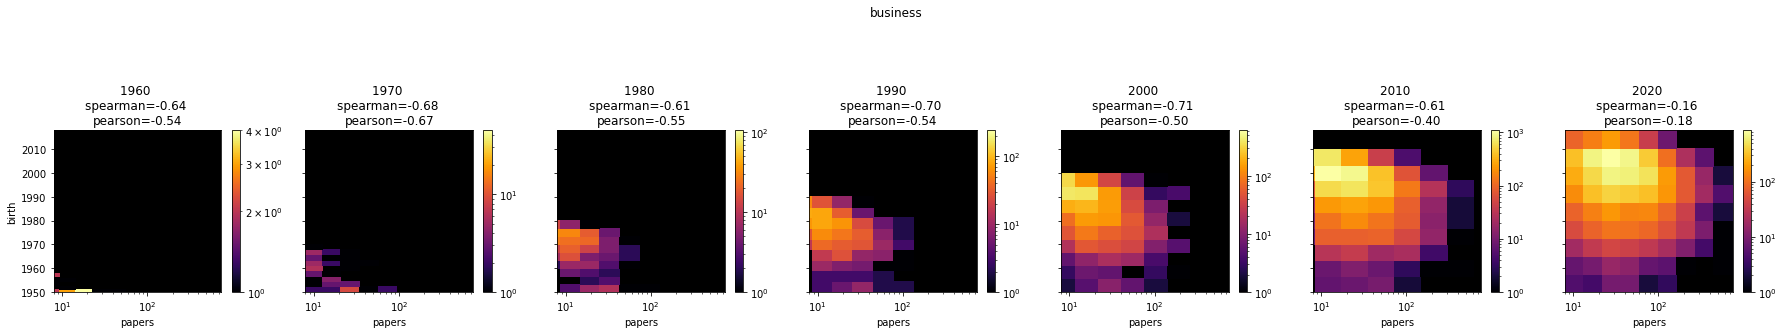

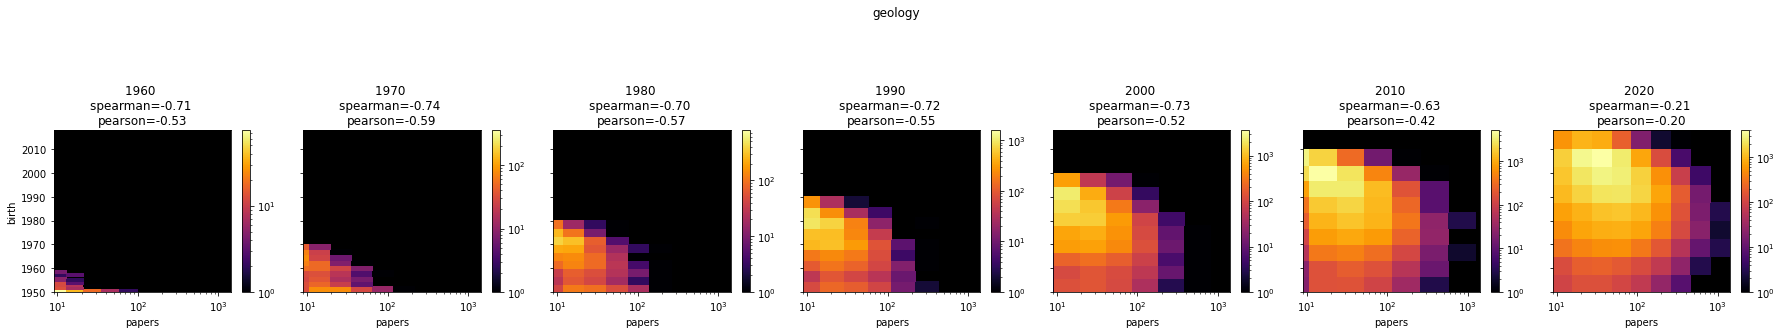

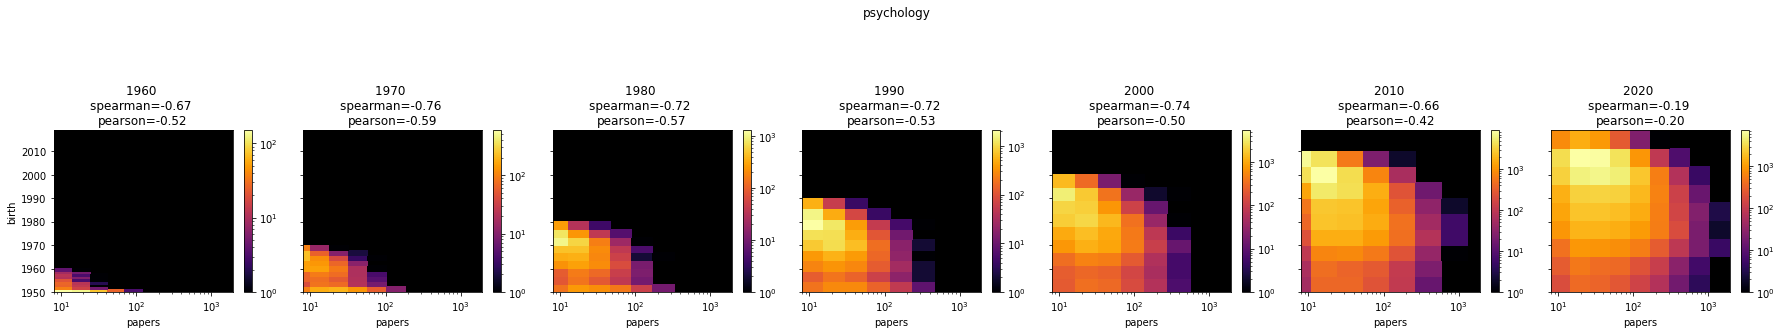

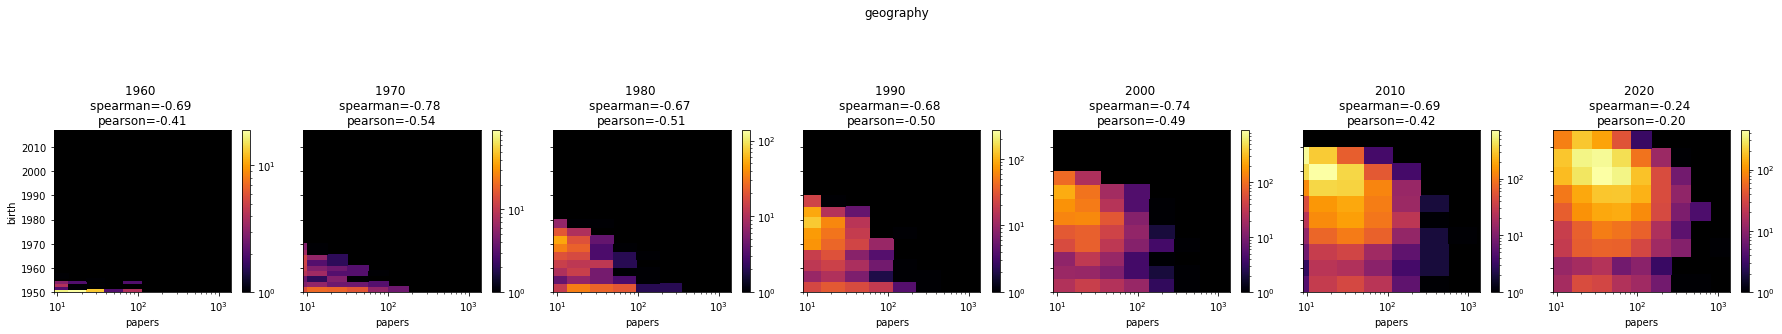

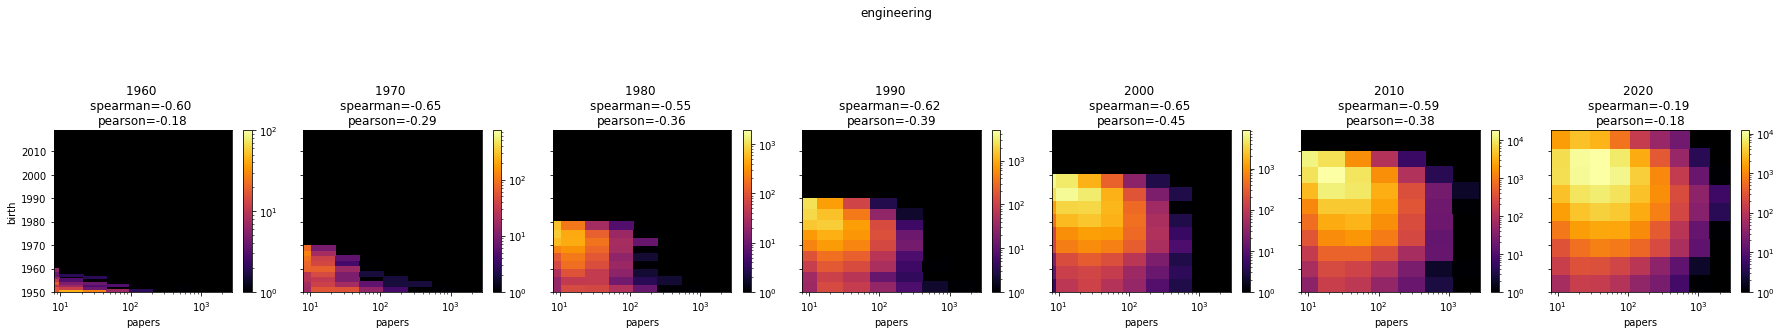

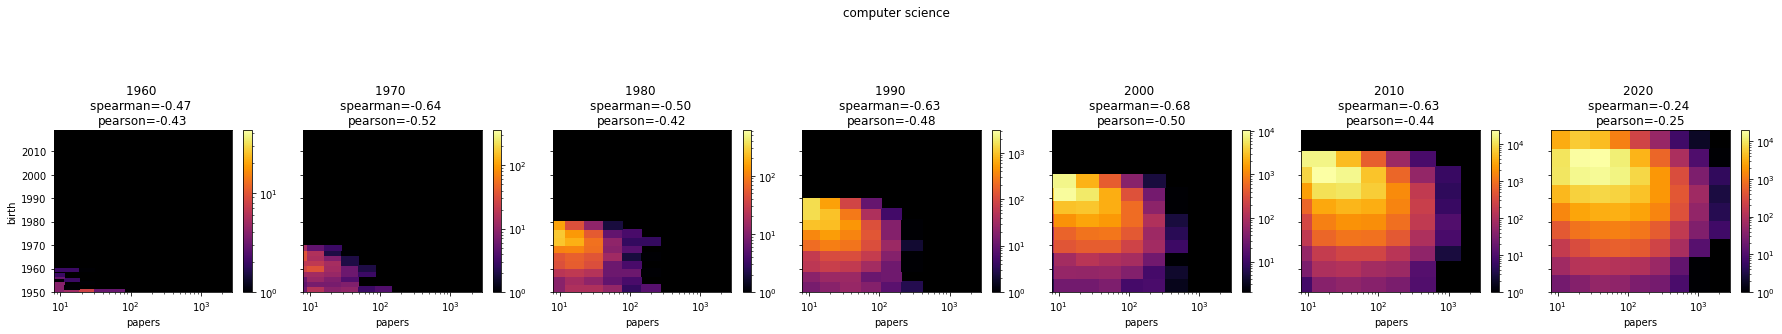

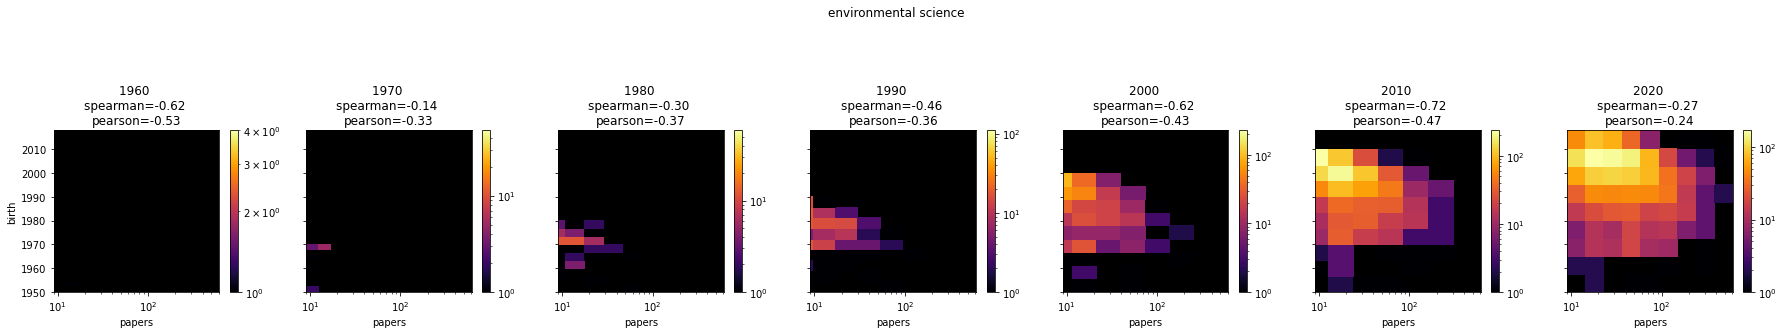

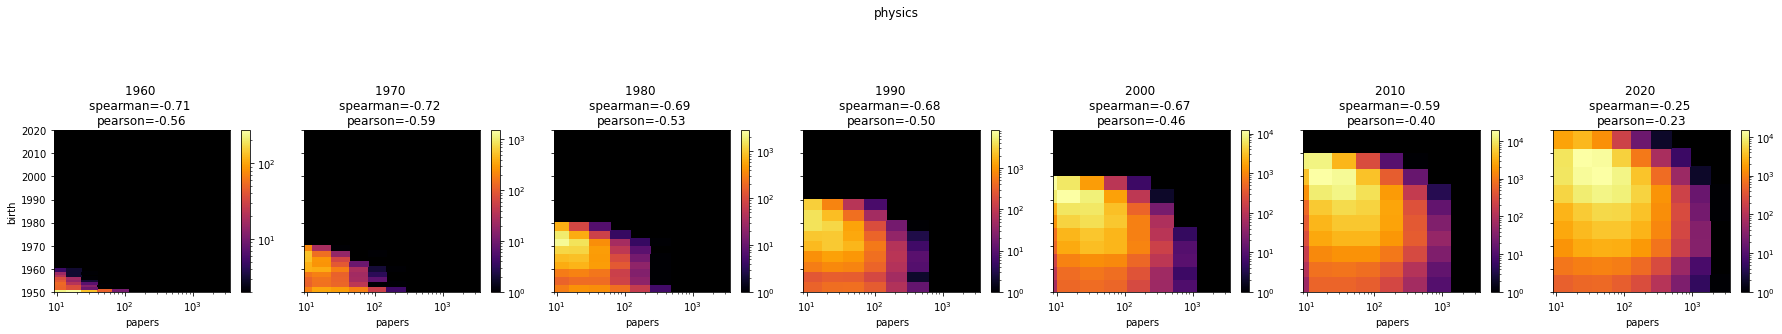

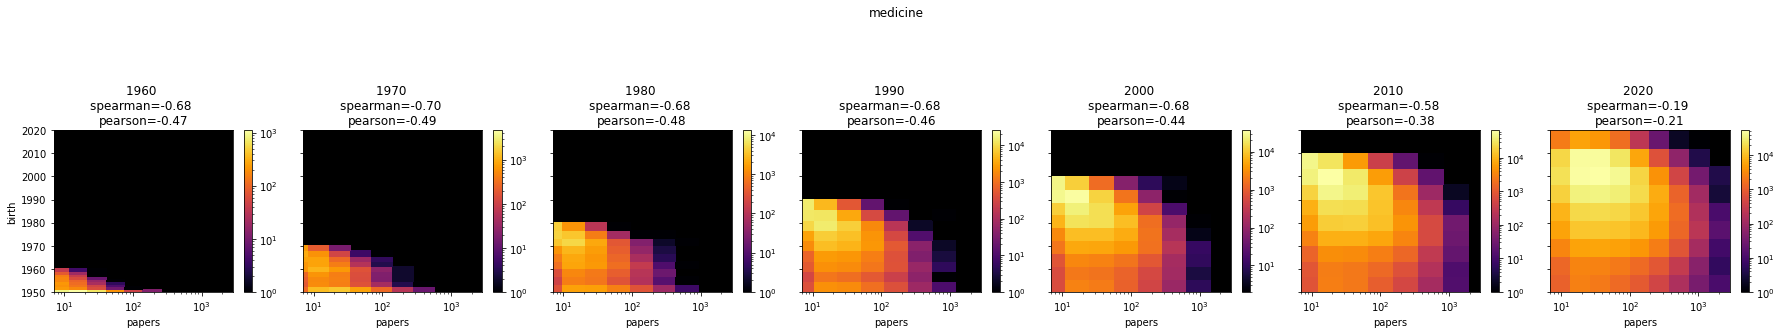

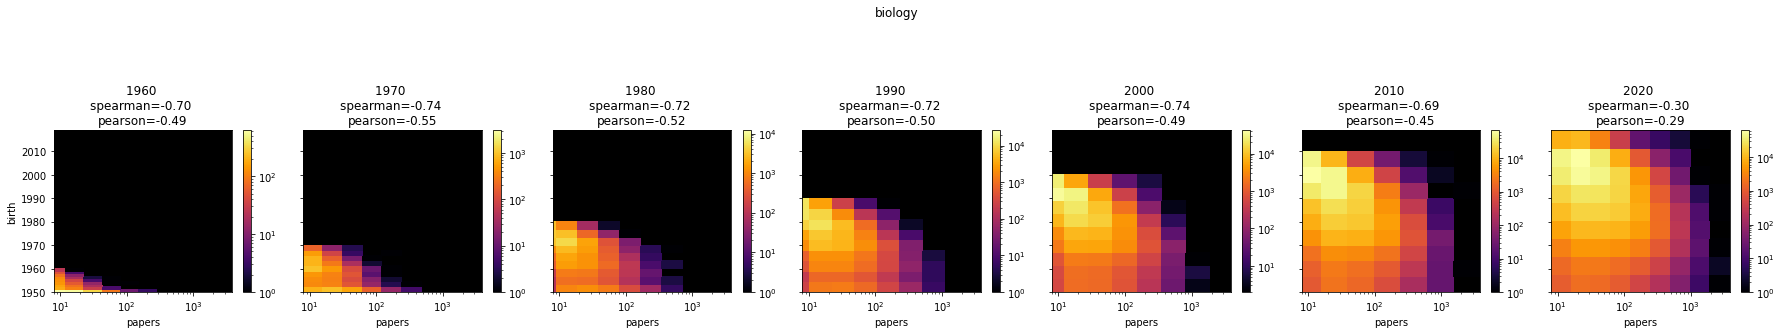

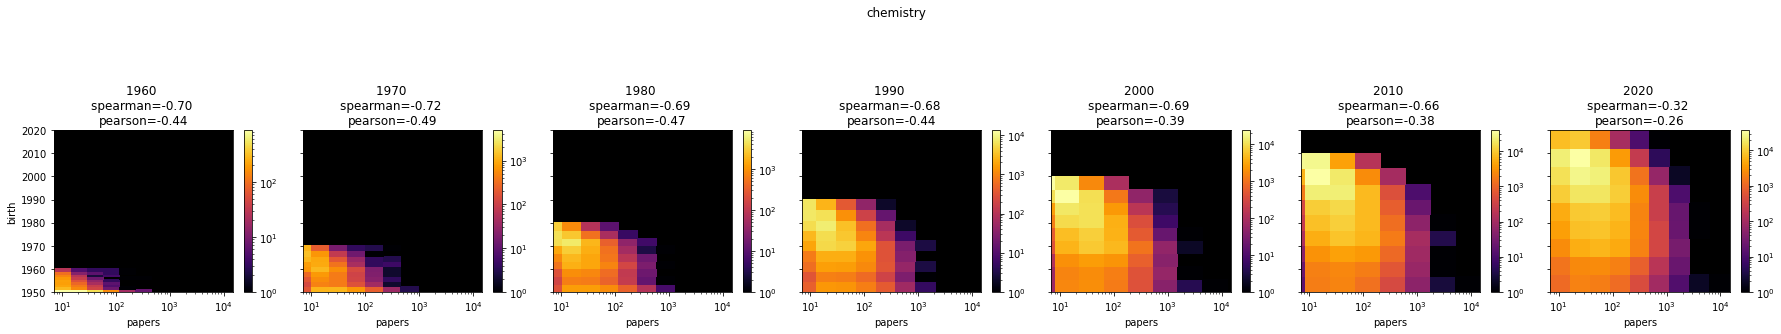

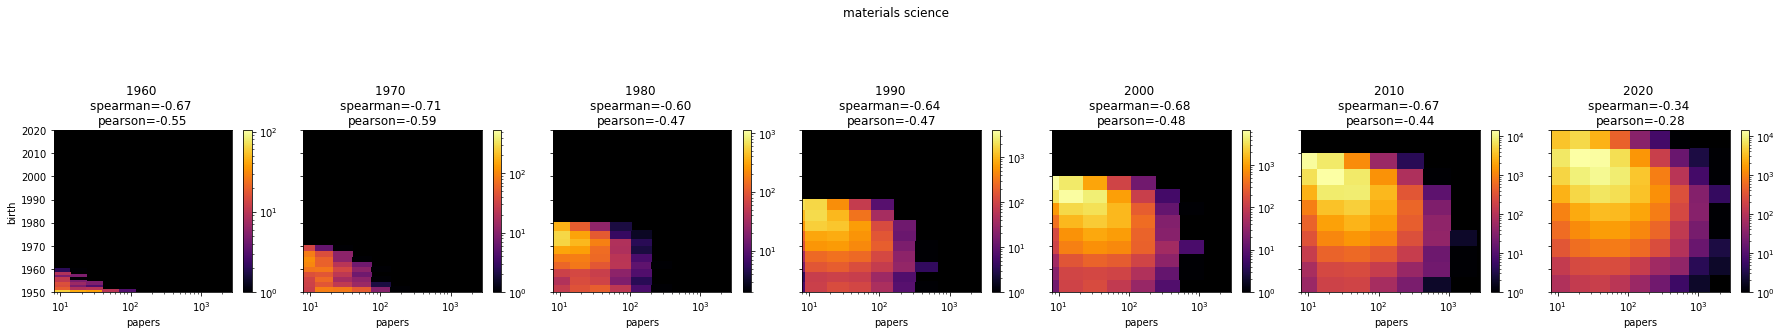

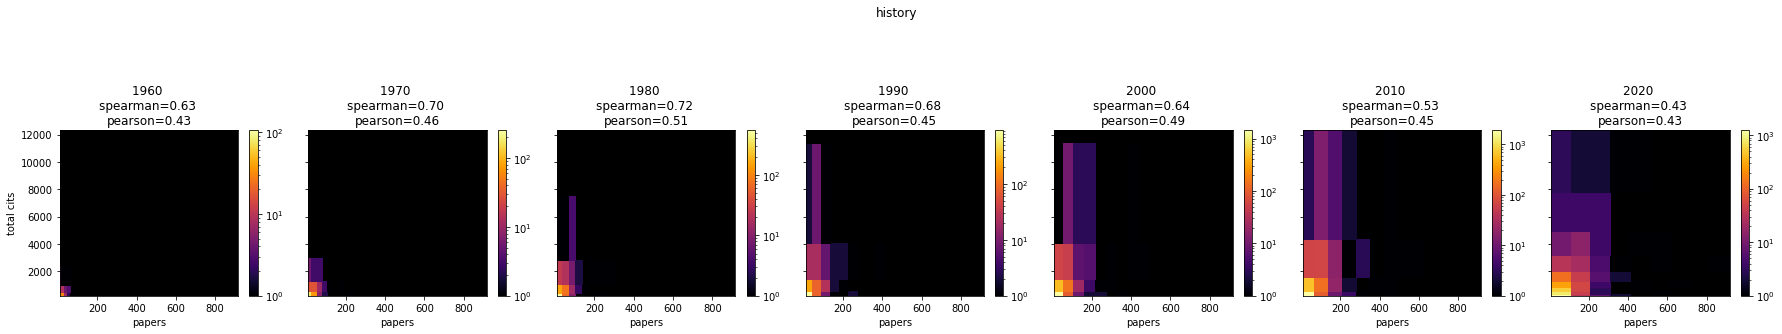

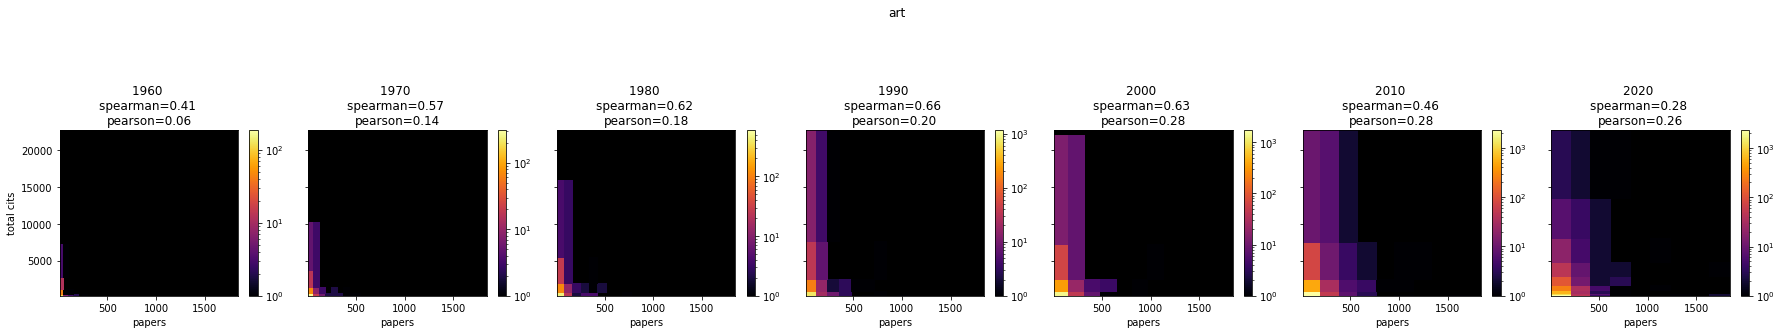

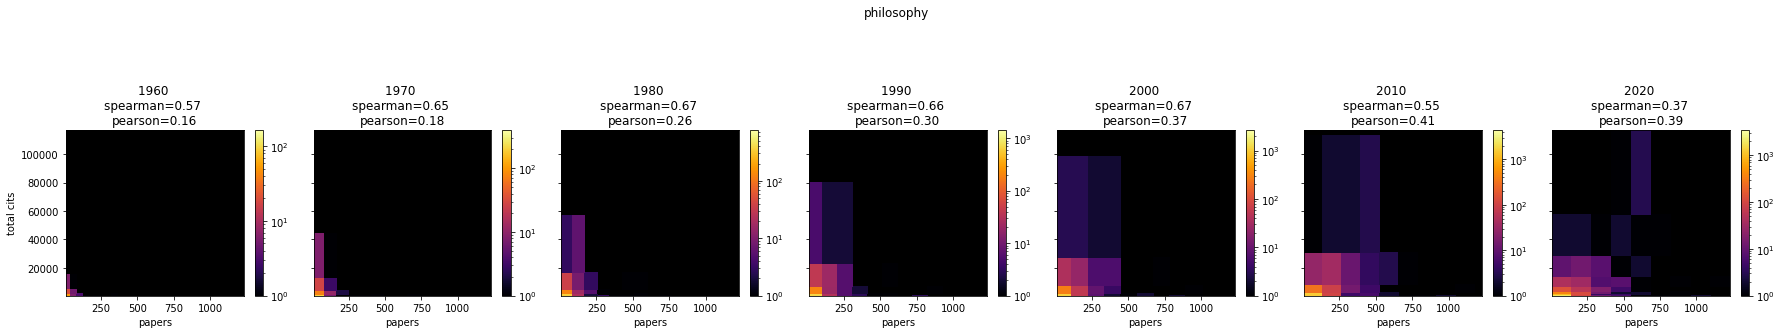

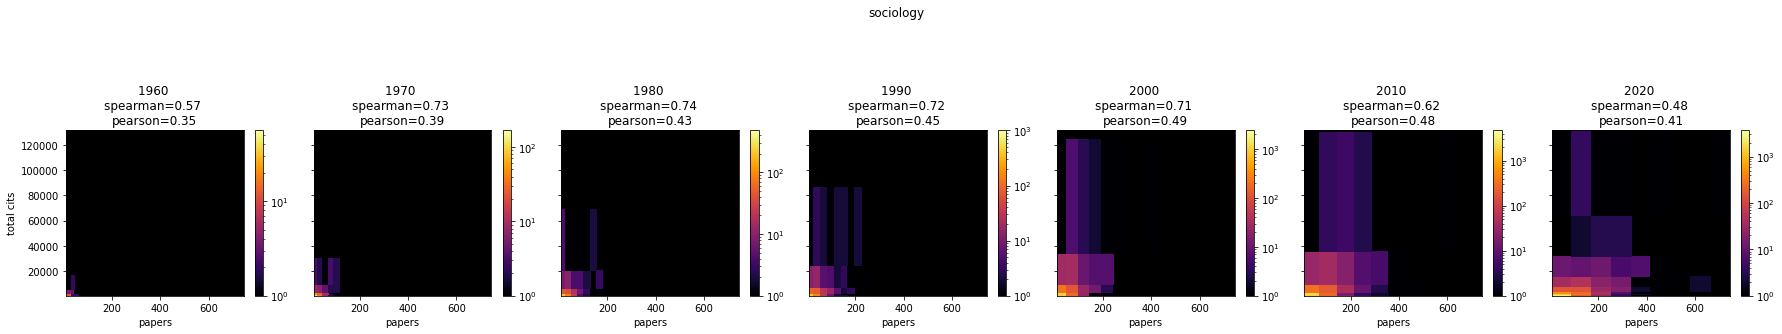

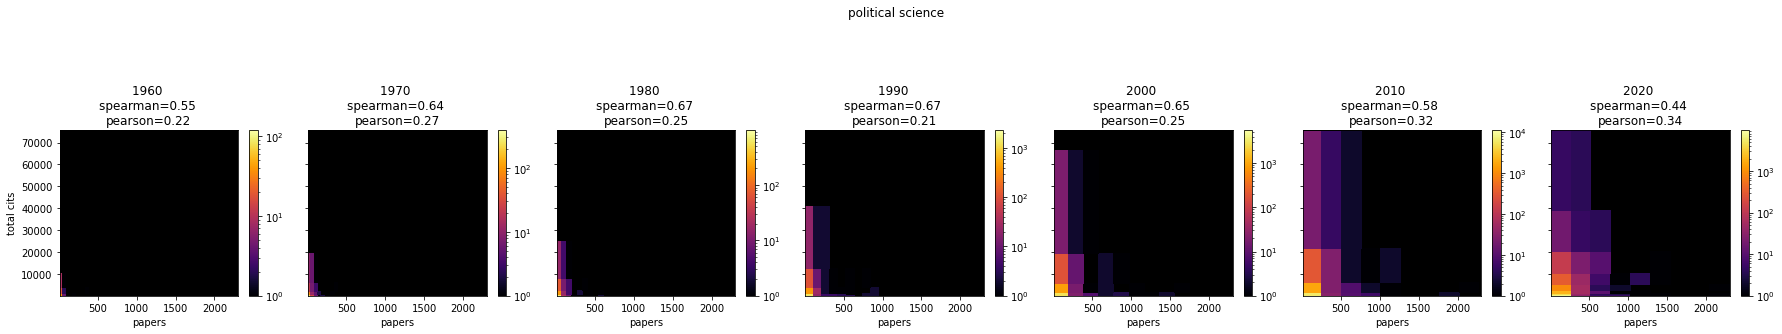

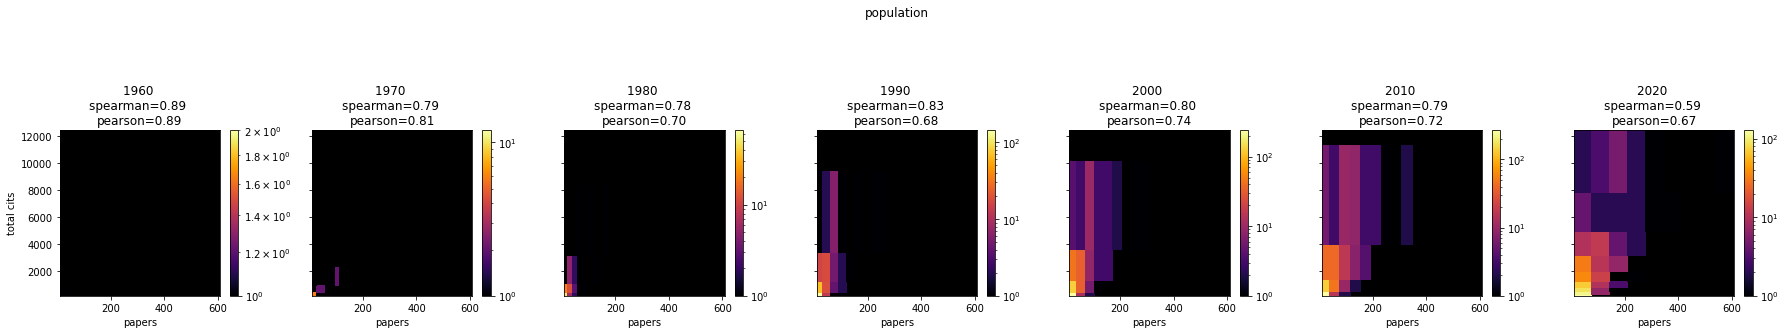

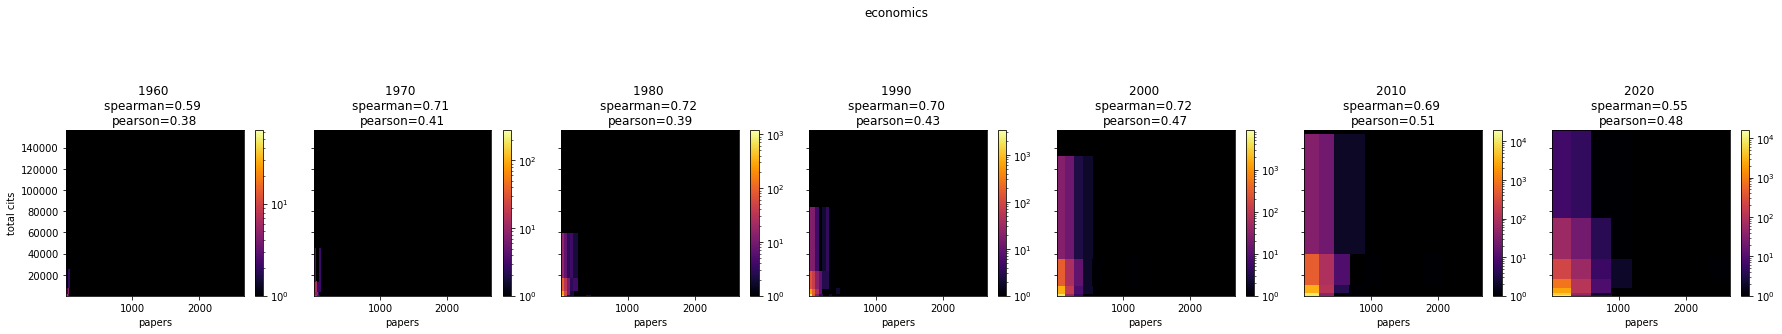

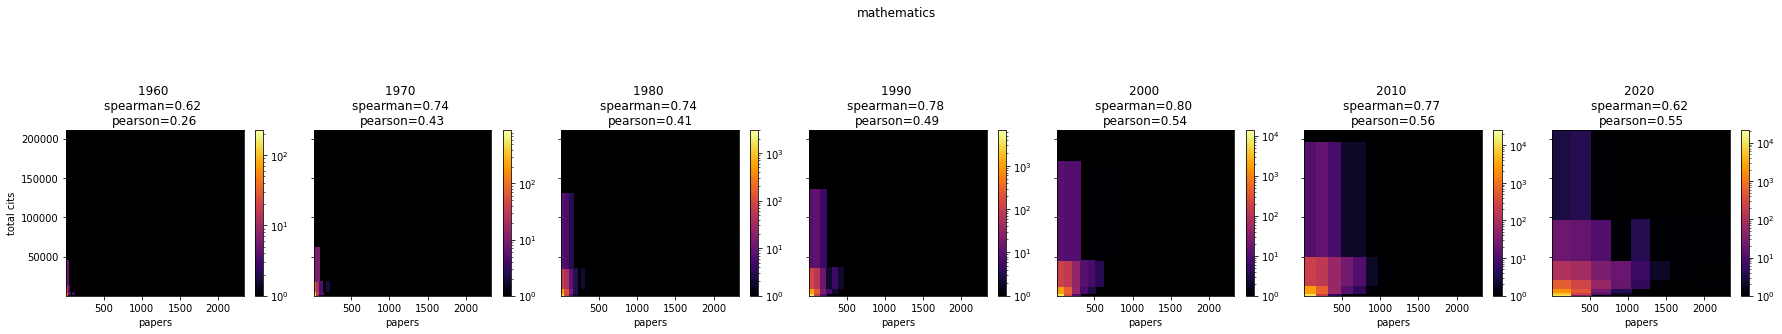

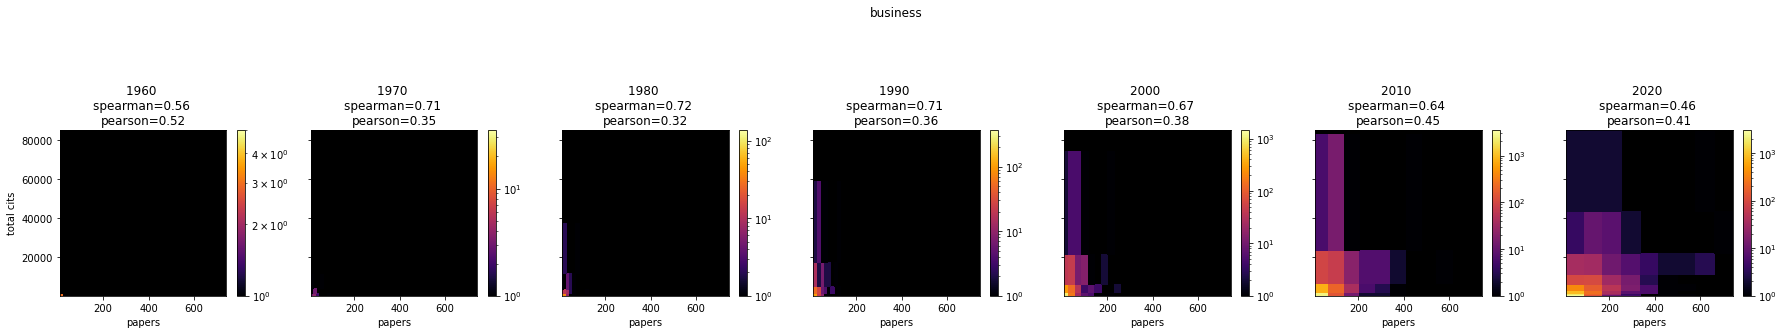

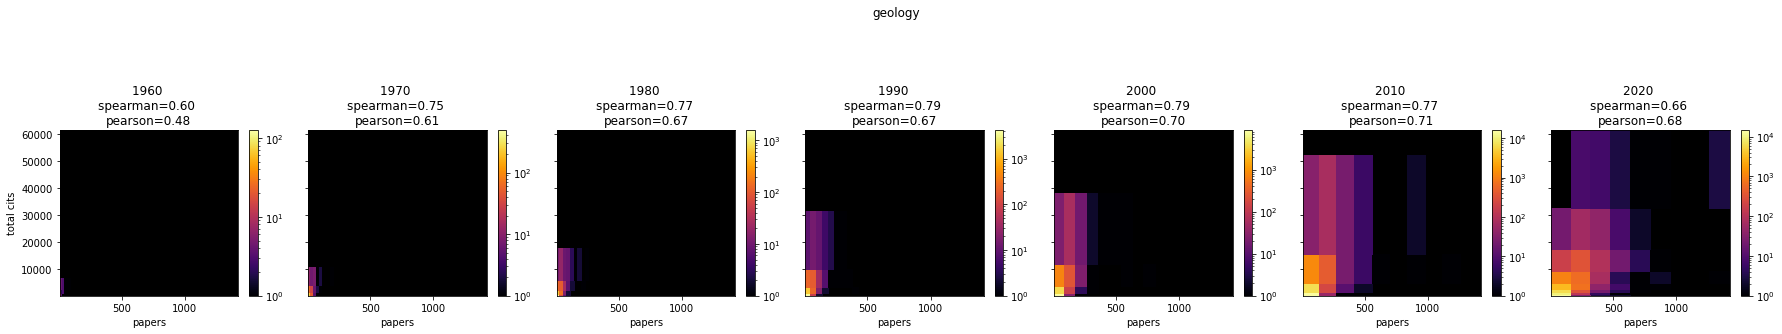

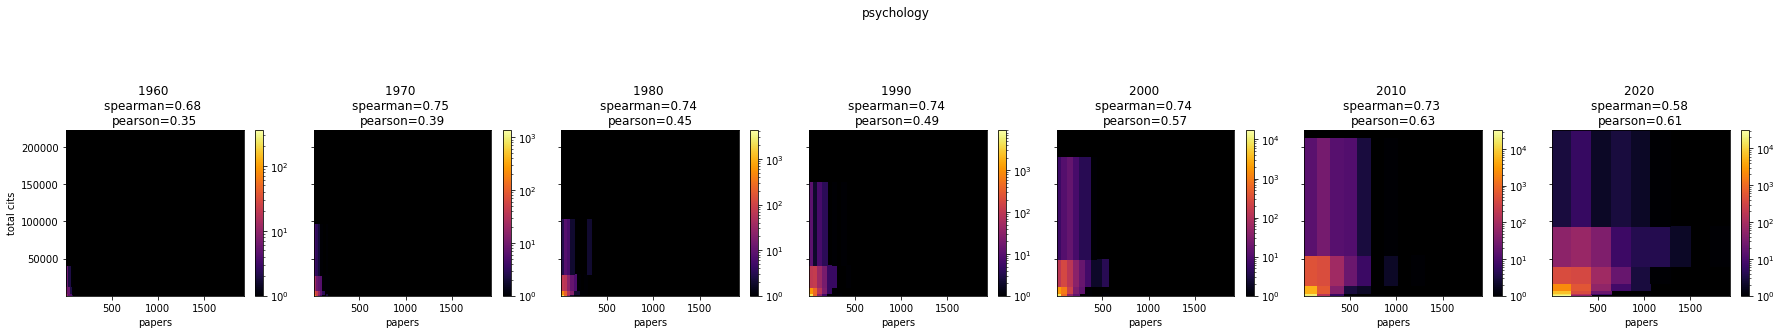

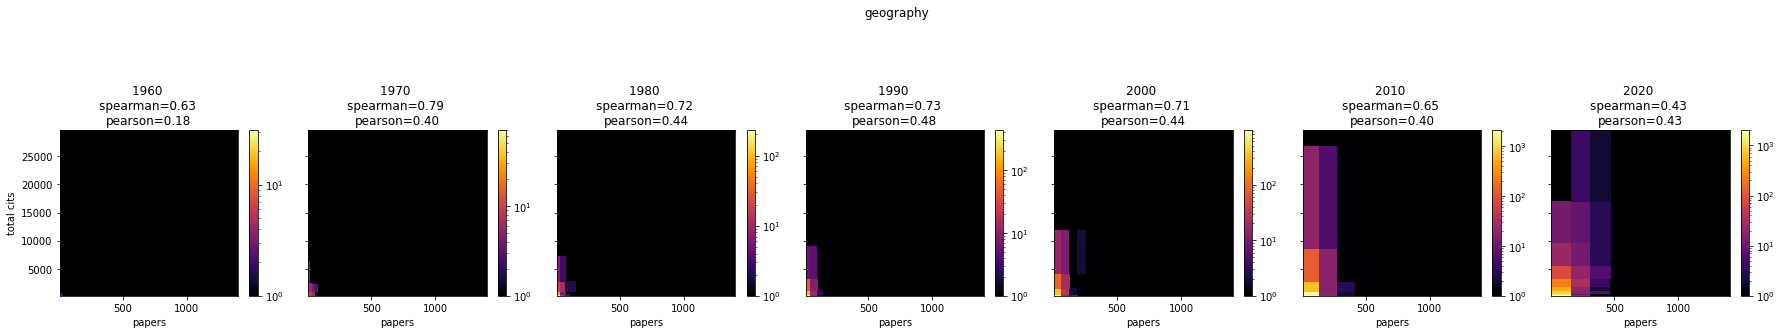

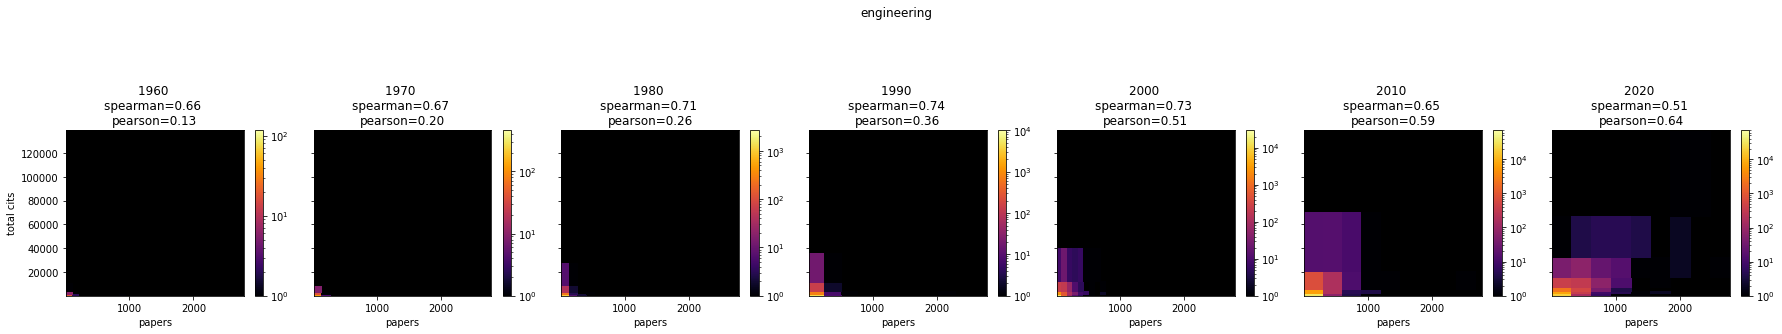

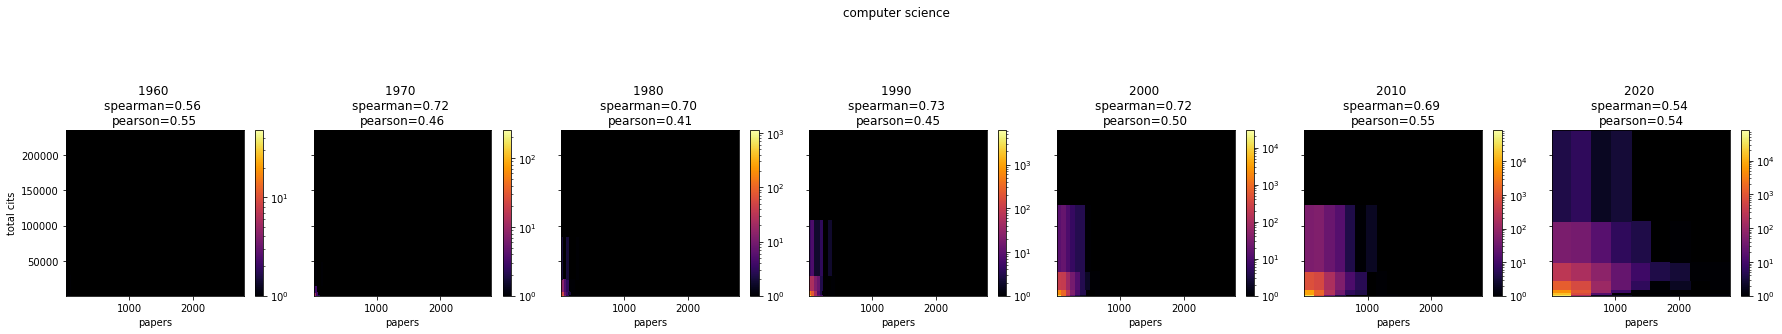

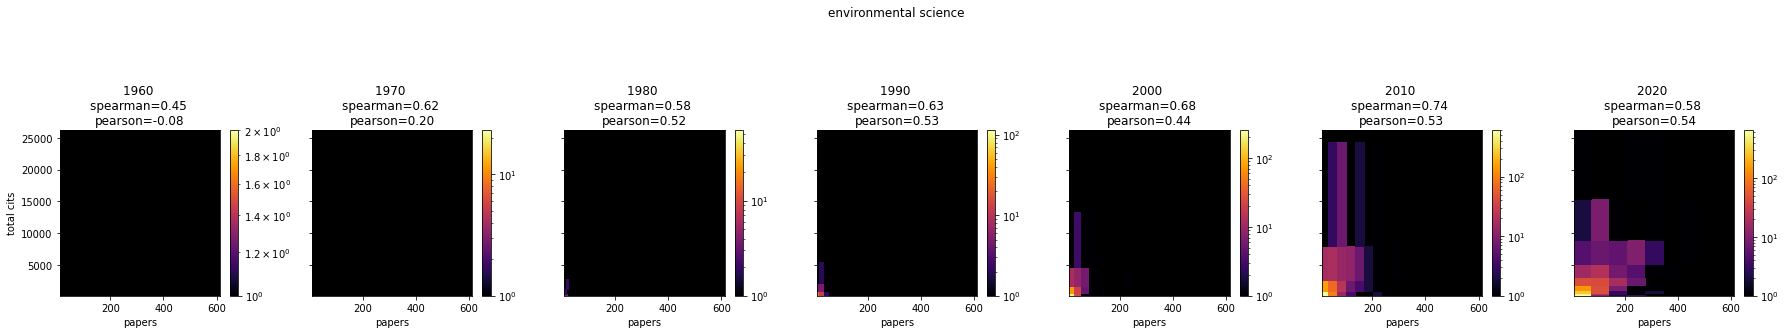

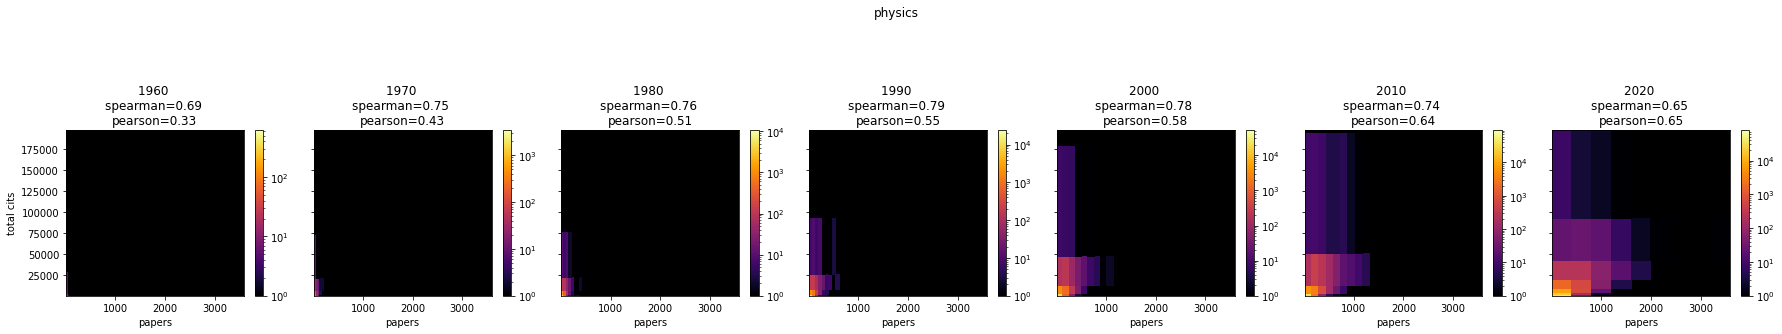

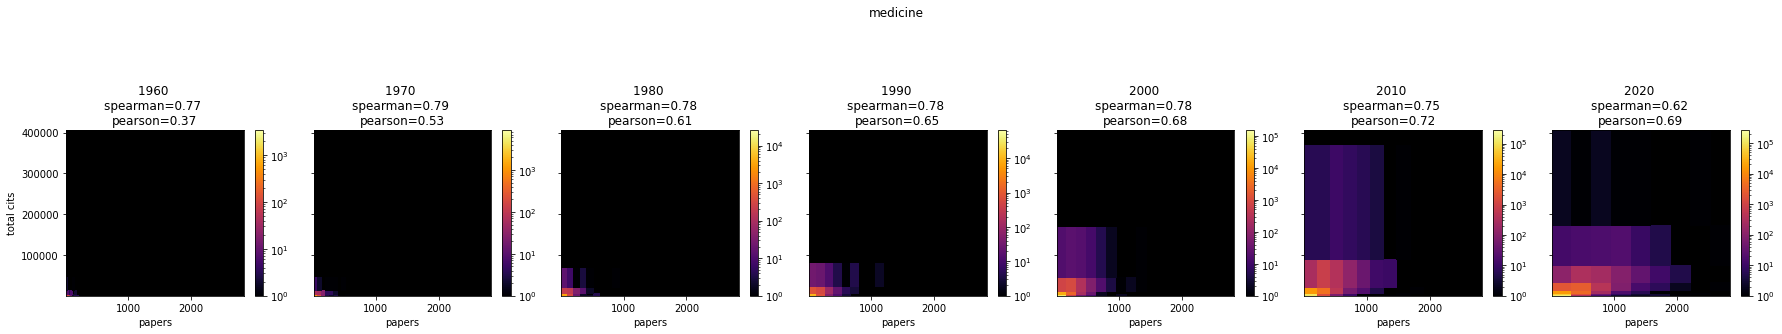

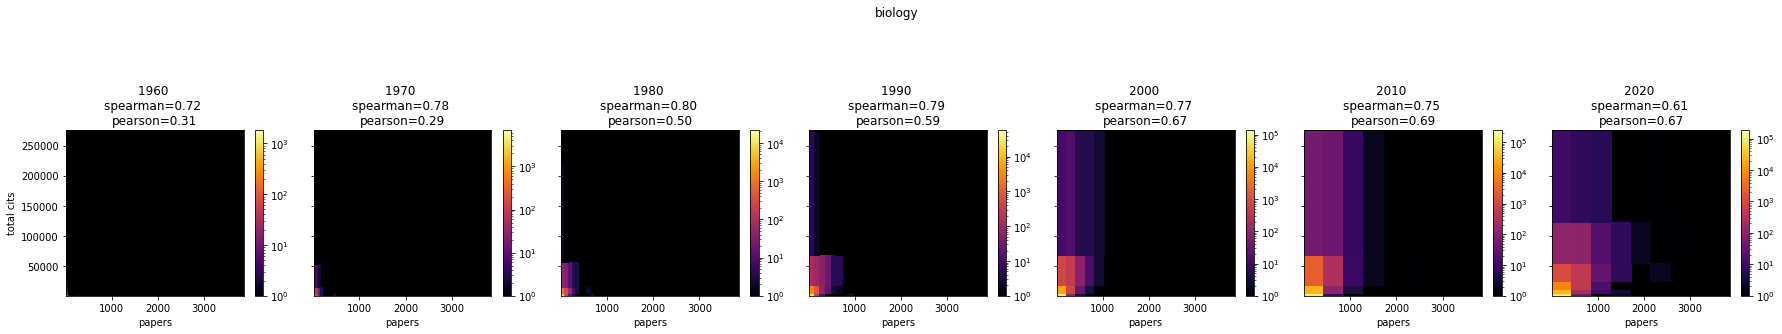

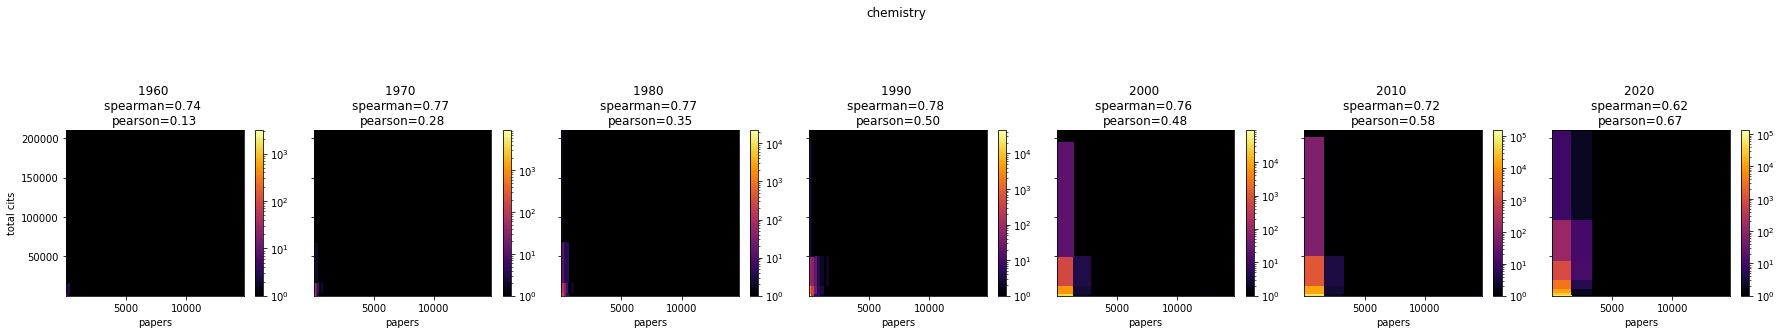

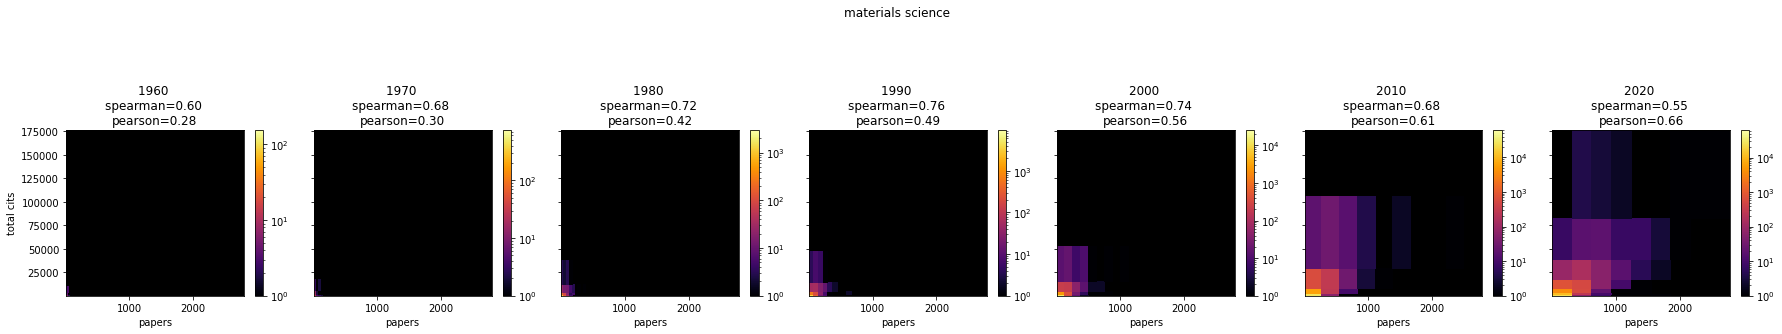

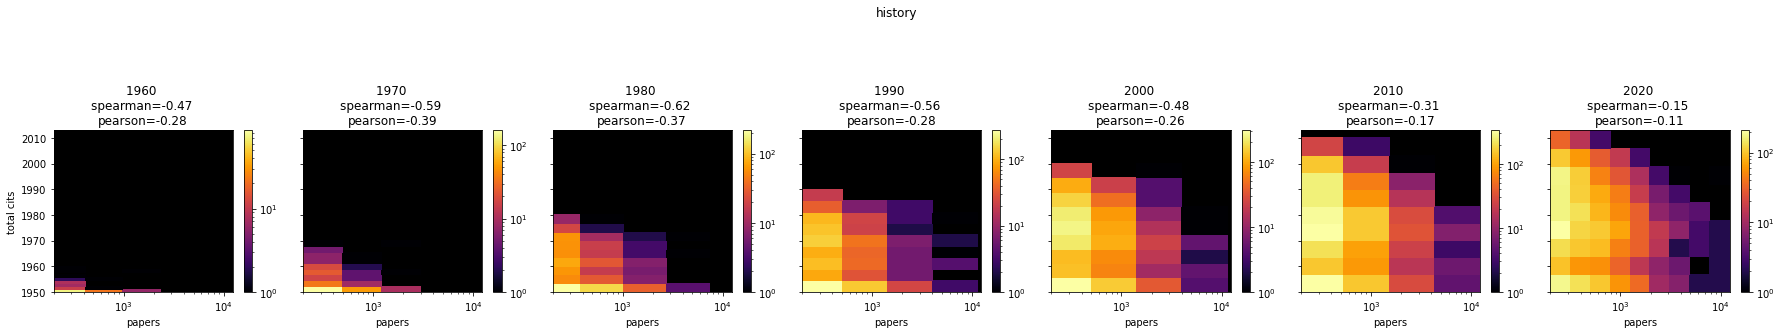

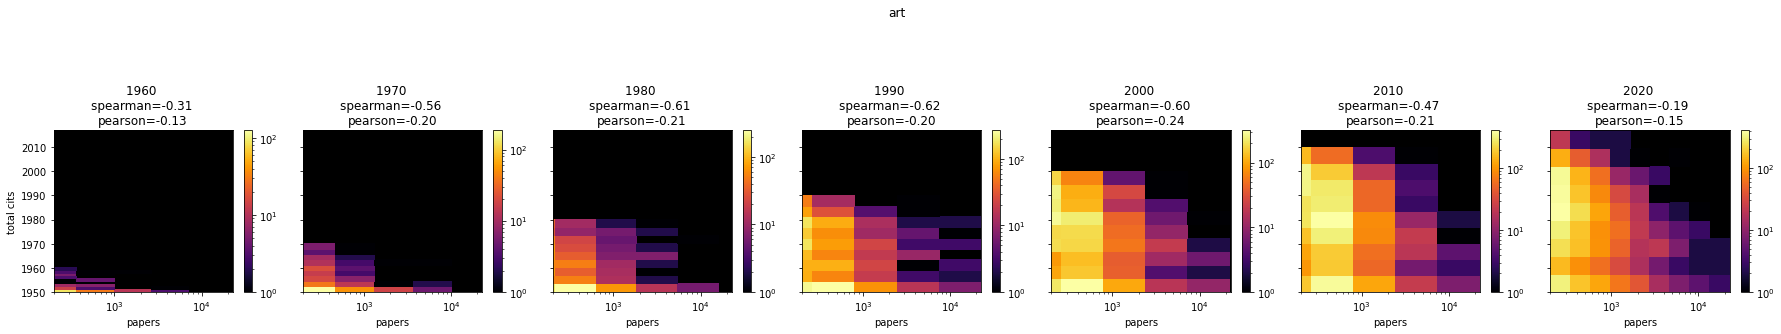

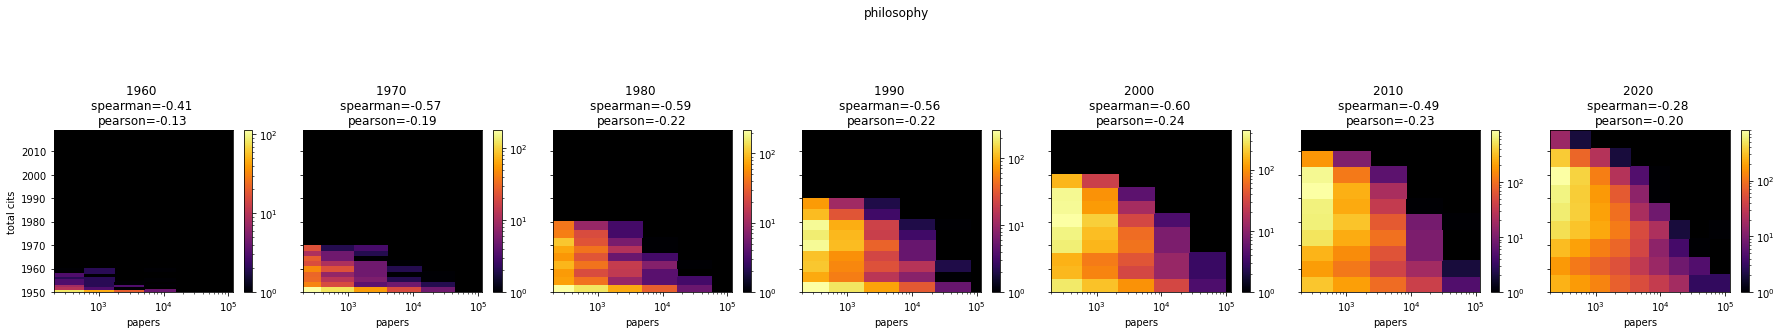

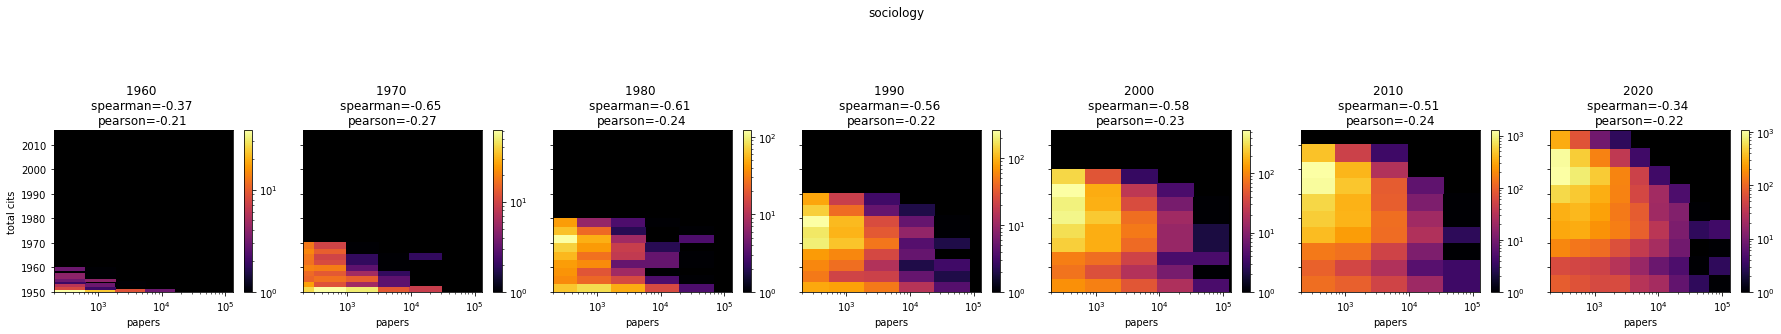

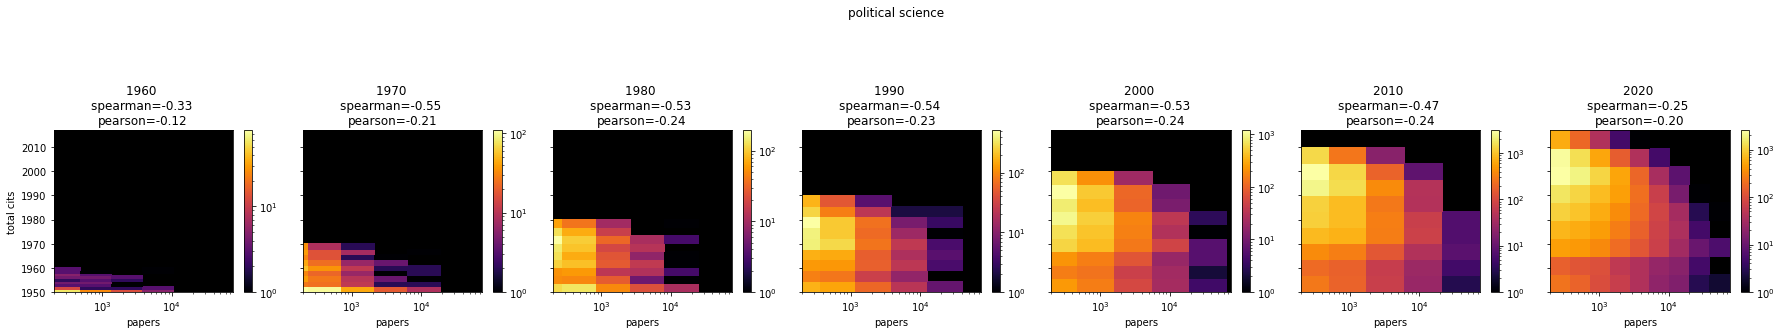

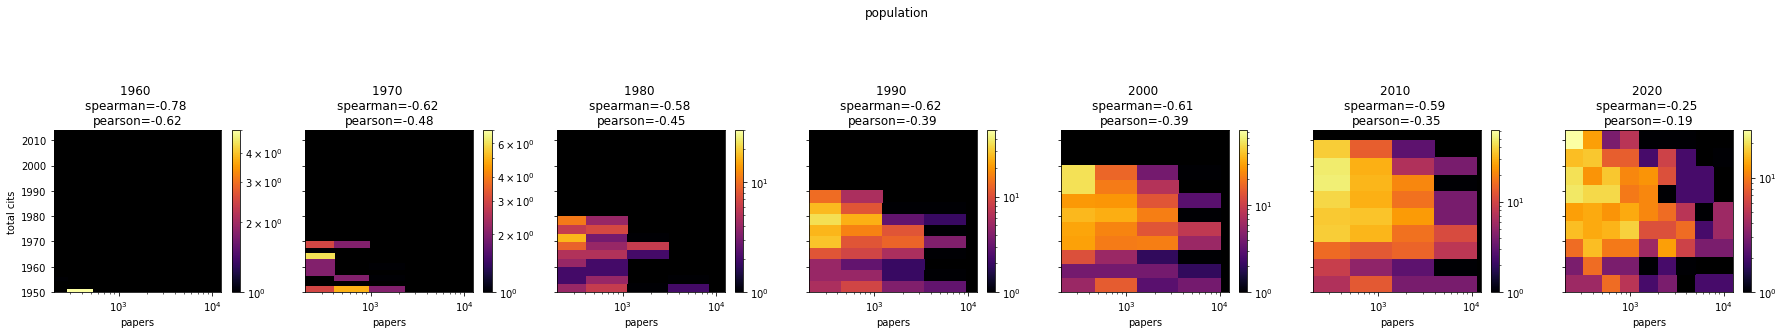

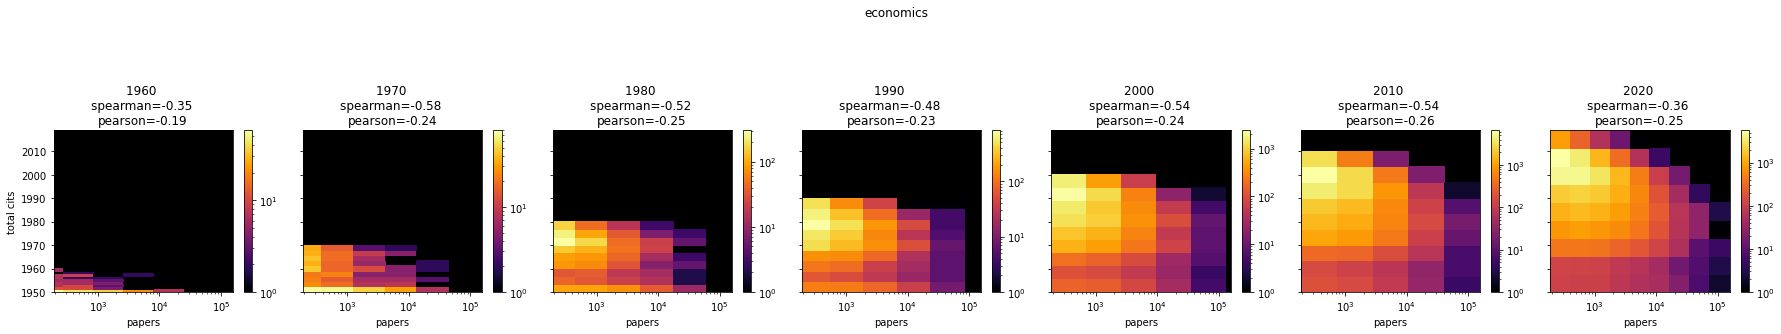

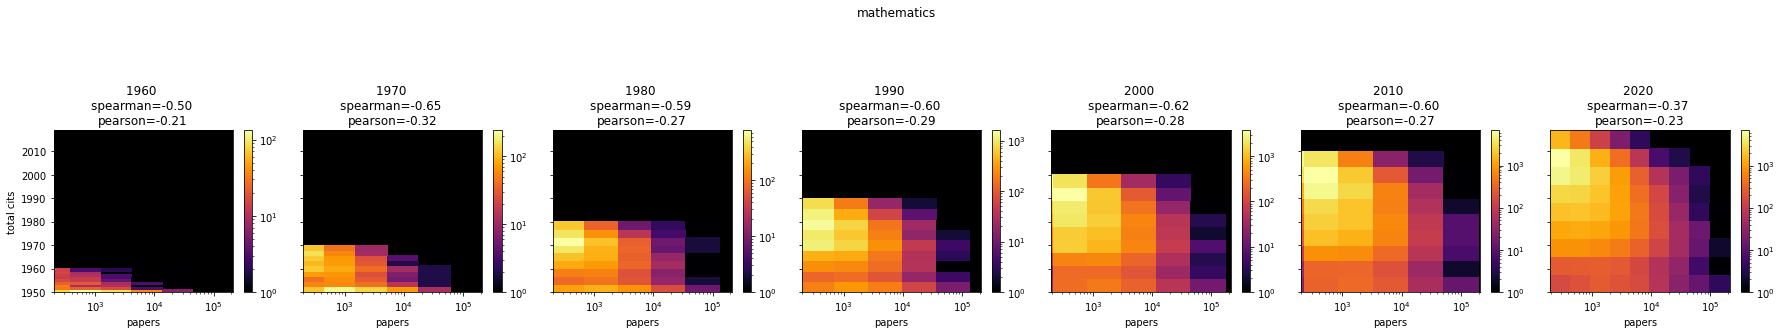

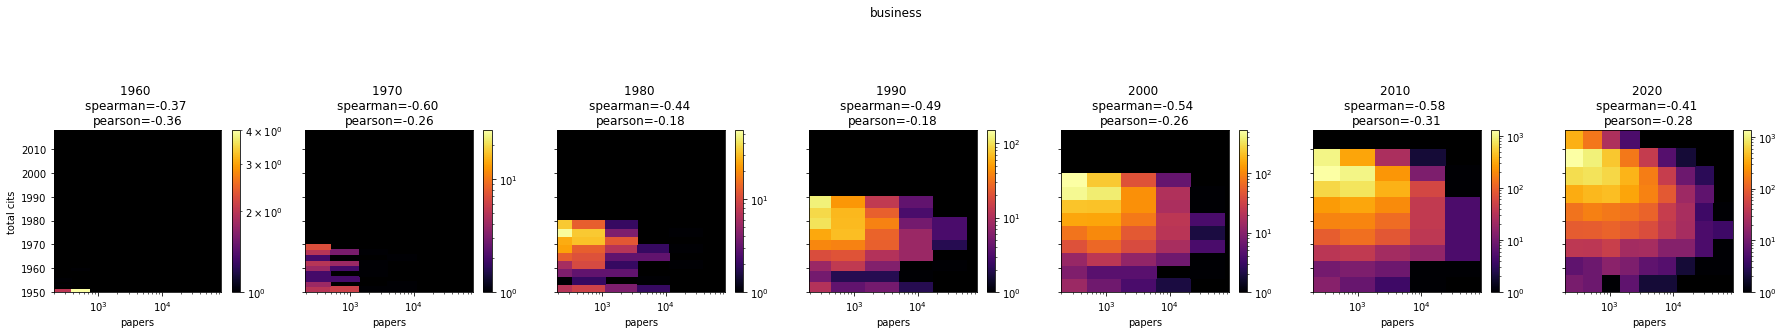

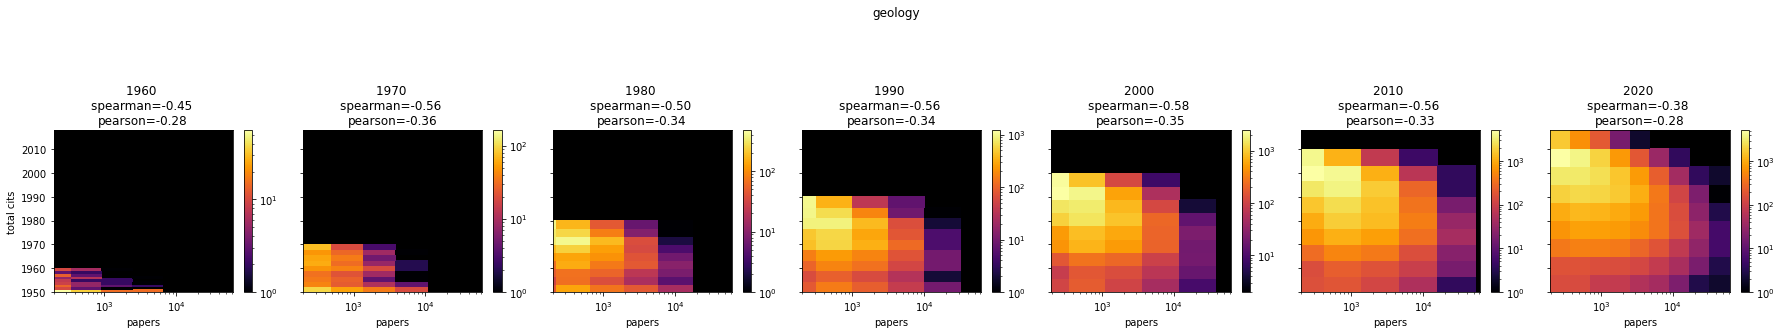

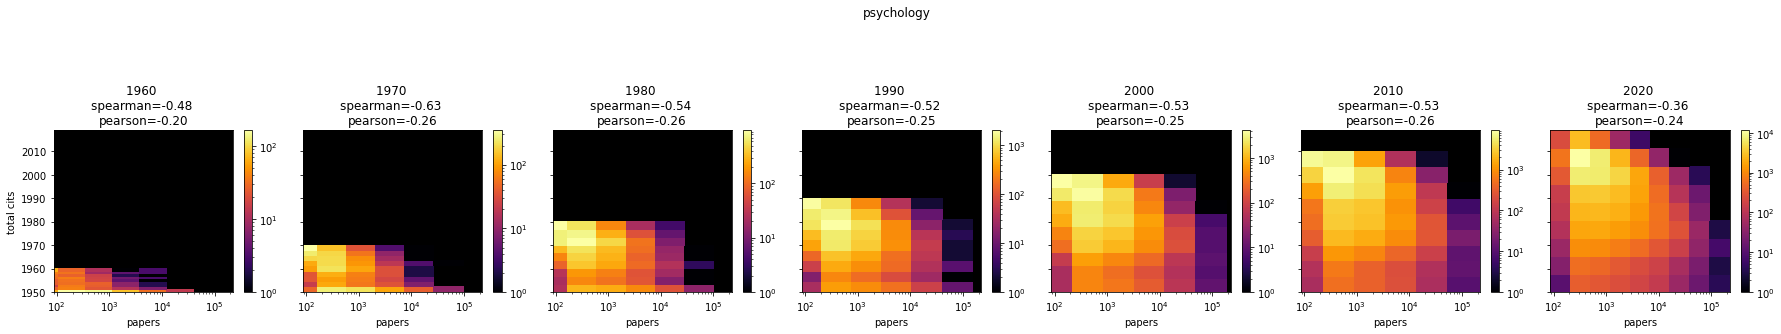

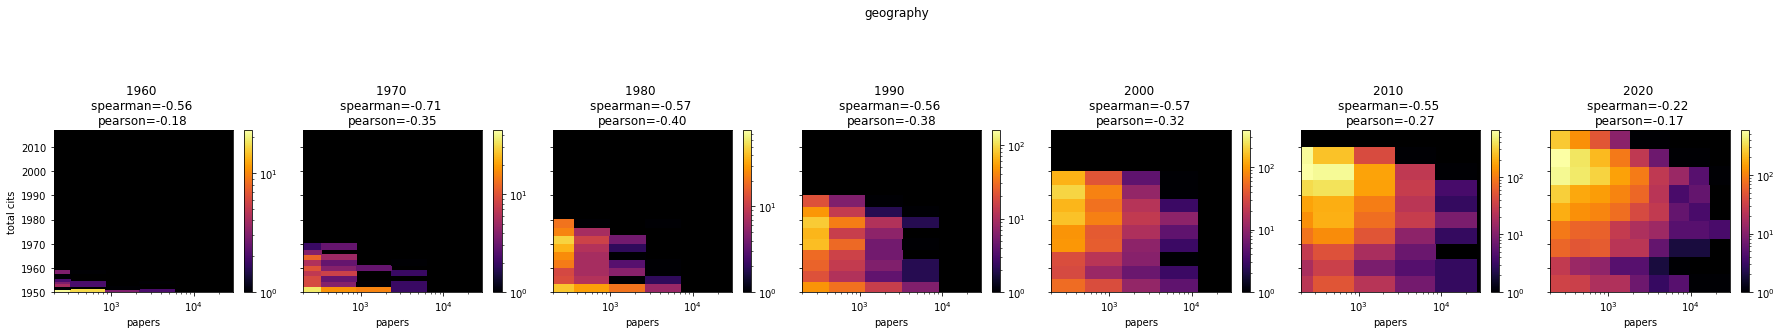

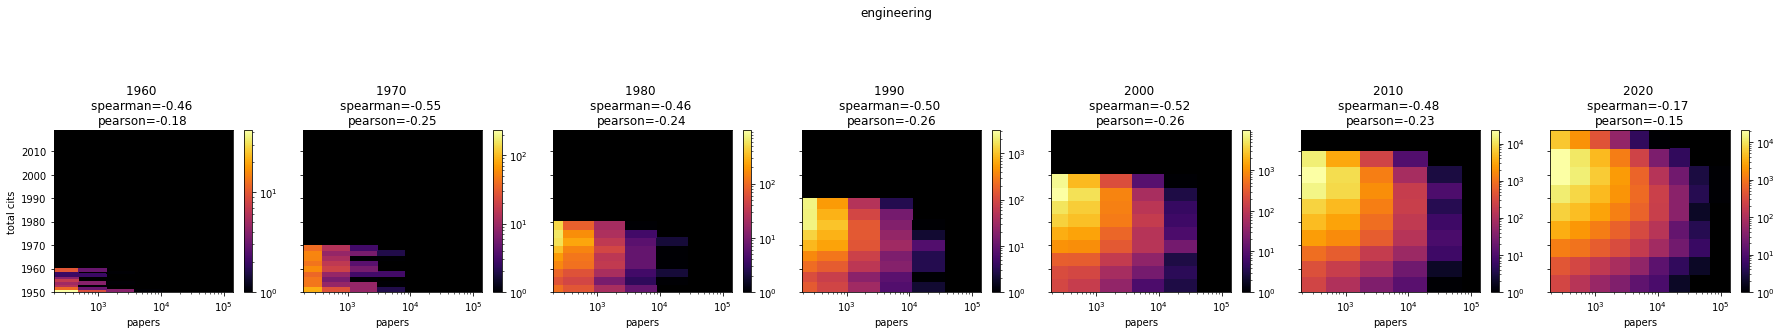

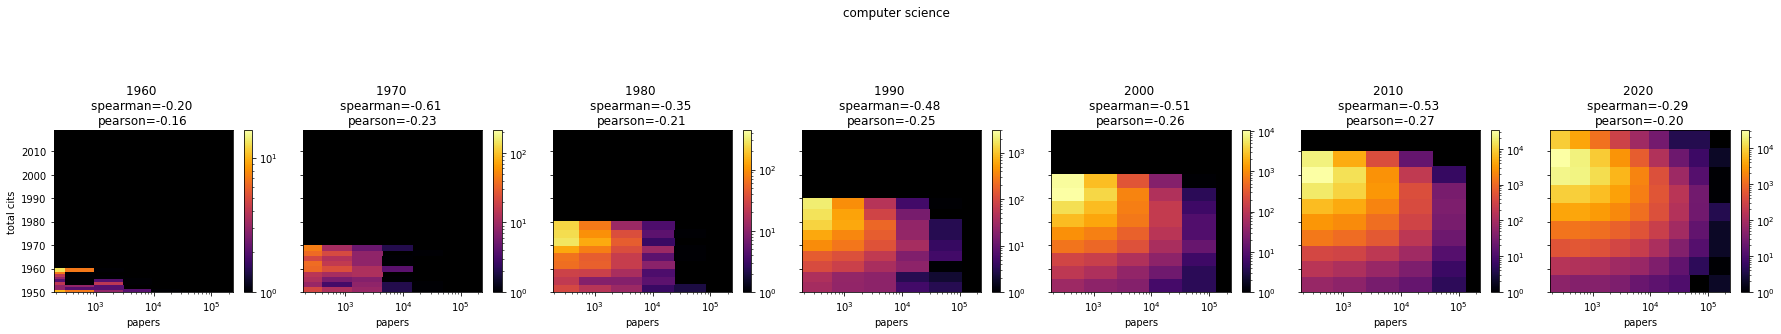

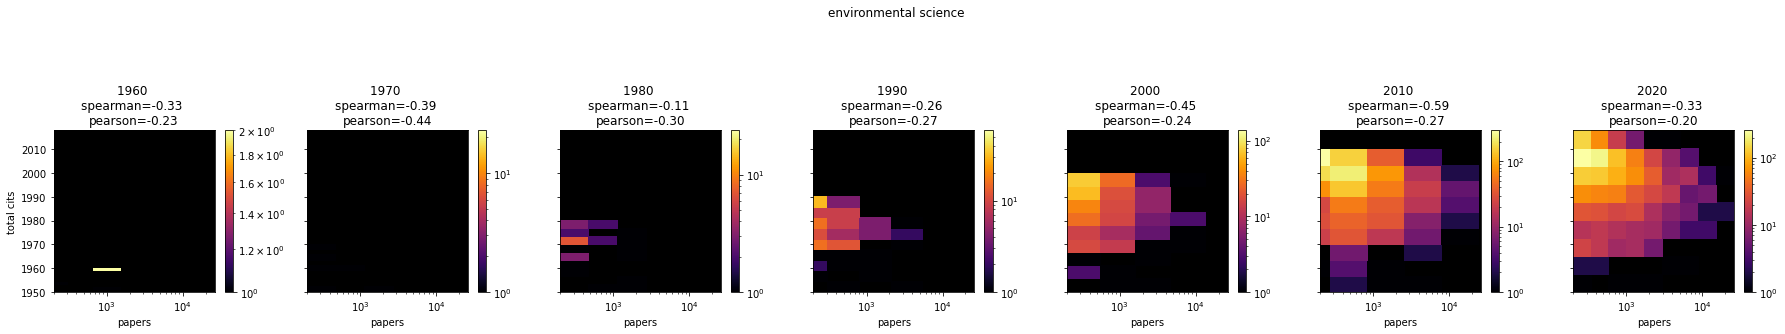

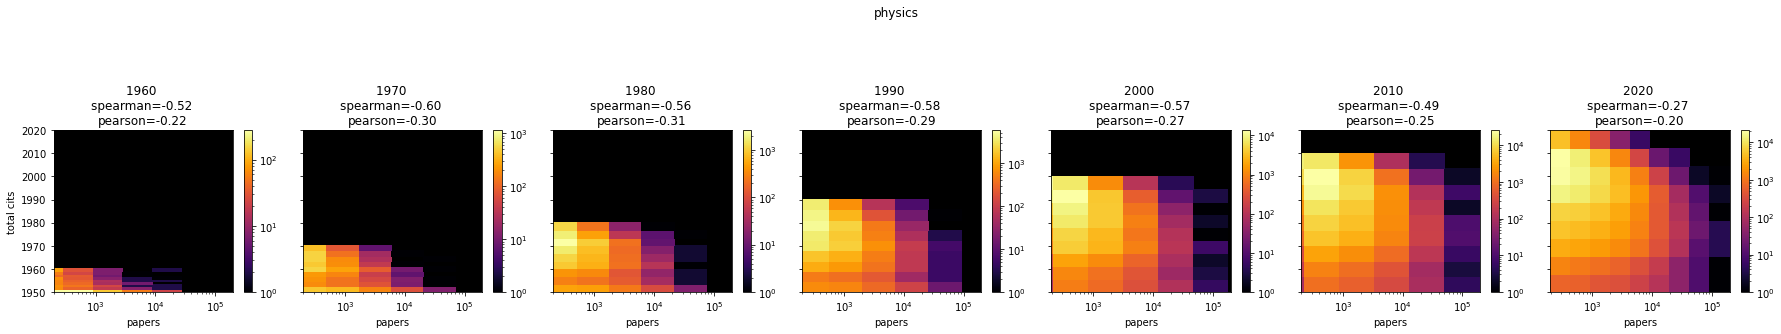

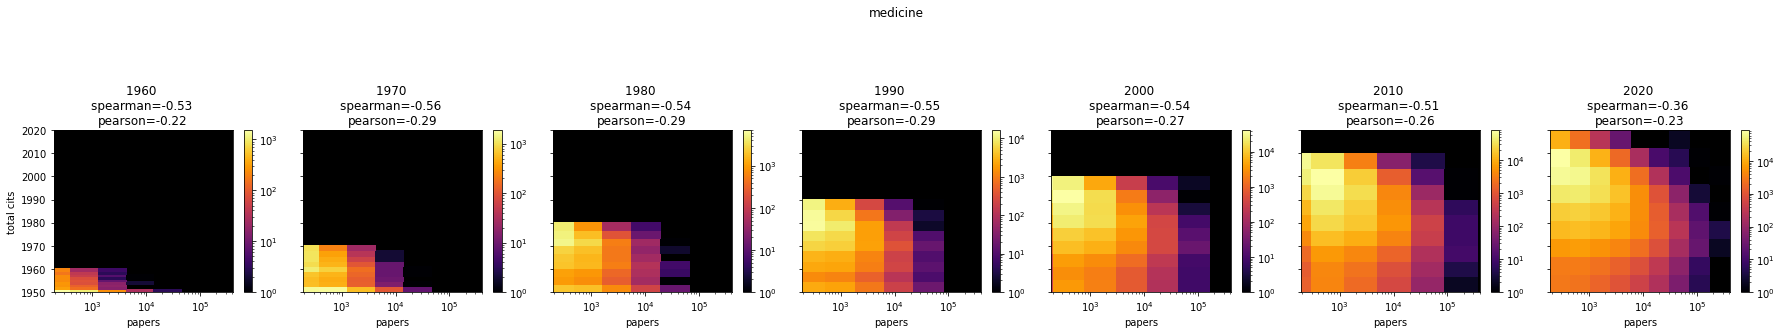

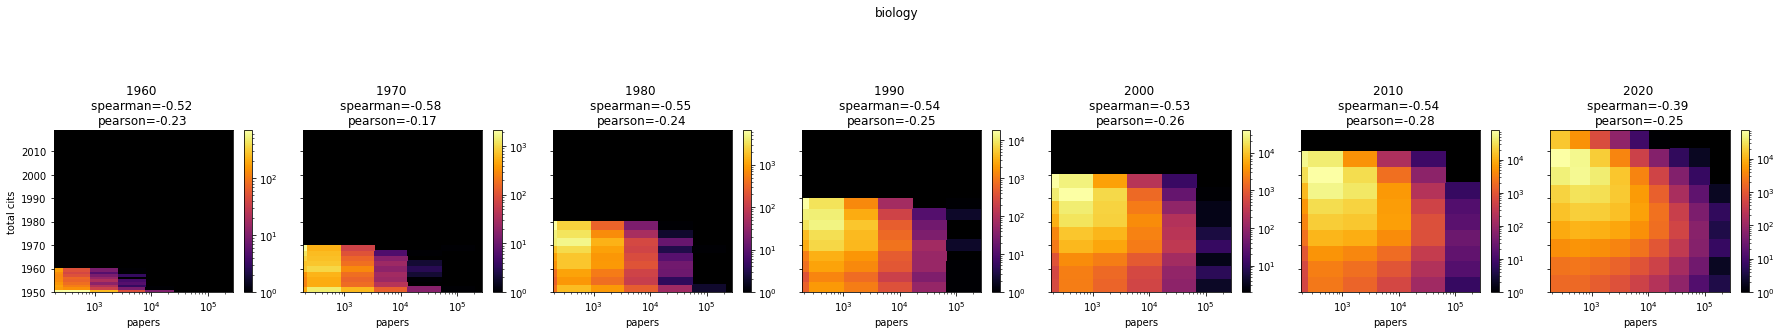

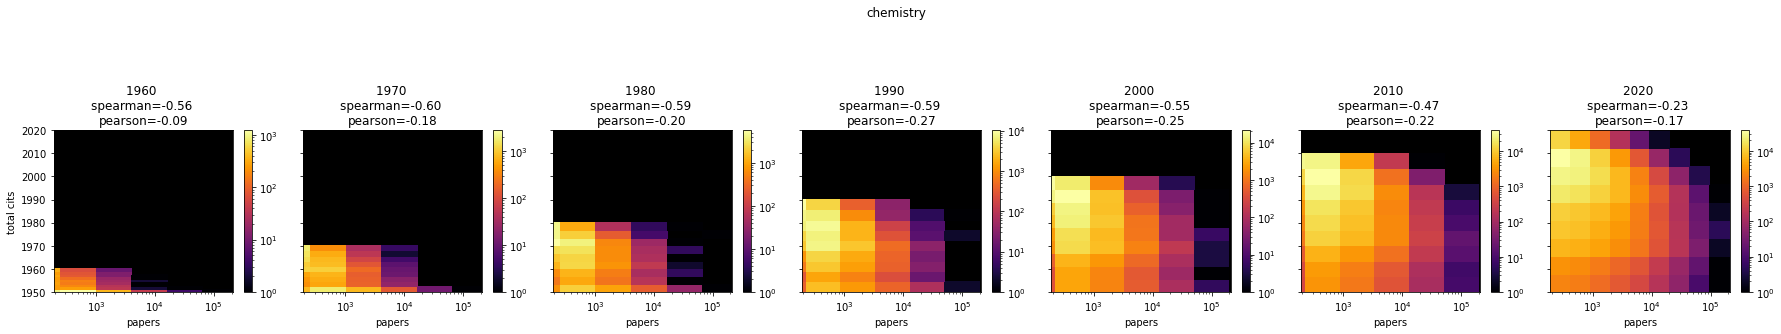

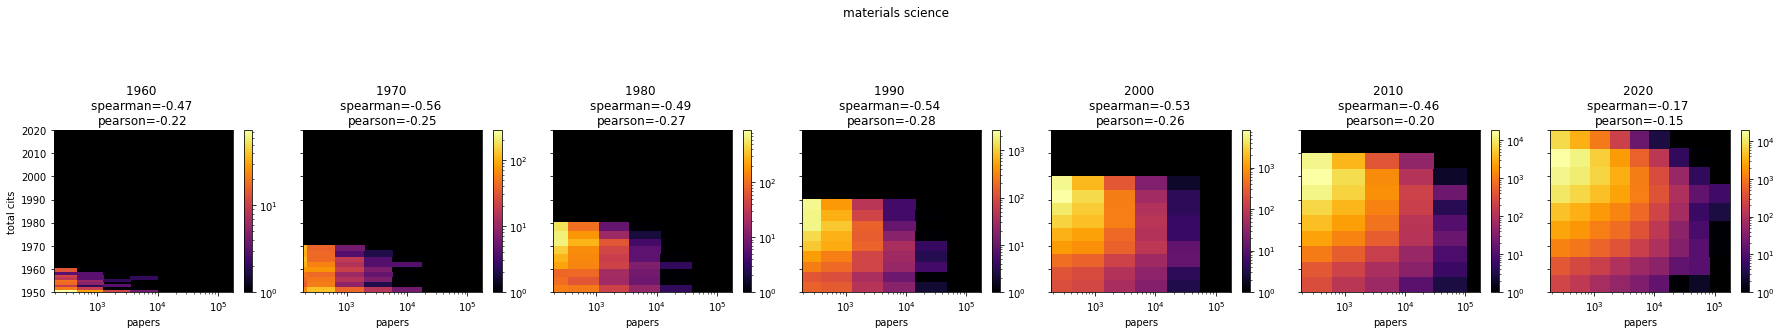

In [7]:
x_filename = 'results/papers_10a_full_%d.json'
y_filename = 'results/ws_10a_full_%d.json'
name = 'papers_ws'
xlabel = 'papers'
ylabel = 'max ws'
xscale = 'log'
hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale)

x_filename = 'results/birth_10a_full_%d.json'
y_filename = 'results/ws_10a_full_%d.json'
name = 'birth_ws'
xlabel = 'birth year'
ylabel = 'max ws'
xscale = 'linear'
hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale)

x_filename = 'results/papers_10a_full_%d.json'
y_filename = 'results/birth_10a_full_%d.json'
name = 'papers_ws'
xlabel = 'papers'
ylabel = 'birth'
xscale = 'log'
hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale)

x_filename = 'results/papers_10a_full_%d.json'
y_filename = 'results/cits_10a_full_%d.json'
name = 'papers_cits'
xlabel = 'papers'
ylabel = 'total cits'
xscale = 'linear'
yscale = 'log'
hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale, yscale)

x_filename = 'results/cits_10a_full_%d.json'
y_filename = 'results/birth_10a_full_%d.json'
name = 'cits_birth'
xlabel = 'papers'
ylabel = 'total cits'
xscale = 'log'
yscale = 'linear'
hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale, yscale)

### Impact of the top collaborator

/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

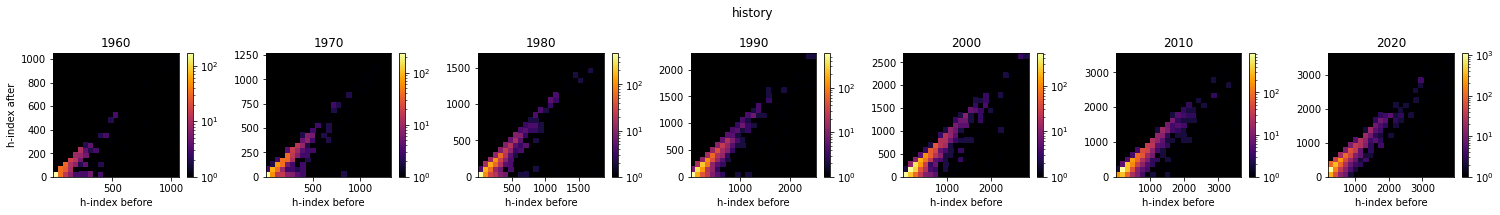

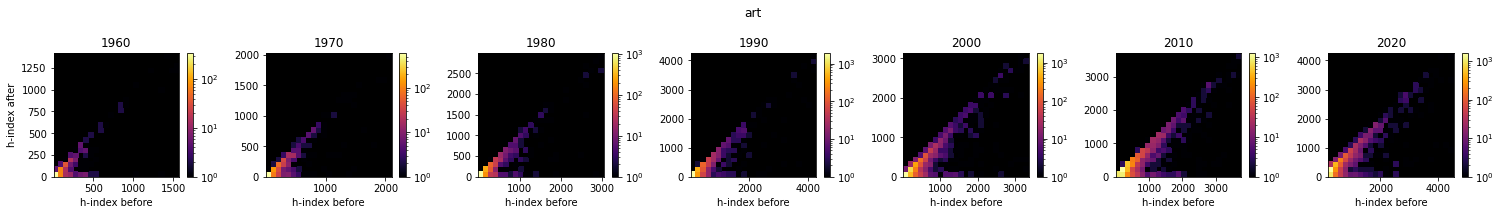

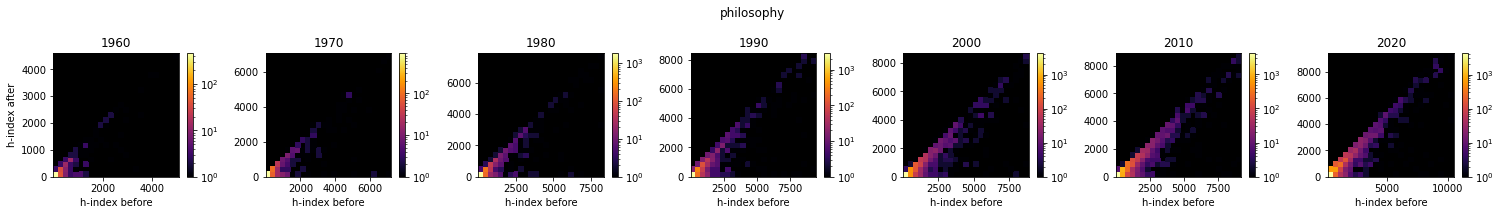

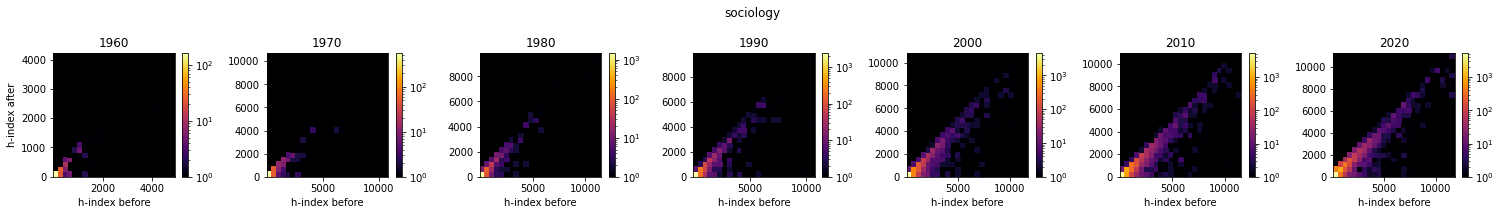

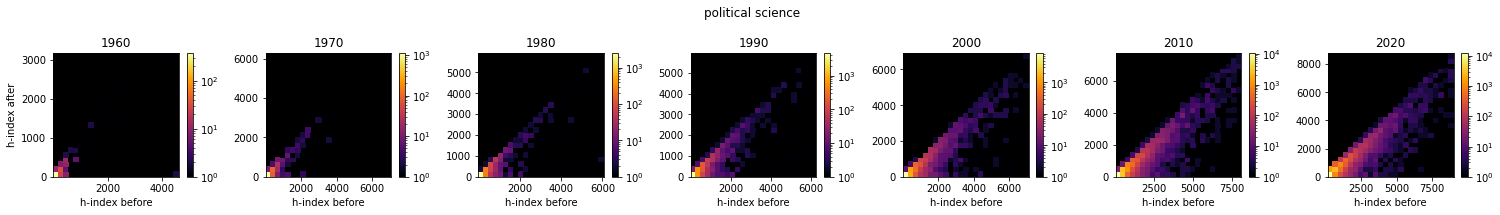

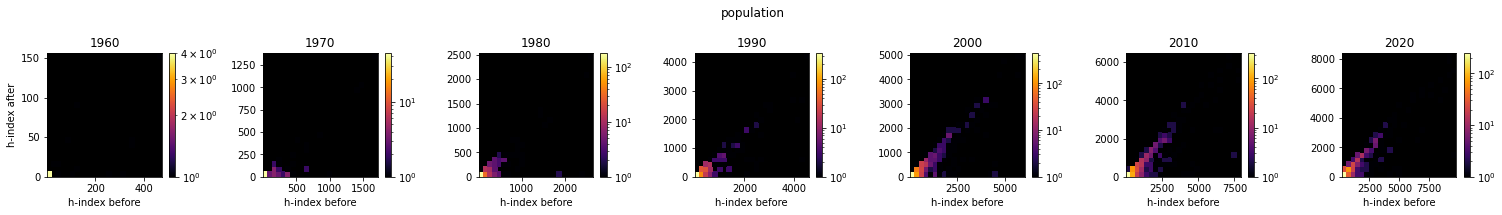

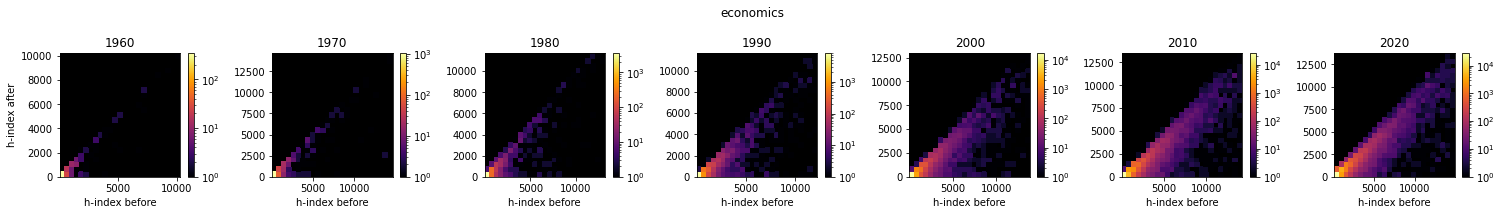

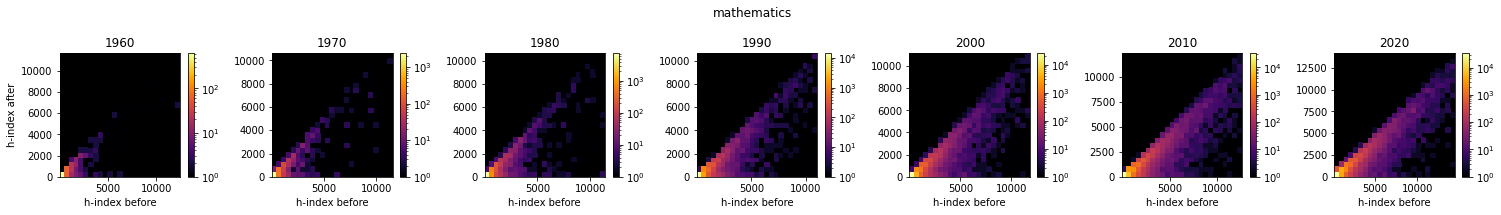

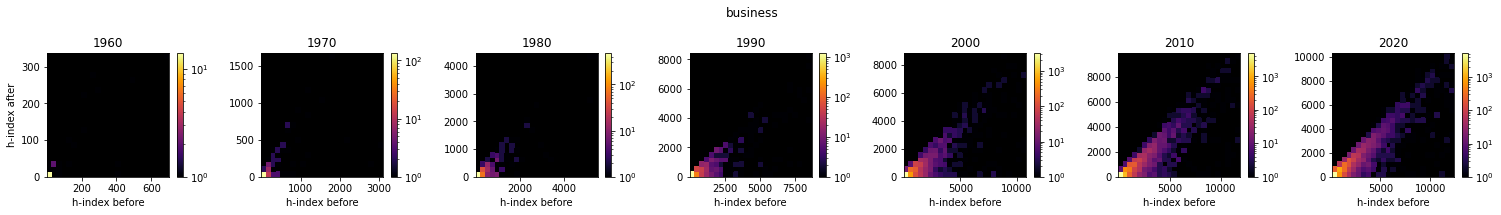

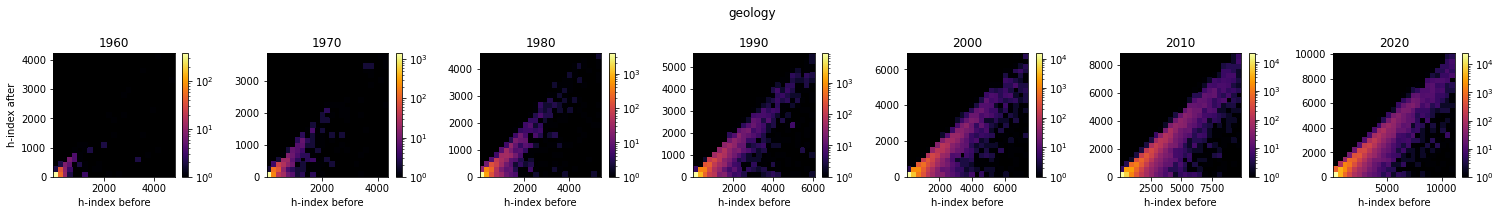

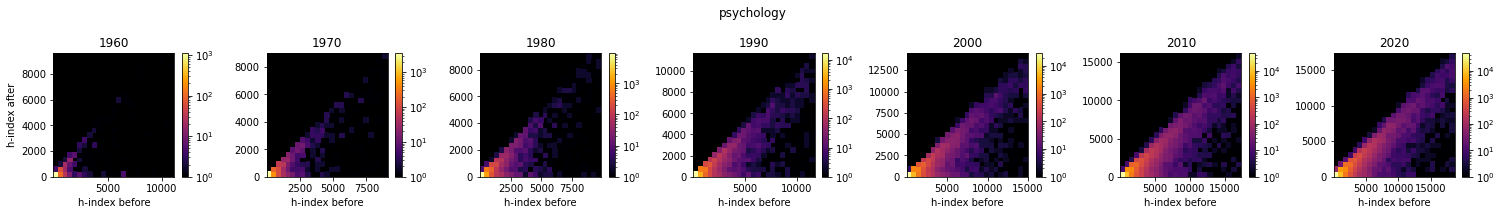

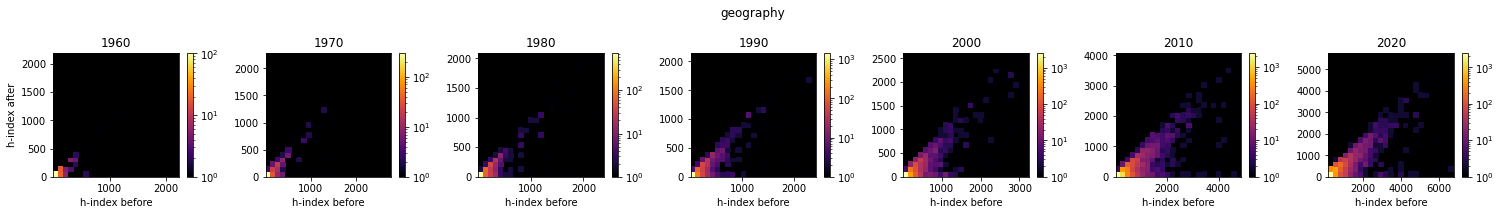

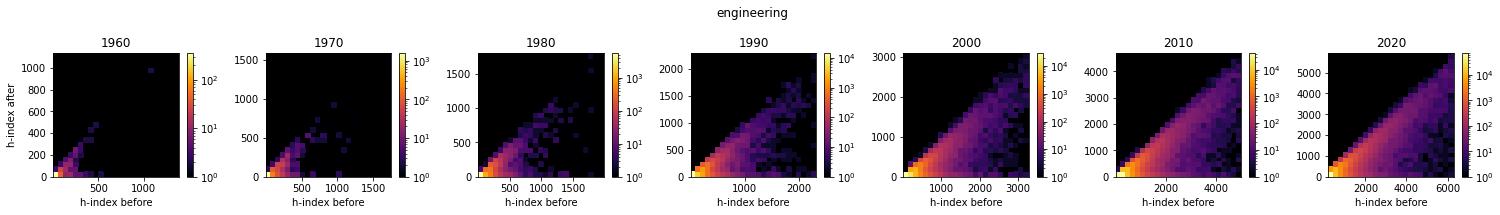

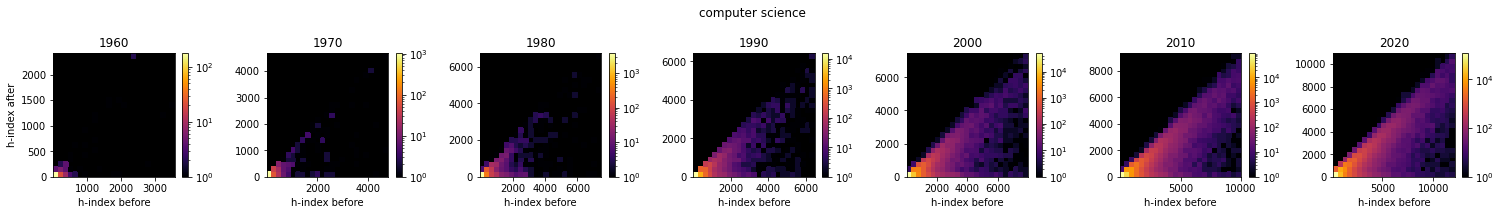

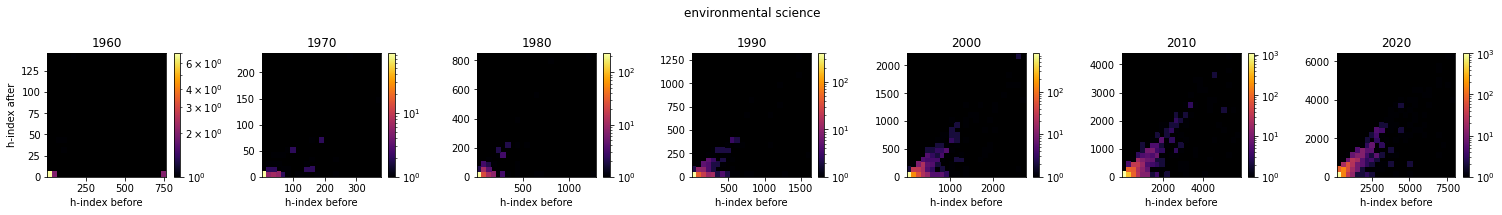

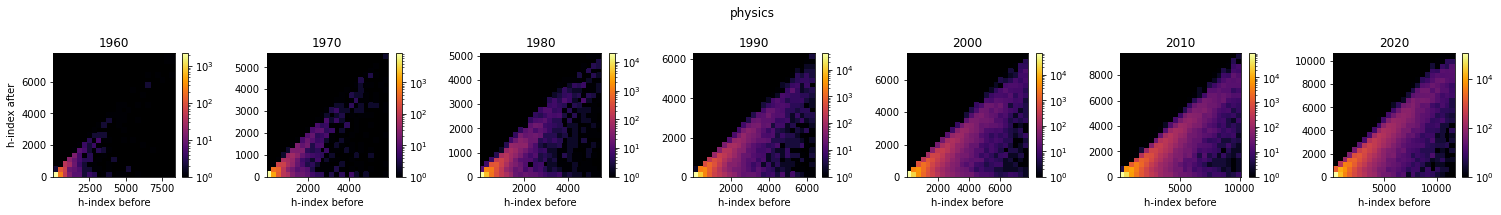

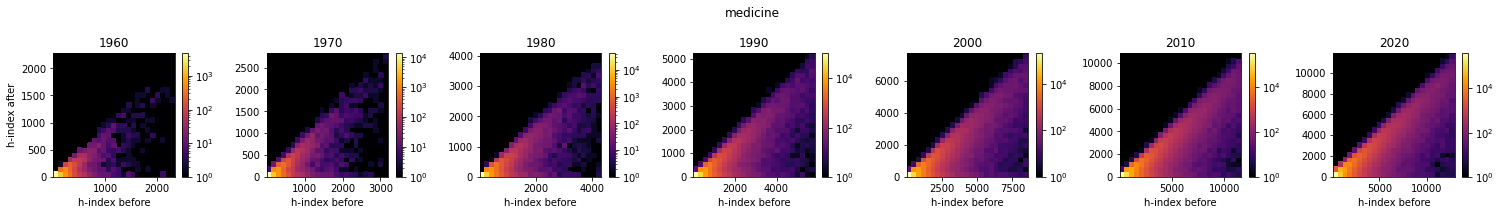

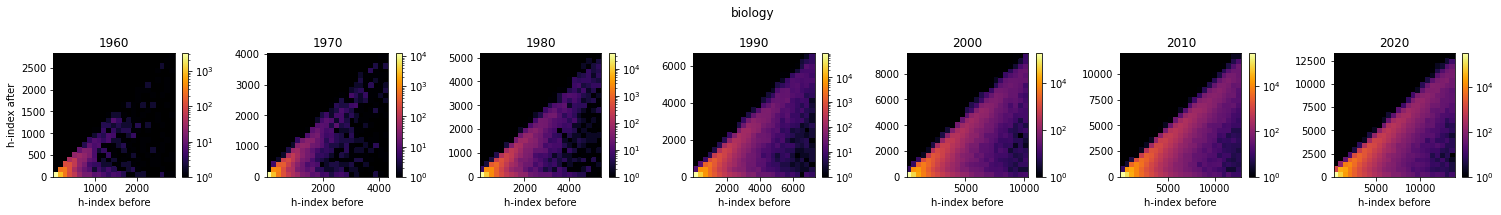

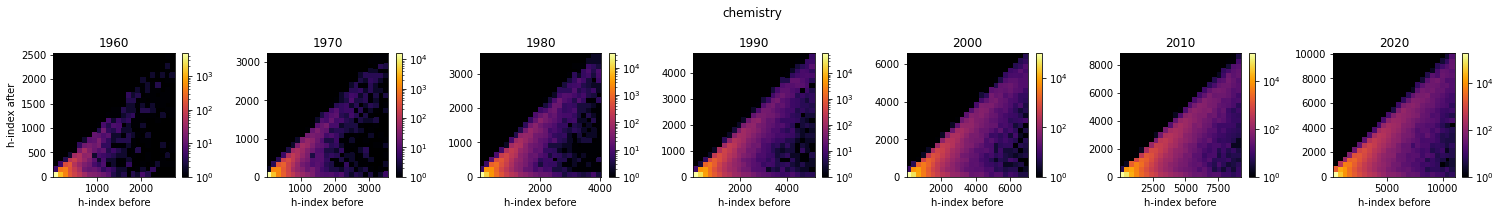

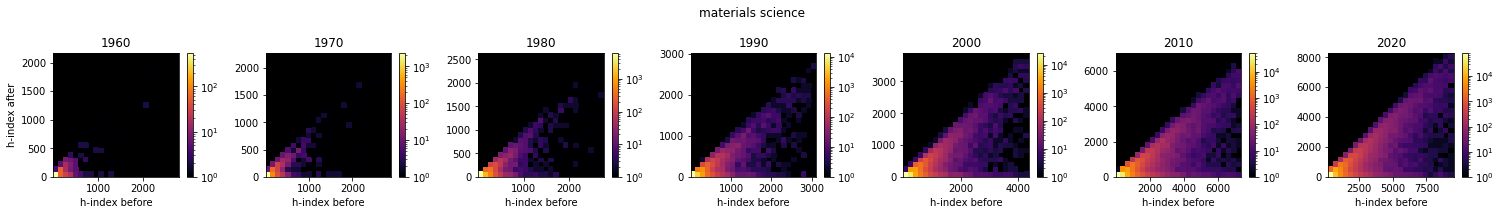

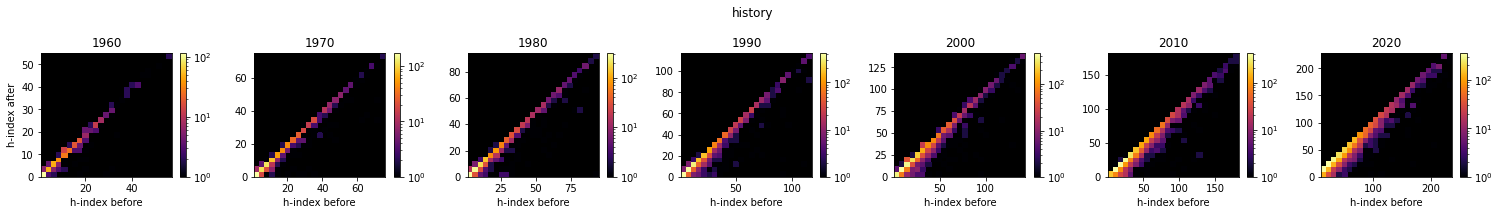

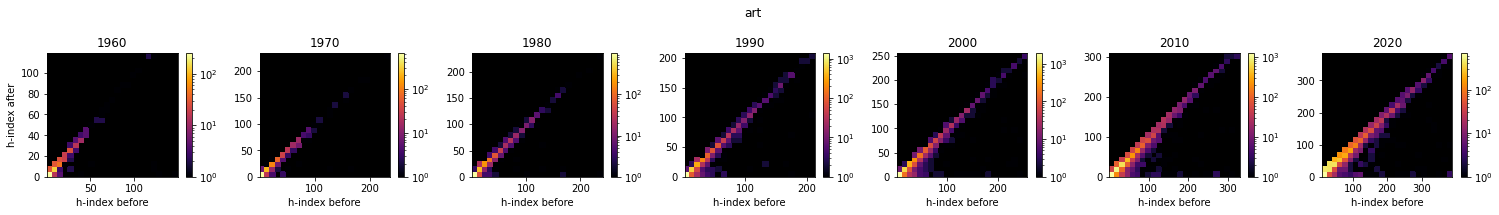

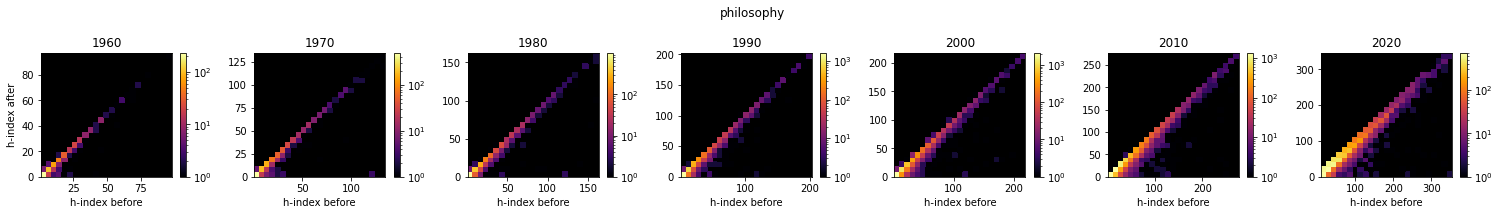

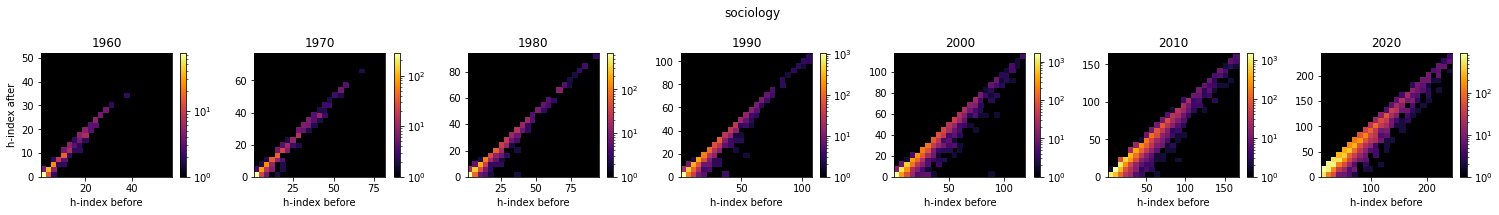

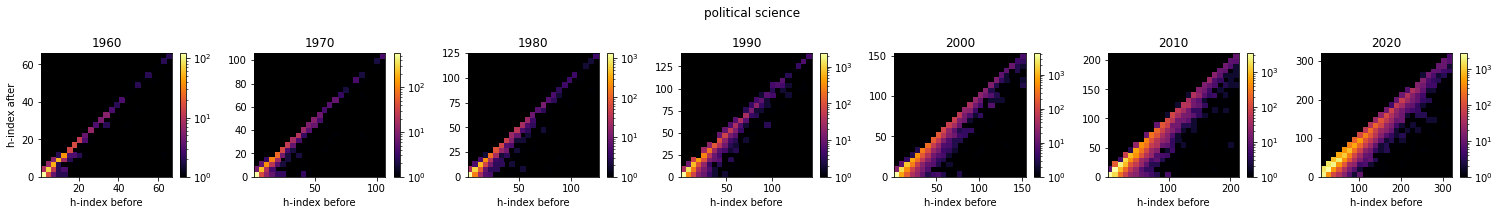

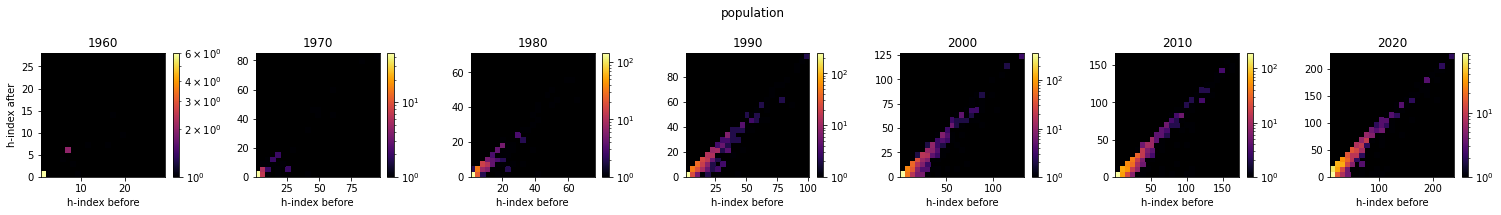

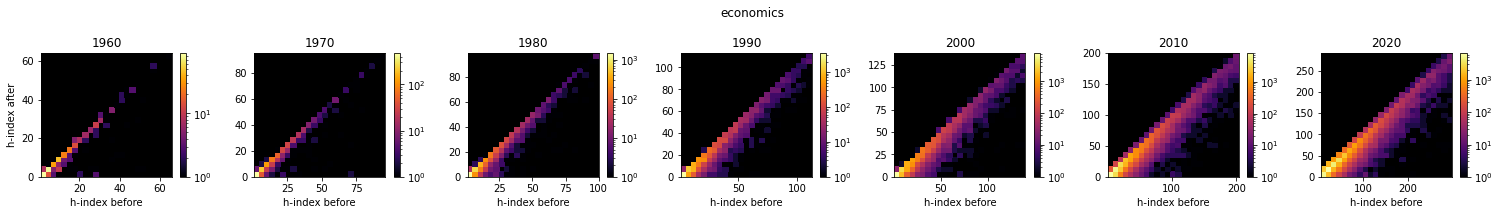

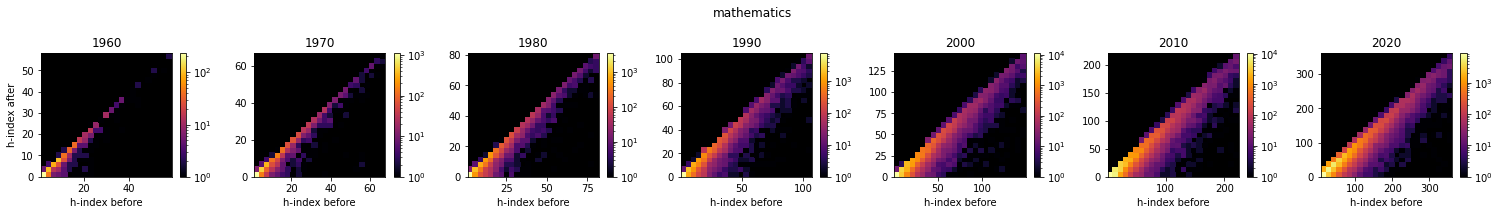

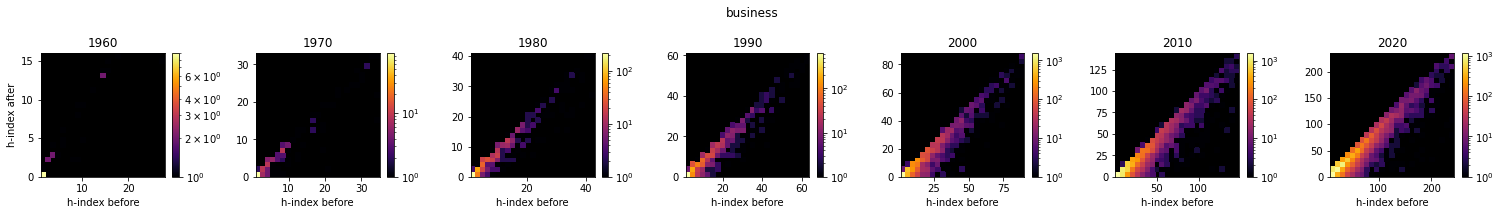

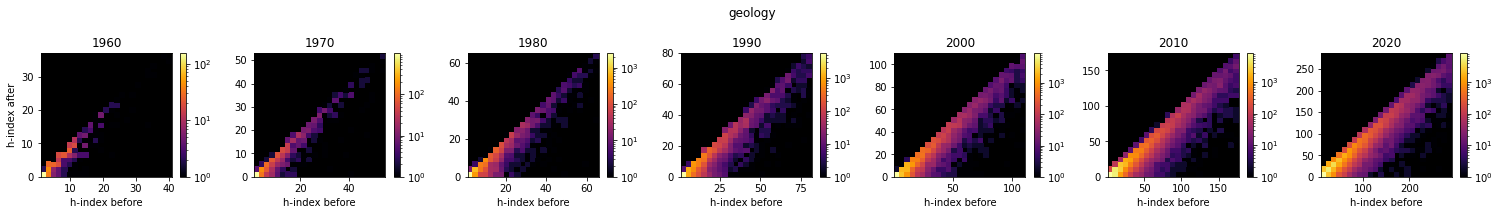

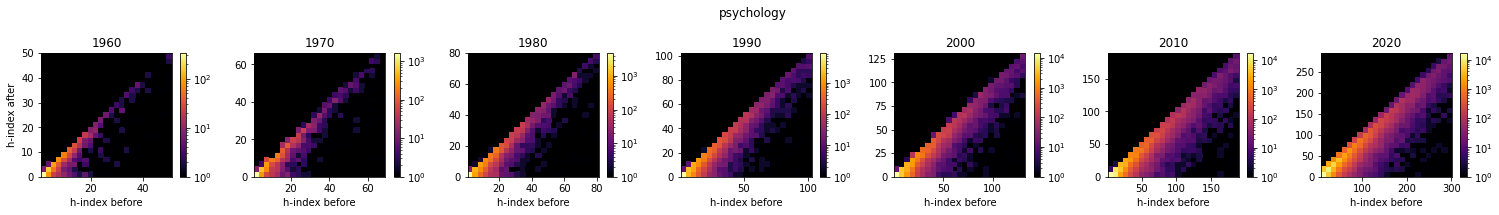

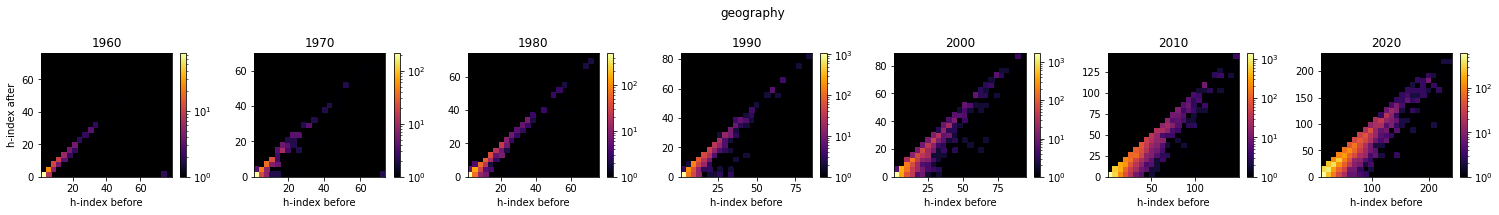

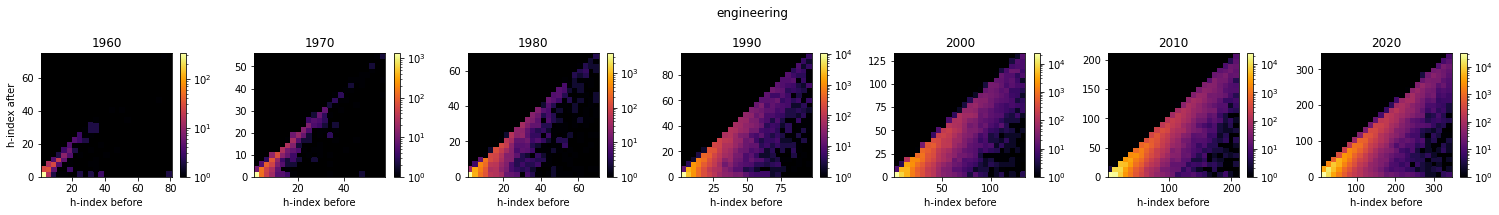

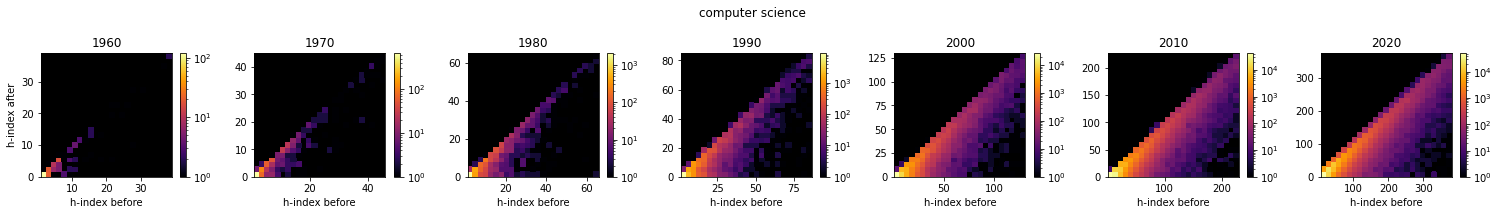

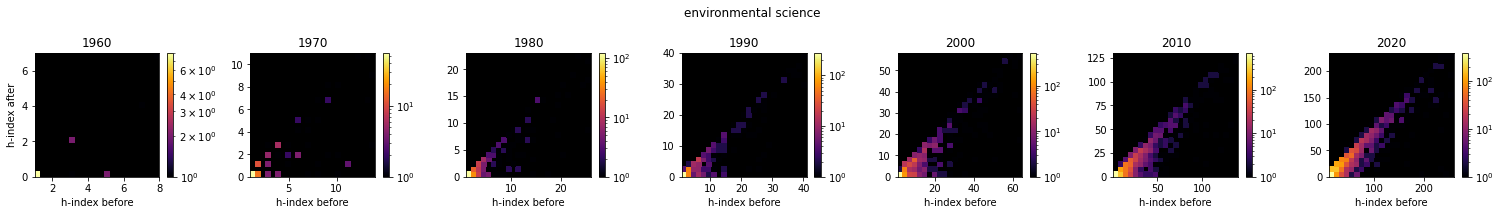

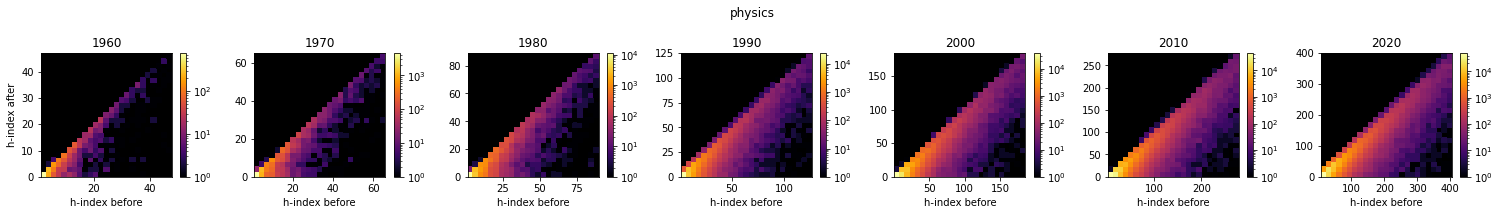

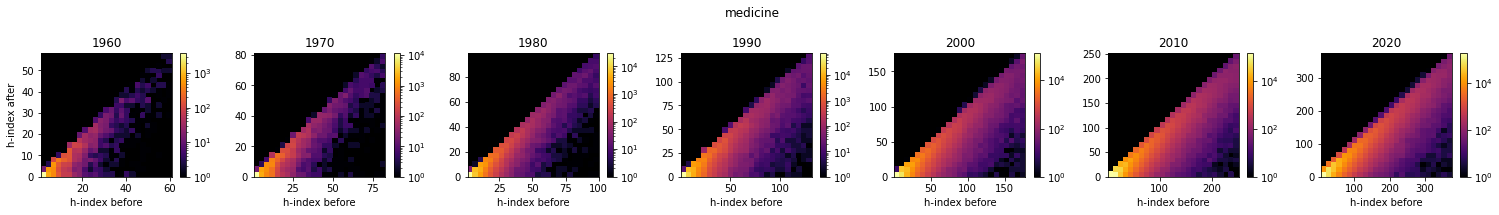

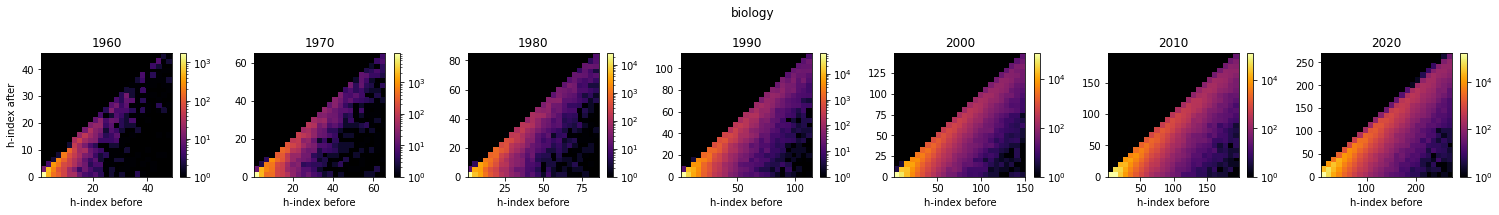

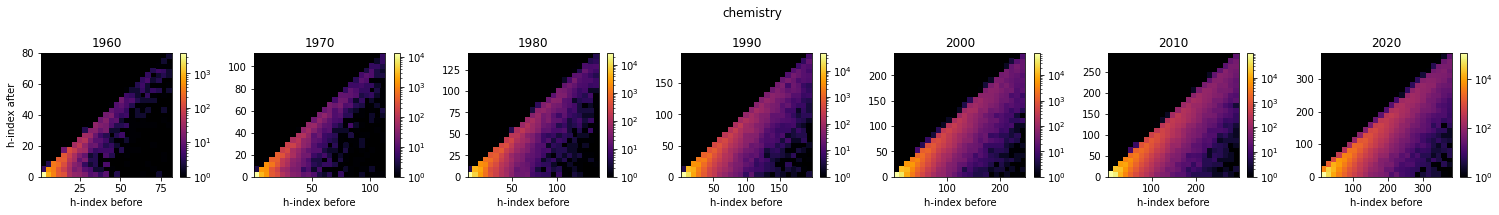

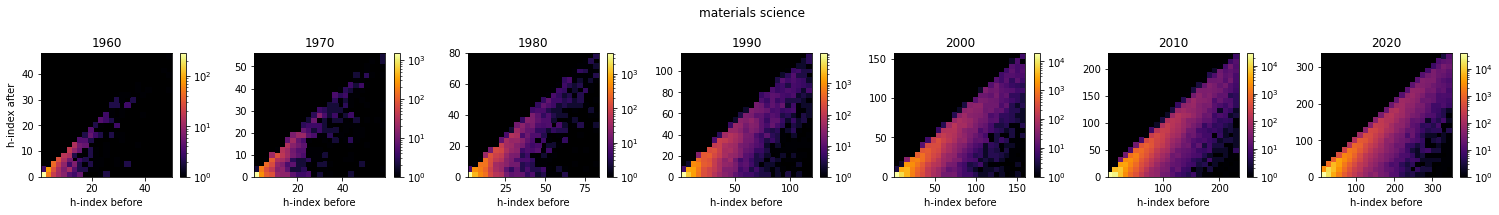

In [8]:
from s4_authors_stats import get_h_index

def _hindex_before_after_temporal(ax, field_name, valid_colabs_cit_list, valid_citation_list, valid_h_index):
    
    hindex_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        diff_cits = acits.copy() # json.loads(acits)
        for ctemp in ccits: # json.loads(ccits):
            diff_cits.remove(ctemp)
            
        hafter = get_h_index(diff_cits)
        hindex_after.append(hafter)
    
    hindex_before_l1 = np.asarray([row[0] for row in valid_h_index])
    hindex_after_l1 = np.asarray(hindex_after)[:,0]
    
    ax.set_facecolor("black")
    perc = np.percentile(hindex_before_l1, 99)
    im = ax.hist2d(hindex_before_l1[hindex_before_l1 <= perc], hindex_after_l1[hindex_before_l1 <= perc], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_title(field_name)
    
    return im, hindex_after 


def _cits_before_after_temporal(ax, field_name, valid_colabs_cit_list, valid_citation_list, valid_h_index):
    cits_before = []
    cits_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        before = sum(acits)
        after = before - sum(ccits)
        
        cits_before.append(before)    
        cits_after.append(after)
    
    cits_before = np.asarray(cits_before)
    cits_after = np.asarray(cits_after)
    
    ax.set_facecolor("black")
    perc = np.percentile(cits_before, 99)
    im = ax.hist2d(cits_before[cits_before <= perc], cits_after[cits_before <= perc], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_title(field_name)
    
    return im, cits_after 
    
    
def _papers_before_after_temporal(ax, field_name, valid_colabs_cit_list, valid_citation_list, valid_h_index):
    p_before = []
    p_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        before = len(acits)
        after = before - len(ccits)
        
        p_before.append(before)    
        p_after.append(after)
    
    p_before = np.asarray(p_before)
    p_after = np.asarray(p_after)
    
    ax.set_facecolor("black")
    perc = np.percentile(p_before, 99)
    im = ax.hist2d(p_before[p_before <= perc], p_after[p_before <= perc], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_title(field_name)
    
    return im, p_after 
    

def hindex_before_after_temporal(get_metric, metric):
    hafter_map = {fos:dict() for fos in fos_sorted}
    for field in fos_sorted:
        fig,axes = plt.subplots(figsize=(21, 3), nrows=1, ncols=7)

        for i, tempsuffix in enumerate(range(1960, 2021, 10)):
            
            FOS = np.asarray(json.load(open('results/fos_10a_full_%d.json' % tempsuffix)))
            X = np.asarray(json.load(open('results/citlist_10a_full_%d.json' % tempsuffix)))
            Y = np.asarray(json.load(open('results/ch_10a_full_%d.json' % tempsuffix)))
            H = np.asarray(json.load(open('results/hindex_10a_full_%d.json' % tempsuffix)))
            idxs = FOS == field
            tempX = X[idxs]
            tempY = Y[idxs]
            tempH = H[idxs]
            im, hafter = get_metric(axes[i], '%d' % tempsuffix, tempX, tempY, tempH)
            hafter_map[field][tempsuffix] = hafter
    
            fig.colorbar(im[3], ax=axes[i])
            axes[i].set_xlabel('h-index before')
            if i == 0:
                axes[i].set_ylabel('h-index after')

        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        fig.suptitle(field_name)
        fig.tight_layout()
        fig.savefig('outputs/fos_hist2d_before_after_%s_%s_temporal.pdf' % (field_name, metric))    
    
    return hafter_map
        
        
# hafter_map = hindex_before_after_temporal(_hindex_before_after_temporal, 'hindex')
citsafter_map = hindex_before_after_temporal(_cits_before_after_temporal, 'cits')
papersafter_map = hindex_before_after_temporal(_papers_before_after_temporal, 'papers')

### Authors' ranks

In [9]:
def rank(values, i, new_val):
    new_pair = np.array([(new_val[0], new_val[1], new_val[2], i[-1])], dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

def get_rank_after(hindexbefore, i, ccits, acits):
    diff_cits = acits.copy() #json.loads(acits)
    for ctemp in ccits: #json.loads(ccits):
        diff_cits.remove(ctemp)
    hafter = get_h_index(diff_cits)
#     print(hafter, i, acits)
    rafter = rank(hindexbefore, i, (-hafter[0], -hafter[1], -hafter[2]))
    return rafter

In [10]:
import tqdm

def rank_cits(values, i, new_val):
    new_pair = np.array([(new_val[0], i[-1])], dtype=[('my_val1', int), ('my_val2', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank


def get_rank_author(hindexbefore, i, citsafter):
    rafter = rank_cits(hindexbefore, i, (-citsafter,))
    return rafter


def _plot_rank_temporal(ax, hindex_after, field_name, valid_h_index, valid_citation_list, valid_colabs_cit_list):
    neg_hindex = np.array([(-row[0], -row[1], -row[2], i) for i,row in enumerate(valid_h_index)], 
                          dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    
    neg_hindex_sorted = np.sort(neg_hindex)
    rankbefore = rankdata(neg_hindex, method='ordinal')

    temp = 0
    results = []
    for a,b,c in tqdm.tqdm(zip(neg_hindex, valid_colabs_cit_list, valid_citation_list), total=len(neg_hindex)):
        results.append(get_rank_after(neg_hindex_sorted, a,b,c)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def _plot_rank_cits(ax, metric_after, field_name, valid_h_index, valid_citation_list, valid_colabs_cit_list):
    valid_citation_list2 = [sum(temp) for temp in valid_citation_list]
    
    neg_cits = np.array([(-row, i) for i,row in enumerate(valid_citation_list2)], 
                          dtype=[('my_val1', int), ('my_val2', int)])
    neg_cits_sorted = np.sort(neg_cits)
    rankbefore = rankdata(neg_cits, method='ordinal')

    results = []
    for c, cafter in tqdm.tqdm(zip(neg_cits, metric_after), total=len(neg_cits)):
        results.append(get_rank_author(neg_cits_sorted, c, cafter)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def _plot_rank_papers(ax, metric_after, field_name, valid_h_index, valid_citation_list, valid_colabs_cit_list):
    valid_papers_list = [len(temp) for temp in valid_citation_list]
    
    neg_cits = np.array([(-row, i) for i,row in enumerate(valid_papers_list)], 
                          dtype=[('my_val1', int), ('my_val2', int)])
    neg_cits_sorted = np.sort(neg_cits)
    rankbefore = rankdata(neg_cits, method='ordinal')

    results = []
    for c, cafter in tqdm.tqdm(zip(neg_cits, metric_after), total=len(neg_cits)):
        results.append(get_rank_author(neg_cits_sorted, c, cafter)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def plot_rank_temporal(hafter_map, _plot_rank, xlabel, ylabel, outname):

    for field in fos_sorted:
        fig,axes = plt.subplots(figsize=(21, 3), nrows=1, ncols=7)
        for i, tempsuffix in enumerate(range(1960, 2021, 10)):
    
            FOS = np.asarray(json.load(open('results/fos_10a_full_%d.json' % tempsuffix)))
            
            H = np.asarray(json.load(open('results/hindex_10a_full_%d.json' % tempsuffix)))
            X = np.asarray(json.load(open('results/ch_10a_full_%d.json' % tempsuffix)))
            Y = np.asarray(json.load(open('results/citlist_10a_full_%d.json' % tempsuffix)))
            
            idxs = FOS == field
            tempX = X[idxs]
            tempY = Y[idxs]
            tempH = H[idxs]
            
    
            im = _plot_rank(axes[i], hafter_map[field][tempsuffix], "%d" % tempsuffix,
                                    tempH, tempX, tempY)

            if i == 0: 
                axes[i].set_ylabel(ylabel)
            axes[i].set_xlabel(xlabel)

            fig.colorbar(im[3], ax=axes[i])

        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
            
        fig.suptitle(field_name)
        fig.tight_layout()
        fig.savefig('outputs/fos_hist2d_rank_%s_%s_temporal.pdf' % (outname, field_name))
        fig.show()

/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 3409/3409 [00:00<00:00, 186133.23it/s]
/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 4824/4824 [00:00<00:00, 187198.25it/s]
/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecat

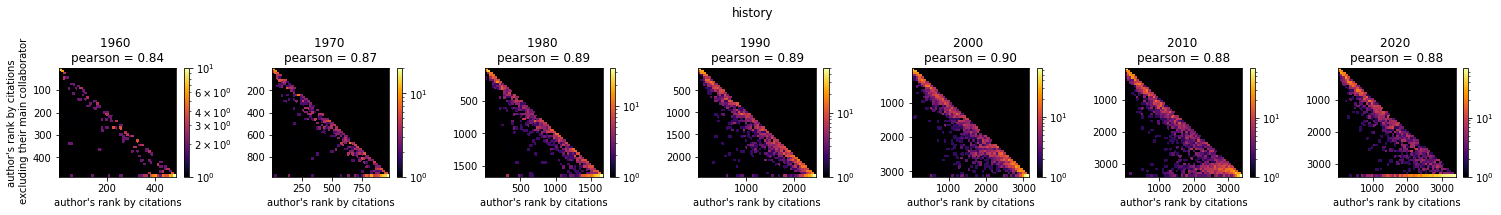

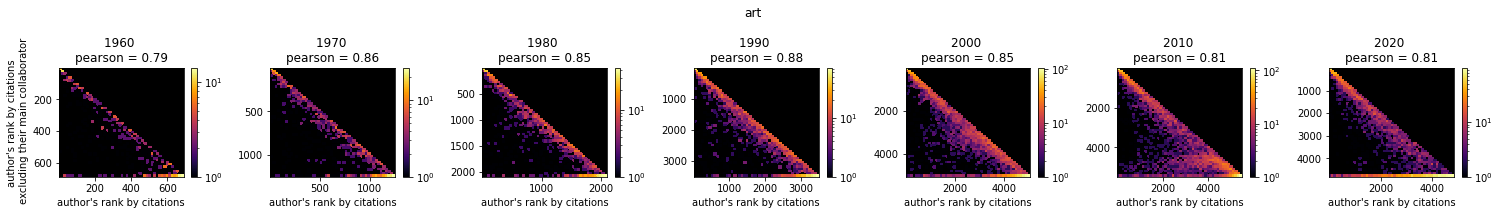

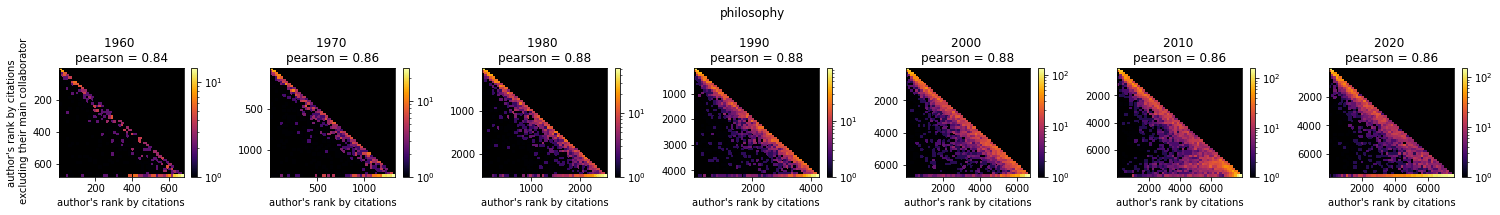

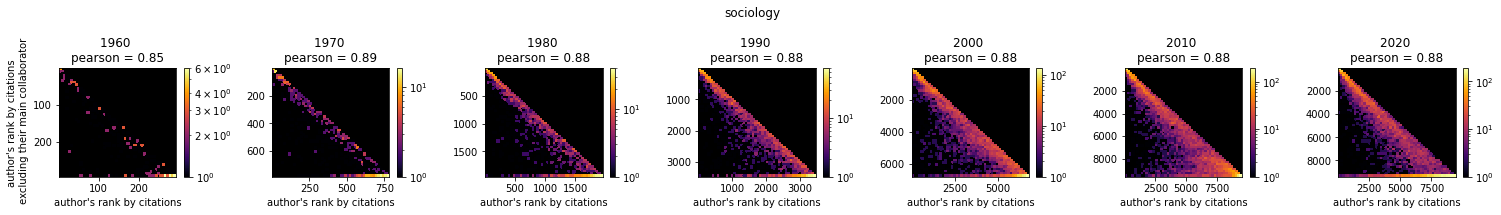

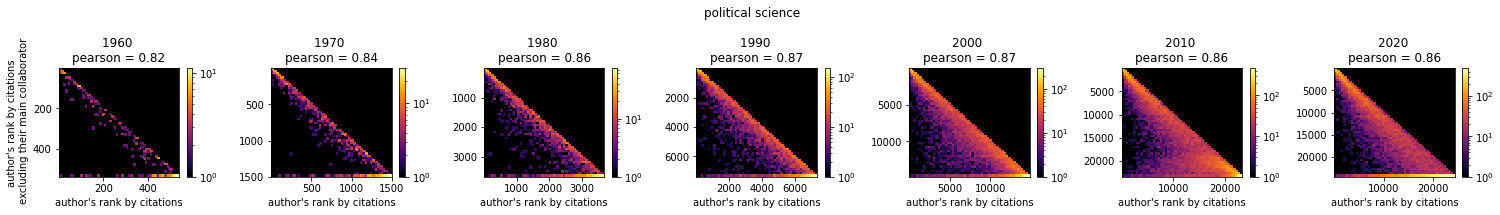

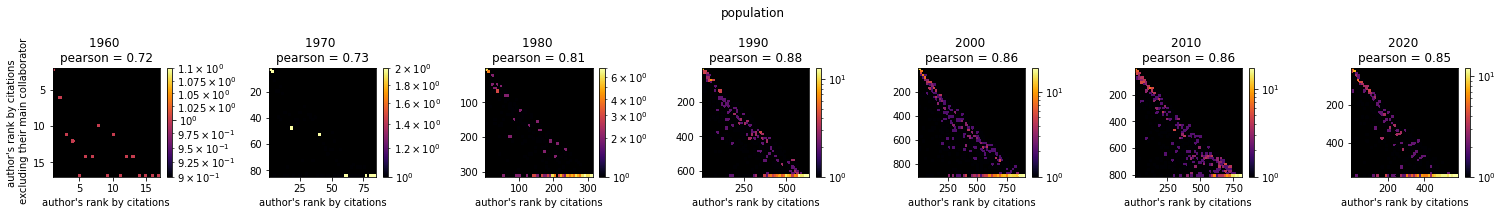

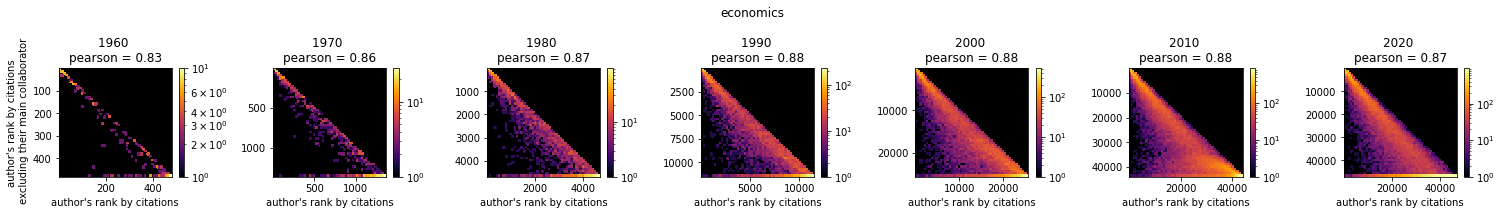

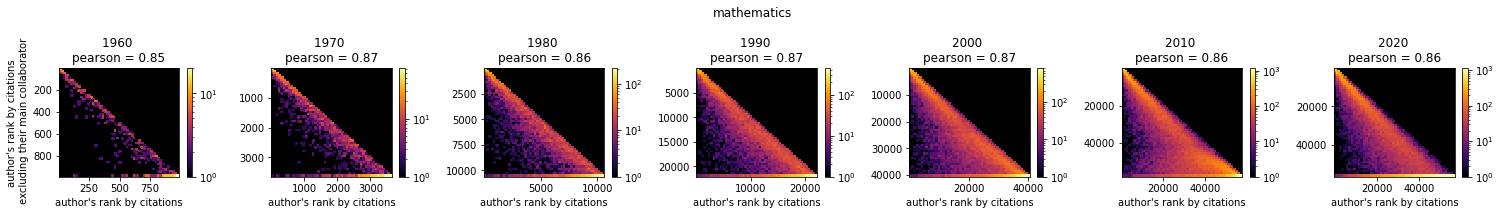

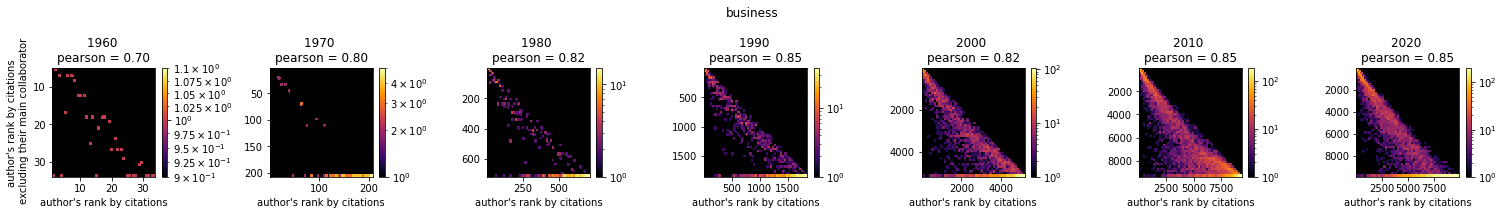

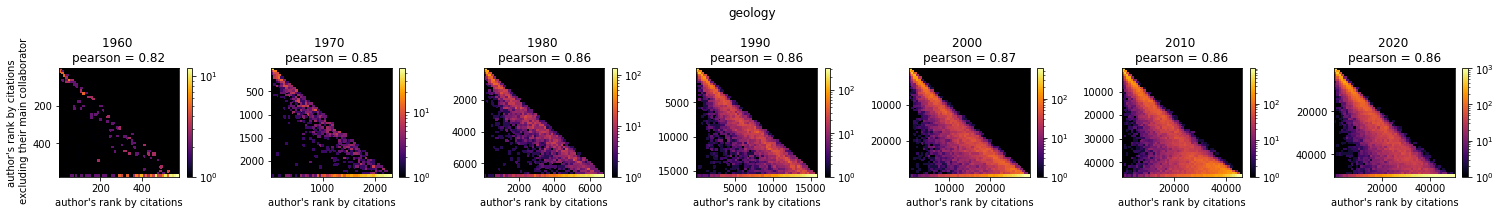

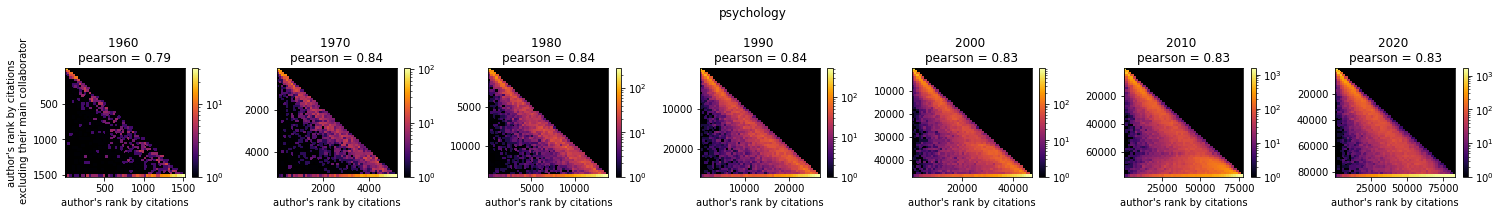

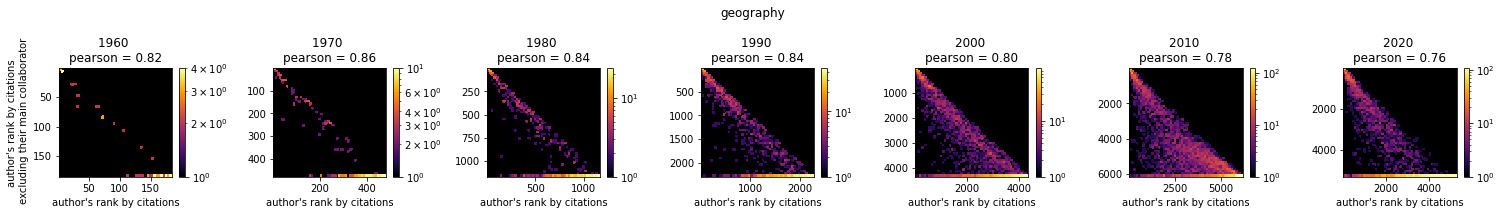

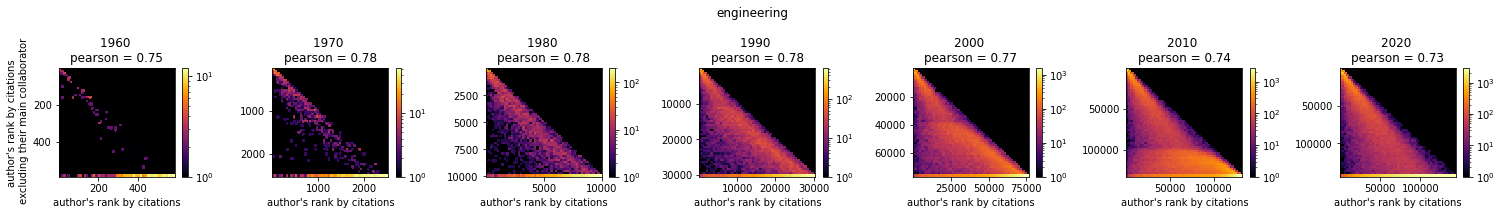

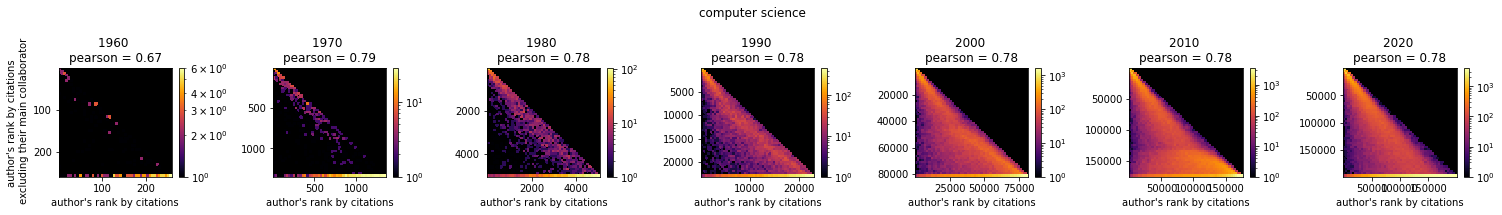

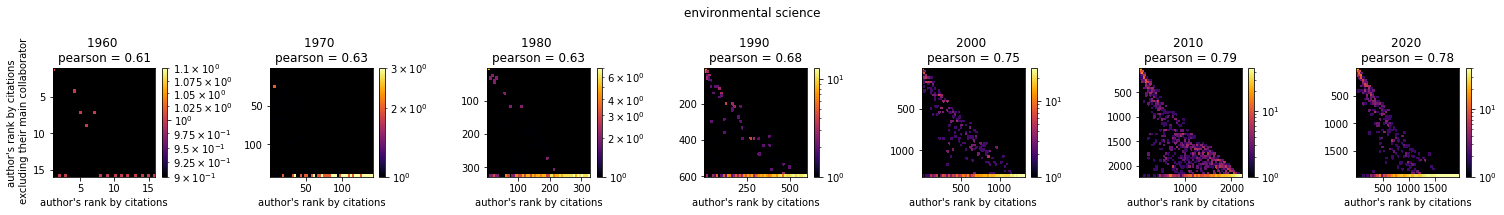

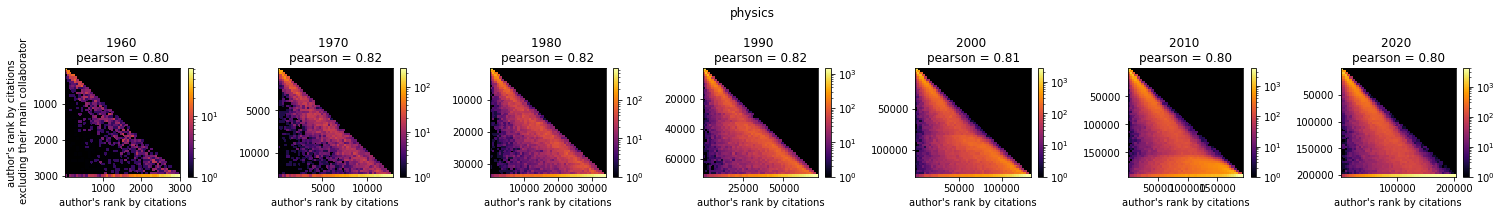

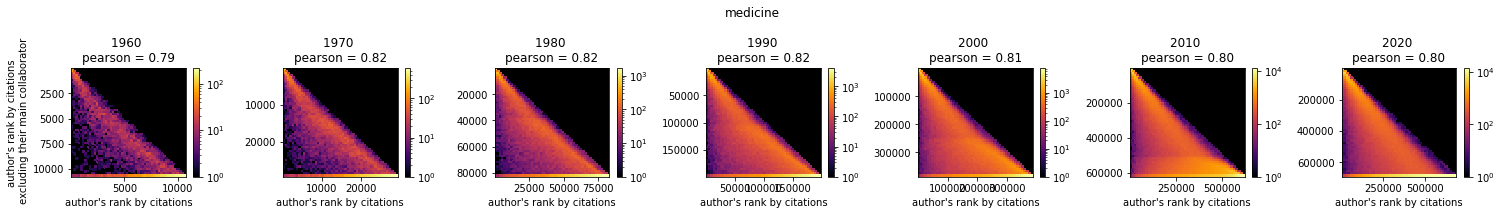

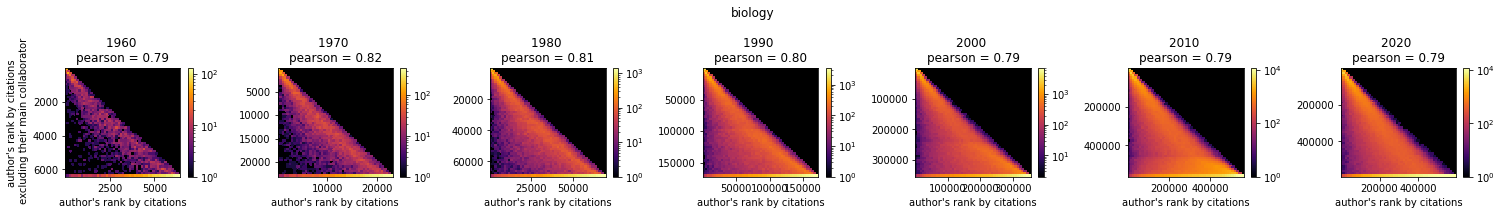

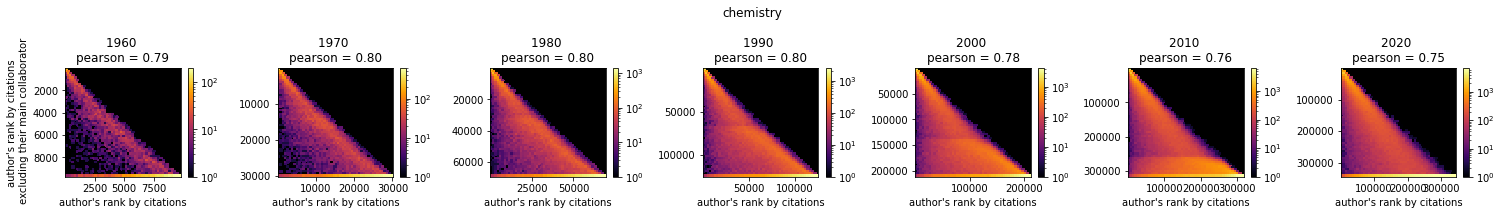

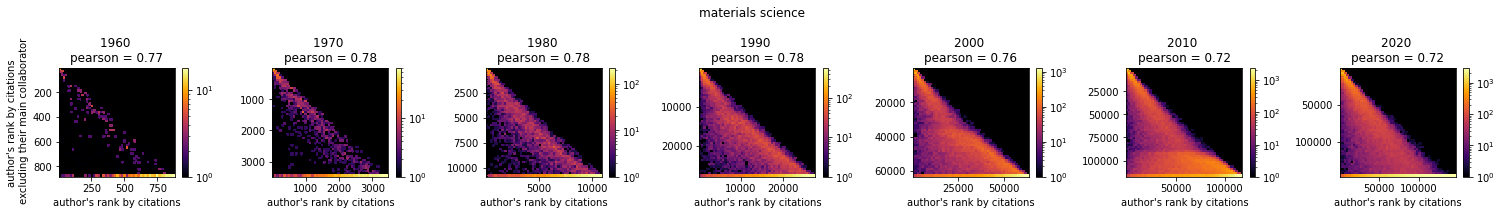

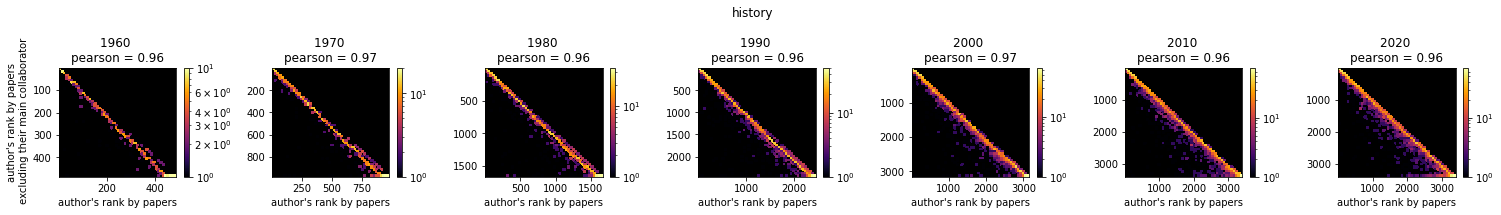

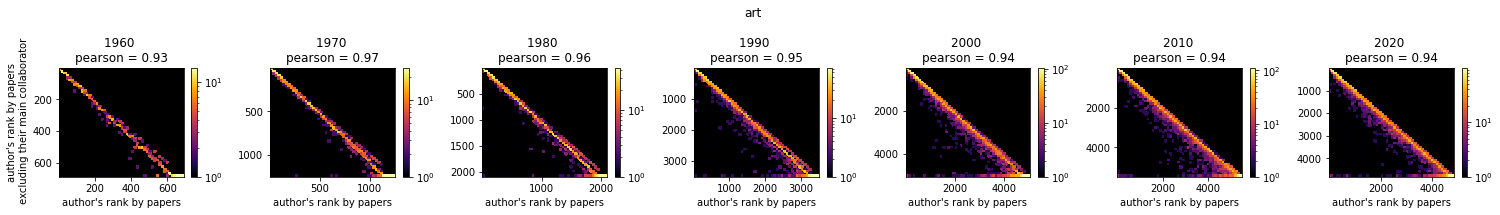

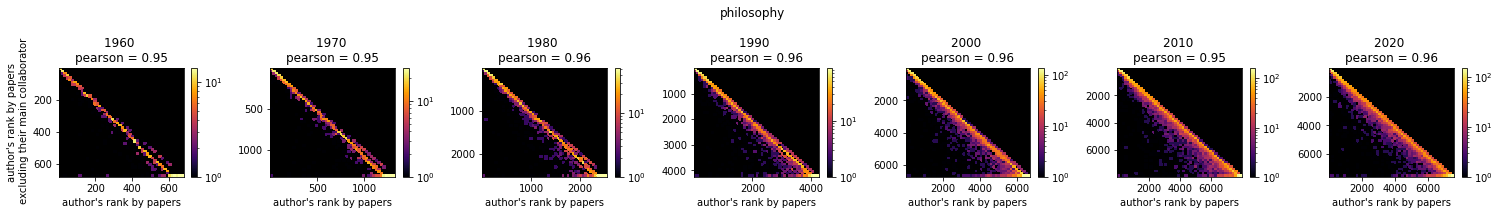

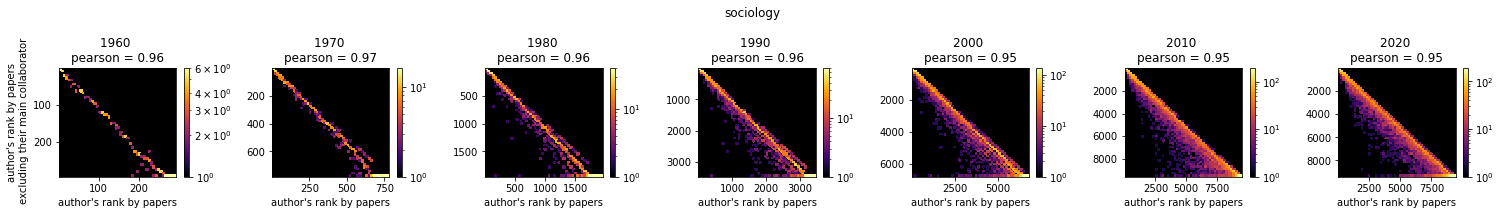

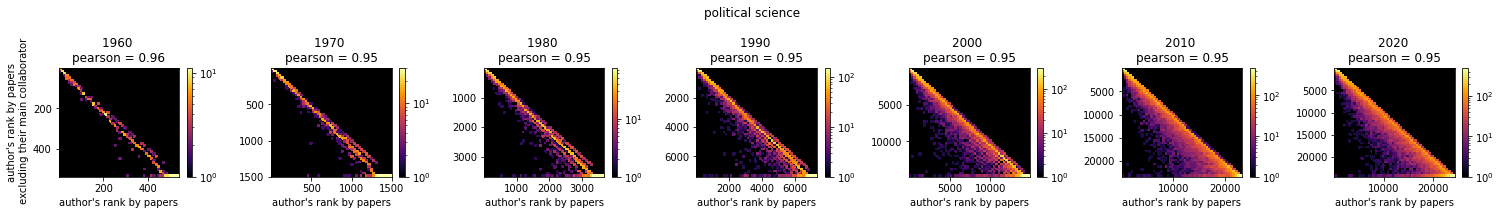

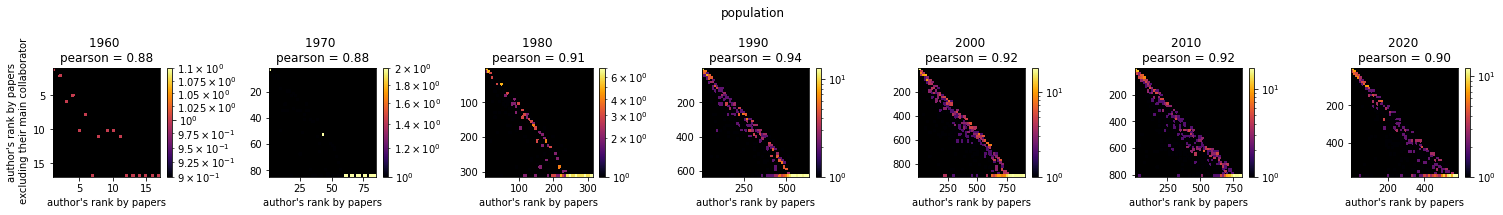

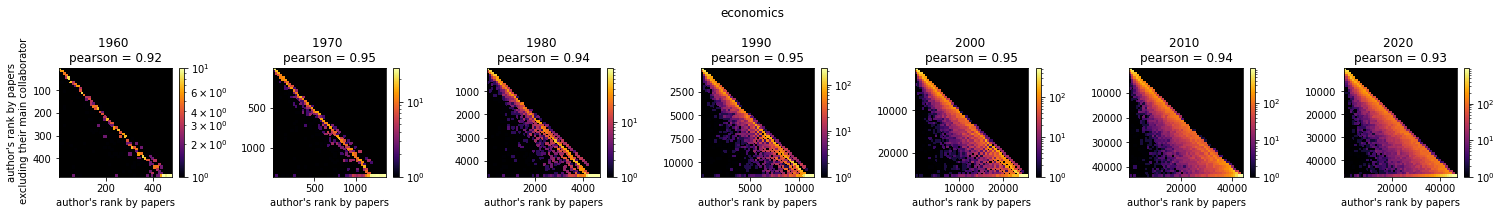

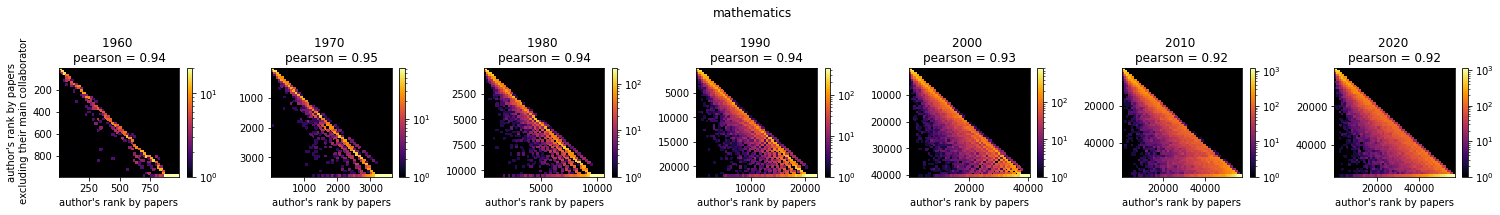

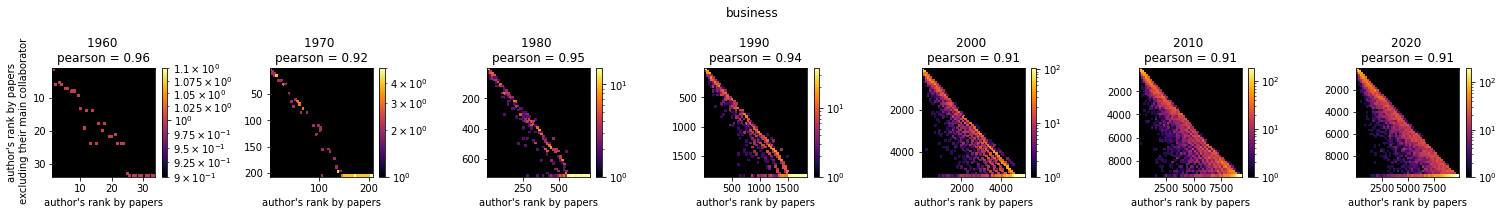

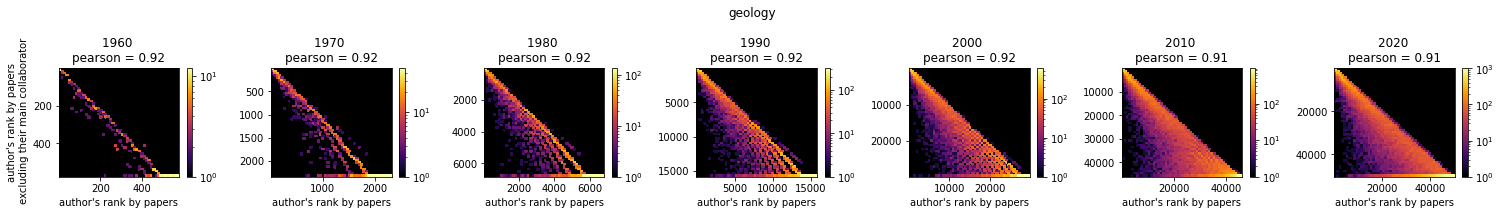

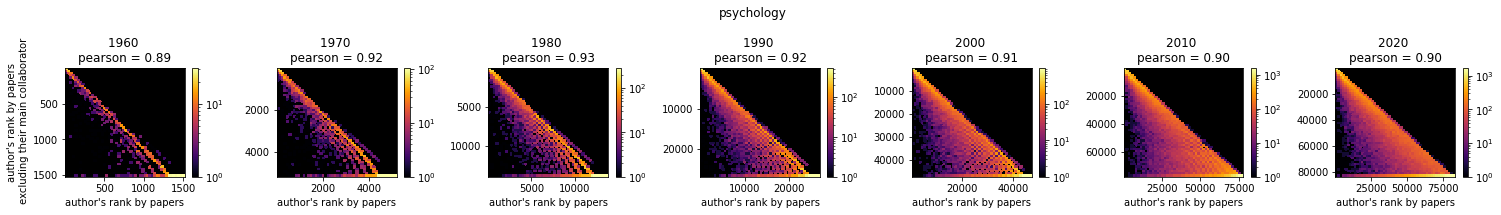

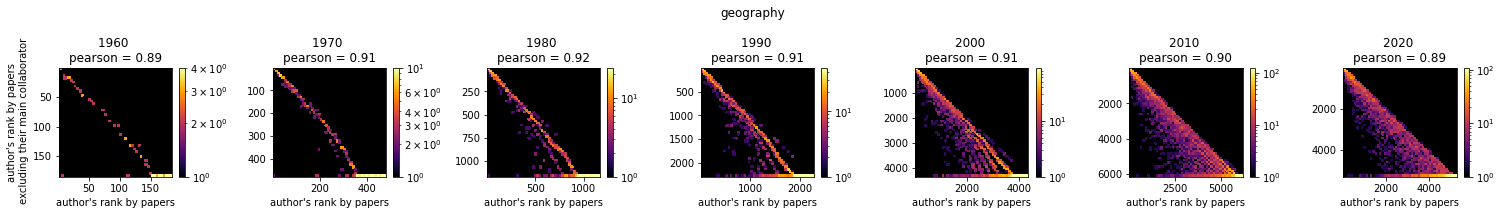

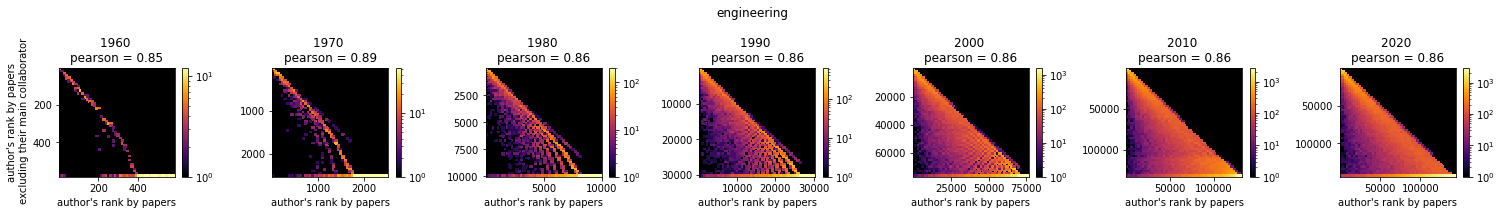

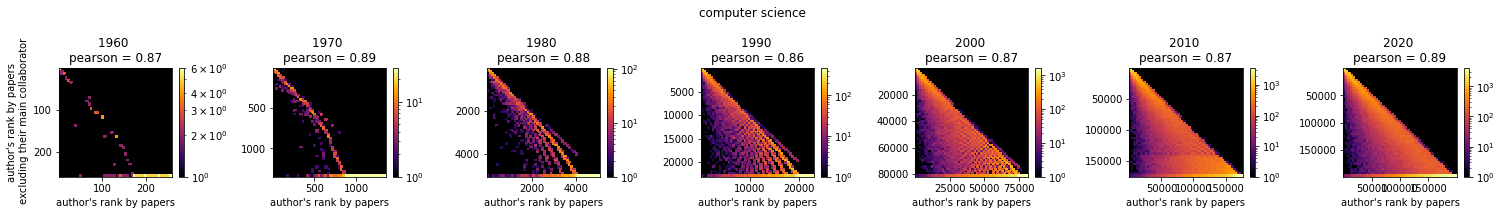

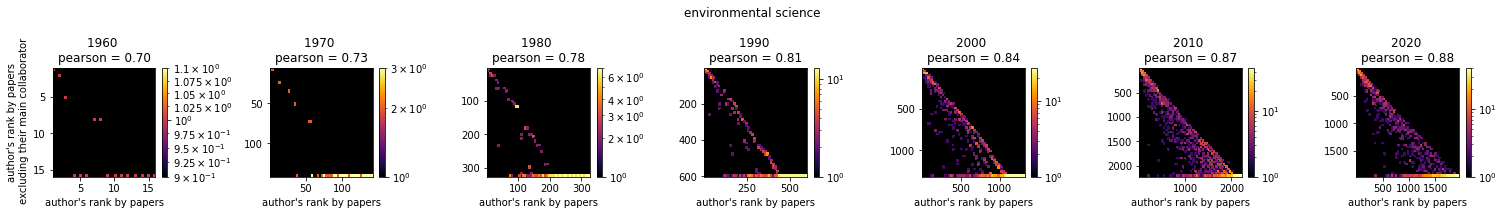

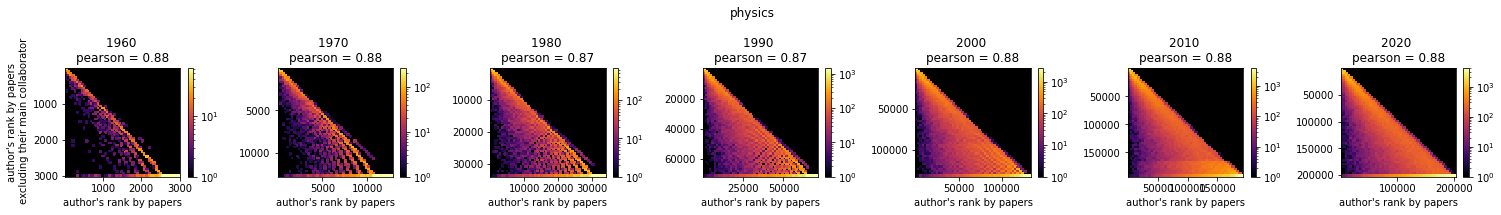

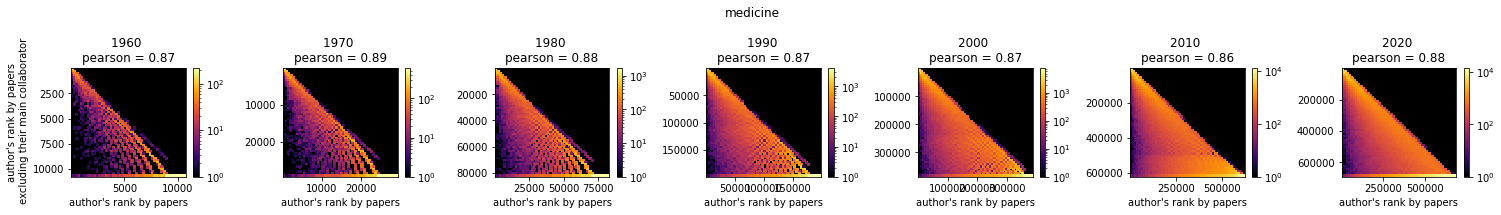

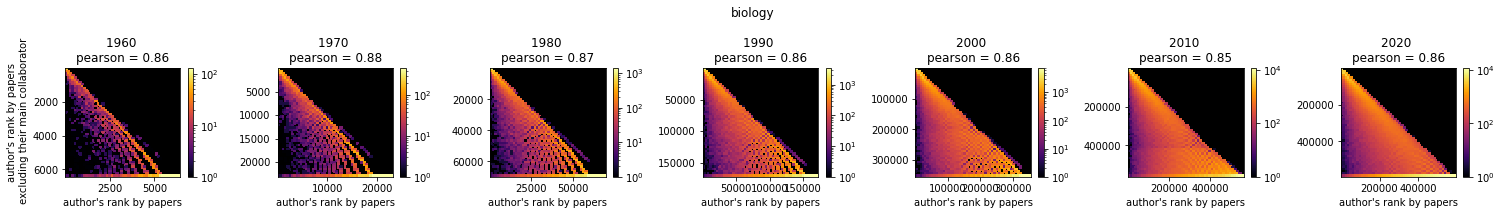

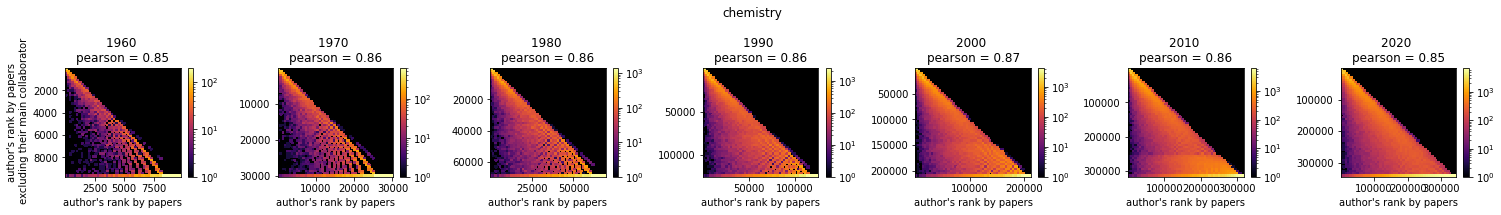

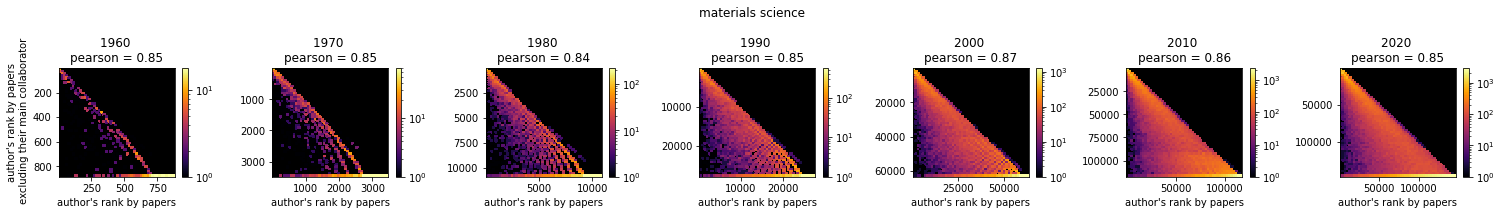

In [11]:
# ylabel = 'author\'s rank by h-index\n excluding their main collaborator'
# xlabel = 'author\'s rank by citations'
# outname = 'hindex'
# plot_rank_temporal(hafter_map, _plot_rank_temporal, xlabel, ylabel, outname)

ylabel = 'author\'s rank by citations\n excluding their main collaborator'
xlabel = 'author\'s rank by citations'
outname = 'cits'
plot_rank_temporal(citsafter_map, _plot_rank_cits, xlabel, ylabel, outname)

ylabel = 'author\'s rank by papers\n excluding their main collaborator'
xlabel = 'author\'s rank by papers'
outname = 'papers'
plot_rank_temporal(papersafter_map, _plot_rank_papers, xlabel, ylabel, outname)